# Low-Dimensional Representation Using Autoencoder

## Getting the Data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
# raw data location
data_path = 'visapy_data.npy'

In [148]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 15
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [149]:
Probe = HierlmannVisapyEmulationProbe(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


## Detecting Spikes

In [150]:
H.DetectFromRaw()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

In [151]:
H.LoadDetected()

Detected and read 32826 spikes.


In [152]:
# x = []
# for i in range(10000):
#     x.append(H.spikes.Amplitude[i]/np.amin(np.array(H.spikes.Shape[i])))
# #print(x)
# print(np.median(np.array(x)))

In [153]:
# plt.figure(figsize=(12, 8))
# plt.grid()
# H.PlotTracesChannels(18, window_size=70)

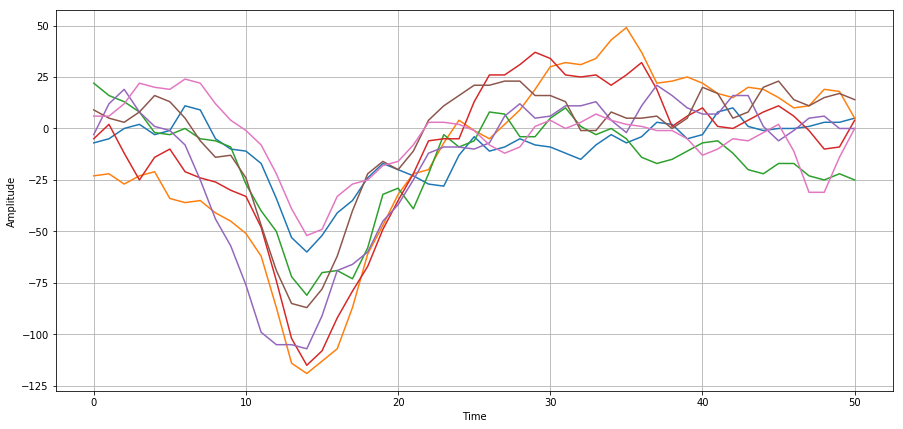

In [154]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15,7))
for i in [14, 18, 77, 90, 156, 180, 299]:
    plt.plot(H.spikes['Shape'][i])
plt.grid()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
fig.savefig('sample'+str(threshold)+".png", bbox_inches='tight')

In [155]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]
embedding_size = (int)(length//4)

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(32826, 51)


In [10]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=12)
# pca.fit(electrode_data)
# e_data_pca = pca.transform(electrode_data_train)
# e_data_proj = pca.inverse_transform(e_data_pca)

In [11]:
# plt.figure(figsize=(14,4))

# n = [3490, 1098, 2377, 9, 871]

# for i in n:
#     plt.subplot(121)
#     plt.plot(electrode_data_test[i, :])
#     plt.title('Original')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.subplot(122)
#     plt.plot(e_data_proj[i, :])
#     plt.title('PCA reconstruction')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
# plt.show()

## Scaling data between 0 and 1

In [12]:
# electrode_data = electrode_data_temp[:, :]

In [115]:
print(electrode_data)
print(np.amax(electrode_data), np.amin(electrode_data))

[[ -8.   0.  -8. ...  40.  29.  28.]
 [ -2.   2.   4. ...  47.  61.  58.]
 [ -7. -20. -25. ...   0.   0.   3.]
 ...
 [-10. -23. -40. ...  16.  19.  14.]
 [-12. -21. -25. ...  22.  31.  32.]
 [-18. -28. -27. ...  36.  33.  33.]]
111.0 -258.0


In [96]:
# max_val = np.amax(electrode_data)
# min_val = np.amin(electrode_data)
# span = max_val - min_val
# electrode_data = (electrode_data)/(span)

In [97]:
# print(electrode_data)
# print(np.amax(electrode_data), np.amin(electrode_data))

[[-0.02168022  0.         -0.02168022 ...  0.10840108  0.07859079
   0.07588076]
 [-0.00542005  0.00542005  0.01084011 ...  0.12737127  0.16531165
   0.15718157]
 [-0.01897019 -0.05420054 -0.06775068 ...  0.          0.
   0.00813008]
 ...
 [-0.02710027 -0.06233062 -0.10840108 ...  0.04336043  0.05149051
   0.03794038]
 [-0.03252033 -0.05691057 -0.06775068 ...  0.0596206   0.08401084
   0.08672087]
 [-0.04878049 -0.07588076 -0.07317073 ...  0.09756098  0.08943089
   0.08943089]]
0.3008130081300813 -0.6991869918699187


## Designing the AutoEncoder 

In [53]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(2)
torch.manual_seed(0)

In [112]:
class autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 28),
                                     activation_layer,
                                     nn.Linear(28, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

## Splitting the data into Train and Test

In [156]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (26260, 51)
Test Datasize: (6566, 51)


In [80]:
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

In [81]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Training with embedding size = 12

In [113]:
epoch_range = 500
batch_size = 150
learning_rate = 0.0001
embedding_size = 12

ae_1 = autoencoder(length, embedding_size).cuda()
ae_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_1.parameters(), lr=learning_rate)

enc, out, losses_1 = train_ae(ae_1, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/500], loss:0.01225, avg:0.01225
epoch [2/500], loss:0.00671, avg:0.00948
epoch [3/500], loss:0.00663, avg:0.00853
epoch [4/500], loss:0.00219, avg:0.00695
epoch [5/500], loss:0.00104, avg:0.00577
epoch [6/500], loss:0.00102, avg:0.00497
epoch [7/500], loss:0.00384, avg:0.00481
epoch [8/500], loss:0.00235, avg:0.00450
epoch [9/500], loss:0.00061, avg:0.00407
epoch [10/500], loss:0.00121, avg:0.00379
epoch [11/500], loss:0.00093, avg:0.00265
epoch [12/500], loss:0.00251, avg:0.00223
epoch [13/500], loss:0.00122, avg:0.00169
epoch [14/500], loss:0.00151, avg:0.00163
epoch [15/500], loss:0.00246, avg:0.00177
epoch [16/500], loss:0.00018, avg:0.00168
epoch [17/500], loss:0.00088, avg:0.00139
epoch [18/500], loss:0.00111, avg:0.00126
epoch [19/500], loss:0.00080, avg:0.00128
epoch [20/500], loss:0.00189, avg:0.00135
epoch [21/500], loss:0.00129, avg:0.00138
epoch [22/500], loss:0.00124, avg:0.00126
epoch [23/500], loss:0.00083, avg:0.00122
epoch [24/500], loss:0.00108, avg:0.00118
e

epoch [195/500], loss:0.00017, avg:0.00018
epoch [196/500], loss:0.00019, avg:0.00019
epoch [197/500], loss:0.00021, avg:0.00019
epoch [198/500], loss:0.00040, avg:0.00020
epoch [199/500], loss:0.00014, avg:0.00020
epoch [200/500], loss:0.00014, avg:0.00021
epoch [201/500], loss:0.00028, avg:0.00021
epoch [202/500], loss:0.00023, avg:0.00022
epoch [203/500], loss:0.00034, avg:0.00024
epoch [204/500], loss:0.00022, avg:0.00023
epoch [205/500], loss:0.00014, avg:0.00023
epoch [206/500], loss:0.00020, avg:0.00023
epoch [207/500], loss:0.00009, avg:0.00022
epoch [208/500], loss:0.00018, avg:0.00020
epoch [209/500], loss:0.00020, avg:0.00020
epoch [210/500], loss:0.00031, avg:0.00022
epoch [211/500], loss:0.00019, avg:0.00021
epoch [212/500], loss:0.00017, avg:0.00020
epoch [213/500], loss:0.00025, avg:0.00019
epoch [214/500], loss:0.00007, avg:0.00018
epoch [215/500], loss:0.00039, avg:0.00020
epoch [216/500], loss:0.00010, avg:0.00019
epoch [217/500], loss:0.00022, avg:0.00021
epoch [218/

epoch [386/500], loss:0.00026, avg:0.00014
epoch [387/500], loss:0.00029, avg:0.00015
epoch [388/500], loss:0.00010, avg:0.00015
epoch [389/500], loss:0.00014, avg:0.00016
epoch [390/500], loss:0.00010, avg:0.00015
epoch [391/500], loss:0.00008, avg:0.00015
epoch [392/500], loss:0.00009, avg:0.00015
epoch [393/500], loss:0.00016, avg:0.00016
epoch [394/500], loss:0.00013, avg:0.00015
epoch [395/500], loss:0.00020, avg:0.00016
epoch [396/500], loss:0.00016, avg:0.00015
epoch [397/500], loss:0.00015, avg:0.00013
epoch [398/500], loss:0.00006, avg:0.00013
epoch [399/500], loss:0.00010, avg:0.00012
epoch [400/500], loss:0.00016, avg:0.00013
epoch [401/500], loss:0.00018, avg:0.00014
epoch [402/500], loss:0.00007, avg:0.00014
epoch [403/500], loss:0.00016, avg:0.00014
epoch [404/500], loss:0.00021, avg:0.00015
epoch [405/500], loss:0.00018, avg:0.00014
epoch [406/500], loss:0.00018, avg:0.00015
epoch [407/500], loss:0.00010, avg:0.00014
epoch [408/500], loss:0.00024, avg:0.00016
epoch [409/

In [20]:
# torch.save(ae_1, 'models2/visapy/ae_12.pt') #Saving the autoencoder model

## Loss Plot and Reconstruction

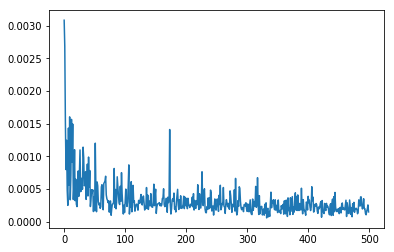

In [111]:
plt.figure()
plt.plot(losses_1)
plt.show()

## Training with embedding size = 10

In [22]:
epoch_range = 5000
batch_size = 150
learning_rate = 0.0001
embedding_size = 10

ae_2 = autoencoder(length, embedding_size).cuda()
ae_2.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_2.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_2 = train_ae(ae_2, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:2433.52246, avg:2433.52246
epoch [2/5000], loss:498.35483, avg:1465.93860
epoch [3/5000], loss:257.45438, avg:1063.11060
epoch [4/5000], loss:507.25931, avg:924.14771
epoch [5/5000], loss:228.97490, avg:785.11316
epoch [6/5000], loss:144.62589, avg:678.36530
epoch [7/5000], loss:107.67406, avg:596.83801
epoch [8/5000], loss:159.70015, avg:542.19574
epoch [9/5000], loss:95.06570, avg:492.51465
epoch [10/5000], loss:349.09000, avg:478.17218
epoch [11/5000], loss:124.34180, avg:247.25410
epoch [12/5000], loss:67.28391, avg:204.14702
epoch [13/5000], loss:153.53575, avg:193.75516
epoch [14/5000], loss:82.70424, avg:151.29964
epoch [15/5000], loss:81.37714, avg:136.53987
epoch [16/5000], loss:273.26407, avg:149.40367
epoch [17/5000], loss:214.12994, avg:160.04927
epoch [18/5000], loss:100.63414, avg:154.14267
epoch [19/5000], loss:152.50607, avg:159.88670
epoch [20/5000], loss:425.81726, avg:167.55943
epoch [21/5000], loss:96.99757, avg:164.82501
epoch [22/5000], loss:1

epoch [180/5000], loss:22.75970, avg:64.60766
epoch [181/5000], loss:49.55984, avg:64.94518
epoch [182/5000], loss:33.61798, avg:59.37199
epoch [183/5000], loss:80.81564, avg:52.43607
epoch [184/5000], loss:50.66082, avg:48.66026
epoch [185/5000], loss:65.25307, avg:49.94978
epoch [186/5000], loss:32.49344, avg:48.45460
epoch [187/5000], loss:25.85165, avg:47.39545
epoch [188/5000], loss:50.68573, avg:44.17727
epoch [189/5000], loss:48.44675, avg:46.01446
epoch [190/5000], loss:23.70241, avg:46.10873
epoch [191/5000], loss:49.56823, avg:46.10957
epoch [192/5000], loss:29.45866, avg:45.69364
epoch [193/5000], loss:33.92189, avg:41.00426
epoch [194/5000], loss:50.16835, avg:40.95501
epoch [195/5000], loss:40.72628, avg:38.50233
epoch [196/5000], loss:87.50726, avg:44.00372
epoch [197/5000], loss:40.36164, avg:45.45472
epoch [198/5000], loss:35.61471, avg:43.94762
epoch [199/5000], loss:35.74502, avg:42.67744
epoch [200/5000], loss:58.58698, avg:46.16590
epoch [201/5000], loss:26.73168, a

epoch [359/5000], loss:52.62189, avg:60.38032
epoch [360/5000], loss:44.88958, avg:58.54459
epoch [361/5000], loss:51.15499, avg:58.83819
epoch [362/5000], loss:30.18863, avg:58.65418
epoch [363/5000], loss:24.15146, avg:55.96228
epoch [364/5000], loss:36.11736, avg:49.12188
epoch [365/5000], loss:41.04500, avg:49.91961
epoch [366/5000], loss:41.49285, avg:48.86570
epoch [367/5000], loss:35.35873, avg:49.66276
epoch [368/5000], loss:34.87328, avg:39.18938
epoch [369/5000], loss:45.95891, avg:38.52308
epoch [370/5000], loss:57.55285, avg:39.78941
epoch [371/5000], loss:45.04897, avg:39.17881
epoch [372/5000], loss:22.48323, avg:38.40826
epoch [373/5000], loss:21.21932, avg:38.11505
epoch [374/5000], loss:57.72233, avg:40.27555
epoch [375/5000], loss:28.07865, avg:38.97891
epoch [376/5000], loss:14.74415, avg:36.30404
epoch [377/5000], loss:45.05360, avg:37.27353
epoch [378/5000], loss:47.32459, avg:38.51866
epoch [379/5000], loss:16.91948, avg:35.61472
epoch [380/5000], loss:29.92357, a

epoch [538/5000], loss:34.19462, avg:39.49551
epoch [539/5000], loss:46.98552, avg:40.66573
epoch [540/5000], loss:36.45450, avg:40.38580
epoch [541/5000], loss:46.28688, avg:42.54849
epoch [542/5000], loss:33.74620, avg:41.90752
epoch [543/5000], loss:39.00308, avg:41.34247
epoch [544/5000], loss:43.21263, avg:41.95118
epoch [545/5000], loss:30.11896, avg:40.79779
epoch [546/5000], loss:37.87399, avg:40.39567
epoch [547/5000], loss:17.24076, avg:36.51171
epoch [548/5000], loss:41.95659, avg:37.28791
epoch [549/5000], loss:89.38282, avg:41.52764
epoch [550/5000], loss:44.58613, avg:42.34080
epoch [551/5000], loss:36.02000, avg:41.31412
epoch [552/5000], loss:48.34633, avg:42.77413
epoch [553/5000], loss:102.96912, avg:49.17073
epoch [554/5000], loss:30.08780, avg:47.85825
epoch [555/5000], loss:26.05089, avg:47.45144
epoch [556/5000], loss:15.35137, avg:45.19918
epoch [557/5000], loss:45.06723, avg:47.98183
epoch [558/5000], loss:31.02165, avg:46.88833
epoch [559/5000], loss:55.31398, 

epoch [717/5000], loss:30.61666, avg:40.57961
epoch [718/5000], loss:42.12945, avg:41.29770
epoch [719/5000], loss:27.95765, avg:40.11646
epoch [720/5000], loss:48.40400, avg:38.81606
epoch [721/5000], loss:42.00024, avg:40.34394
epoch [722/5000], loss:46.33000, avg:38.45894
epoch [723/5000], loss:24.19796, avg:37.92704
epoch [724/5000], loss:64.17406, avg:40.83812
epoch [725/5000], loss:35.30366, avg:39.19822
epoch [726/5000], loss:46.98727, avg:40.81010
epoch [727/5000], loss:27.23104, avg:40.47154
epoch [728/5000], loss:25.86852, avg:38.84544
epoch [729/5000], loss:50.33478, avg:41.08316
epoch [730/5000], loss:40.75929, avg:40.31868
epoch [731/5000], loss:17.27263, avg:37.84592
epoch [732/5000], loss:20.20665, avg:35.23359
epoch [733/5000], loss:48.91893, avg:37.70568
epoch [734/5000], loss:26.85043, avg:33.97332
epoch [735/5000], loss:20.40041, avg:32.48300
epoch [736/5000], loss:42.65644, avg:32.04991
epoch [737/5000], loss:34.55441, avg:32.78225
epoch [738/5000], loss:28.08859, a

epoch [896/5000], loss:46.27387, avg:32.30105
epoch [897/5000], loss:35.17003, avg:32.94790
epoch [898/5000], loss:26.77641, avg:27.50148
epoch [899/5000], loss:43.91084, avg:28.12423
epoch [900/5000], loss:33.32973, avg:29.91719
epoch [901/5000], loss:83.66801, avg:36.67466
epoch [902/5000], loss:44.50978, avg:38.26236
epoch [903/5000], loss:23.69986, avg:38.42657
epoch [904/5000], loss:21.04783, avg:38.64703
epoch [905/5000], loss:43.90256, avg:40.22889
epoch [906/5000], loss:51.25263, avg:40.72677
epoch [907/5000], loss:28.39248, avg:40.04901
epoch [908/5000], loss:25.19265, avg:39.89064
epoch [909/5000], loss:24.38936, avg:37.93849
epoch [910/5000], loss:23.85302, avg:36.99083
epoch [911/5000], loss:32.45202, avg:31.86922
epoch [912/5000], loss:38.13190, avg:31.23143
epoch [913/5000], loss:30.07299, avg:31.86875
epoch [914/5000], loss:29.66610, avg:32.73057
epoch [915/5000], loss:27.30644, avg:31.07096
epoch [916/5000], loss:22.94631, avg:28.24033
epoch [917/5000], loss:28.97298, a

epoch [1073/5000], loss:120.61924, avg:43.18762
epoch [1074/5000], loss:44.12526, avg:44.95599
epoch [1075/5000], loss:27.06644, avg:41.63620
epoch [1076/5000], loss:29.86941, avg:40.37608
epoch [1077/5000], loss:59.58789, avg:41.98384
epoch [1078/5000], loss:38.17792, avg:43.22818
epoch [1079/5000], loss:51.94173, avg:46.03013
epoch [1080/5000], loss:22.23108, avg:45.19344
epoch [1081/5000], loss:23.05081, avg:44.42113
epoch [1082/5000], loss:39.87932, avg:45.65491
epoch [1083/5000], loss:21.03087, avg:35.69607
epoch [1084/5000], loss:39.05575, avg:35.18913
epoch [1085/5000], loss:19.56990, avg:34.43947
epoch [1086/5000], loss:53.11608, avg:36.76414
epoch [1087/5000], loss:26.41857, avg:33.44720
epoch [1088/5000], loss:51.27046, avg:34.75646
epoch [1089/5000], loss:28.44448, avg:32.40673
epoch [1090/5000], loss:23.37371, avg:32.52099
epoch [1091/5000], loss:22.49704, avg:32.46562
epoch [1092/5000], loss:44.27510, avg:32.90520
epoch [1093/5000], loss:38.23883, avg:34.62600
epoch [1094/

epoch [1248/5000], loss:31.33796, avg:38.56516
epoch [1249/5000], loss:32.91002, avg:37.96174
epoch [1250/5000], loss:36.39780, avg:33.53925
epoch [1251/5000], loss:28.56064, avg:30.19131
epoch [1252/5000], loss:11.79924, avg:27.45714
epoch [1253/5000], loss:47.11581, avg:29.53621
epoch [1254/5000], loss:18.14018, avg:28.88048
epoch [1255/5000], loss:33.79100, avg:30.15100
epoch [1256/5000], loss:25.20487, avg:30.28385
epoch [1257/5000], loss:28.69606, avg:29.39536
epoch [1258/5000], loss:34.99921, avg:29.76148
epoch [1259/5000], loss:42.98990, avg:30.76947
epoch [1260/5000], loss:41.32902, avg:31.26259
epoch [1261/5000], loss:41.88604, avg:32.59513
epoch [1262/5000], loss:20.07750, avg:33.42296
epoch [1263/5000], loss:25.14227, avg:31.22561
epoch [1264/5000], loss:33.66572, avg:32.77816
epoch [1265/5000], loss:32.23397, avg:32.62246
epoch [1266/5000], loss:43.93628, avg:34.49560
epoch [1267/5000], loss:71.11710, avg:38.73770
epoch [1268/5000], loss:32.69807, avg:38.50759
epoch [1269/5

epoch [1423/5000], loss:30.68877, avg:34.70802
epoch [1424/5000], loss:49.39380, avg:37.09154
epoch [1425/5000], loss:40.83116, avg:37.79729
epoch [1426/5000], loss:35.62515, avg:38.62490
epoch [1427/5000], loss:20.76235, avg:37.10366
epoch [1428/5000], loss:21.13389, avg:36.94716
epoch [1429/5000], loss:33.19582, avg:34.40335
epoch [1430/5000], loss:15.67936, avg:33.13005
epoch [1431/5000], loss:34.47329, avg:30.41044
epoch [1432/5000], loss:29.77183, avg:31.15554
epoch [1433/5000], loss:39.42231, avg:32.02889
epoch [1434/5000], loss:16.69800, avg:28.75932
epoch [1435/5000], loss:18.65936, avg:26.54214
epoch [1436/5000], loss:31.59588, avg:26.13921
epoch [1437/5000], loss:36.37924, avg:27.70090
epoch [1438/5000], loss:33.51551, avg:28.93906
epoch [1439/5000], loss:23.20971, avg:27.94045
epoch [1440/5000], loss:34.61242, avg:29.83376
epoch [1441/5000], loss:30.55416, avg:29.44184
epoch [1442/5000], loss:31.46664, avg:29.61132
epoch [1443/5000], loss:24.73640, avg:28.14273
epoch [1444/5

epoch [1598/5000], loss:88.24663, avg:40.33838
epoch [1599/5000], loss:44.04982, avg:38.00404
epoch [1600/5000], loss:41.16926, avg:38.42030
epoch [1601/5000], loss:28.26896, avg:36.87062
epoch [1602/5000], loss:32.00466, avg:35.61911
epoch [1603/5000], loss:29.86832, avg:36.20780
epoch [1604/5000], loss:39.99627, avg:37.22754
epoch [1605/5000], loss:26.35457, avg:37.66457
epoch [1606/5000], loss:20.84151, avg:37.56812
epoch [1607/5000], loss:42.33274, avg:39.31327
epoch [1608/5000], loss:33.35744, avg:33.82435
epoch [1609/5000], loss:48.82078, avg:34.30145
epoch [1610/5000], loss:29.67070, avg:33.15159
epoch [1611/5000], loss:27.27850, avg:33.05255
epoch [1612/5000], loss:21.01935, avg:31.95402
epoch [1613/5000], loss:36.27661, avg:32.59484
epoch [1614/5000], loss:34.16816, avg:32.01204
epoch [1615/5000], loss:28.75139, avg:32.25172
epoch [1616/5000], loss:37.83934, avg:33.95150
epoch [1617/5000], loss:18.75285, avg:31.59352
epoch [1618/5000], loss:33.13201, avg:31.57097
epoch [1619/5

epoch [1773/5000], loss:15.55882, avg:28.25676
epoch [1774/5000], loss:23.40873, avg:27.22142
epoch [1775/5000], loss:37.73294, avg:28.59099
epoch [1776/5000], loss:40.56588, avg:28.85573
epoch [1777/5000], loss:25.18789, avg:29.05493
epoch [1778/5000], loss:17.62766, avg:27.56387
epoch [1779/5000], loss:33.38121, avg:27.23001
epoch [1780/5000], loss:32.19148, avg:27.89988
epoch [1781/5000], loss:30.71514, avg:27.63626
epoch [1782/5000], loss:18.41092, avg:27.47807
epoch [1783/5000], loss:31.96585, avg:29.11877
epoch [1784/5000], loss:36.99764, avg:30.47766
epoch [1785/5000], loss:33.40981, avg:30.04535
epoch [1786/5000], loss:23.57017, avg:28.34578
epoch [1787/5000], loss:26.64980, avg:28.49197
epoch [1788/5000], loss:32.30598, avg:29.95980
epoch [1789/5000], loss:27.43043, avg:29.36472
epoch [1790/5000], loss:32.73162, avg:29.41874
epoch [1791/5000], loss:47.42928, avg:31.09015
epoch [1792/5000], loss:28.69708, avg:32.11877
epoch [1793/5000], loss:33.51172, avg:32.27336
epoch [1794/5

epoch [1948/5000], loss:27.97297, avg:34.34432
epoch [1949/5000], loss:24.19063, avg:31.57166
epoch [1950/5000], loss:25.32428, avg:31.02003
epoch [1951/5000], loss:33.36276, avg:30.89772
epoch [1952/5000], loss:32.95990, avg:32.00185
epoch [1953/5000], loss:28.08159, avg:31.92691
epoch [1954/5000], loss:23.34955, avg:30.94566
epoch [1955/5000], loss:25.54168, avg:30.41076
epoch [1956/5000], loss:36.43928, avg:31.73270
epoch [1957/5000], loss:26.46286, avg:28.36855
epoch [1958/5000], loss:22.09423, avg:27.78068
epoch [1959/5000], loss:32.77373, avg:28.63899
epoch [1960/5000], loss:26.72579, avg:28.77914
epoch [1961/5000], loss:32.27560, avg:28.67042
epoch [1962/5000], loss:58.39740, avg:31.21417
epoch [1963/5000], loss:37.15062, avg:32.12107
epoch [1964/5000], loss:42.24346, avg:34.01047
epoch [1965/5000], loss:34.41864, avg:34.89816
epoch [1966/5000], loss:27.52698, avg:34.00693
epoch [1967/5000], loss:39.50514, avg:35.31116
epoch [1968/5000], loss:27.44884, avg:35.84662
epoch [1969/5

epoch [2123/5000], loss:21.00704, avg:32.33265
epoch [2124/5000], loss:70.80957, avg:36.27118
epoch [2125/5000], loss:25.83463, avg:34.47955
epoch [2126/5000], loss:21.40107, avg:33.47243
epoch [2127/5000], loss:43.35281, avg:35.45950
epoch [2128/5000], loss:58.14485, avg:37.23824
epoch [2129/5000], loss:31.35604, avg:38.33101
epoch [2130/5000], loss:30.71802, avg:38.65584
epoch [2131/5000], loss:27.29137, avg:36.43854
epoch [2132/5000], loss:43.91684, avg:37.38322
epoch [2133/5000], loss:38.10621, avg:39.09314
epoch [2134/5000], loss:48.04916, avg:36.81710
epoch [2135/5000], loss:51.14857, avg:39.34849
epoch [2136/5000], loss:40.26948, avg:41.23533
epoch [2137/5000], loss:31.19283, avg:40.01934
epoch [2138/5000], loss:37.09780, avg:37.91463
epoch [2139/5000], loss:32.41983, avg:38.02102
epoch [2140/5000], loss:27.47515, avg:37.69673
epoch [2141/5000], loss:31.84648, avg:38.15224
epoch [2142/5000], loss:50.90593, avg:38.85115
epoch [2143/5000], loss:31.93367, avg:38.23390
epoch [2144/5

epoch [2298/5000], loss:23.94534, avg:32.94738
epoch [2299/5000], loss:35.92022, avg:34.74006
epoch [2300/5000], loss:23.99087, avg:35.48256
epoch [2301/5000], loss:42.34797, avg:35.98127
epoch [2302/5000], loss:23.79973, avg:33.83554
epoch [2303/5000], loss:30.02898, avg:33.68441
epoch [2304/5000], loss:31.67661, avg:32.37662
epoch [2305/5000], loss:30.10945, avg:29.46389
epoch [2306/5000], loss:40.82110, avg:30.53428
epoch [2307/5000], loss:37.69865, avg:32.03389
epoch [2308/5000], loss:34.78449, avg:33.11781
epoch [2309/5000], loss:25.58834, avg:32.08462
epoch [2310/5000], loss:21.32679, avg:31.81821
epoch [2311/5000], loss:24.06673, avg:29.99009
epoch [2312/5000], loss:58.06742, avg:33.41685
epoch [2313/5000], loss:19.04365, avg:32.31833
epoch [2314/5000], loss:24.76137, avg:31.62680
epoch [2315/5000], loss:48.40841, avg:33.45670
epoch [2316/5000], loss:18.25745, avg:31.20033
epoch [2317/5000], loss:25.16098, avg:29.94656
epoch [2318/5000], loss:24.37769, avg:28.90588
epoch [2319/5

epoch [2473/5000], loss:25.48199, avg:34.09484
epoch [2474/5000], loss:34.15664, avg:35.80526
epoch [2475/5000], loss:37.13942, avg:37.01647
epoch [2476/5000], loss:14.63786, avg:35.80220
epoch [2477/5000], loss:28.05867, avg:34.63416
epoch [2478/5000], loss:39.96270, avg:33.84758
epoch [2479/5000], loss:19.24013, avg:33.56506
epoch [2480/5000], loss:29.02011, avg:30.60543
epoch [2481/5000], loss:42.61715, avg:31.36665
epoch [2482/5000], loss:19.14809, avg:28.94628
epoch [2483/5000], loss:57.88773, avg:32.18685
epoch [2484/5000], loss:44.89673, avg:33.26086
epoch [2485/5000], loss:44.14288, avg:33.96121
epoch [2486/5000], loss:21.42925, avg:34.64035
epoch [2487/5000], loss:24.83525, avg:34.31800
epoch [2488/5000], loss:29.59705, avg:33.28144
epoch [2489/5000], loss:26.09127, avg:33.96655
epoch [2490/5000], loss:39.36574, avg:35.00112
epoch [2491/5000], loss:27.33534, avg:33.47293
epoch [2492/5000], loss:21.41423, avg:33.69955
epoch [2493/5000], loss:48.16773, avg:32.72755
epoch [2494/5

epoch [2648/5000], loss:30.23309, avg:30.72072
epoch [2649/5000], loss:28.60971, avg:30.00339
epoch [2650/5000], loss:16.58739, avg:27.79185
epoch [2651/5000], loss:38.33599, avg:29.16256
epoch [2652/5000], loss:17.24326, avg:28.83618
epoch [2653/5000], loss:57.91887, avg:32.36569
epoch [2654/5000], loss:63.83990, avg:35.69812
epoch [2655/5000], loss:25.29294, avg:34.54284
epoch [2656/5000], loss:16.93980, avg:33.55865
epoch [2657/5000], loss:18.43522, avg:31.34362
epoch [2658/5000], loss:28.22362, avg:31.14267
epoch [2659/5000], loss:29.74900, avg:31.25660
epoch [2660/5000], loss:26.45415, avg:32.24327
epoch [2661/5000], loss:39.86795, avg:32.39647
epoch [2662/5000], loss:34.50129, avg:34.12228
epoch [2663/5000], loss:16.35337, avg:29.96573
epoch [2664/5000], loss:85.80549, avg:32.16229
epoch [2665/5000], loss:62.78390, avg:35.91138
epoch [2666/5000], loss:29.78962, avg:37.19636
epoch [2667/5000], loss:32.36850, avg:38.58969
epoch [2668/5000], loss:35.62530, avg:39.32986
epoch [2669/5

epoch [2823/5000], loss:27.45154, avg:37.66161
epoch [2824/5000], loss:14.43459, avg:34.03204
epoch [2825/5000], loss:50.08843, avg:34.35121
epoch [2826/5000], loss:48.10815, avg:35.21600
epoch [2827/5000], loss:18.83874, avg:32.96048
epoch [2828/5000], loss:31.07705, avg:32.67730
epoch [2829/5000], loss:26.88345, avg:31.51290
epoch [2830/5000], loss:27.97541, avg:31.11622
epoch [2831/5000], loss:58.86910, avg:32.68290
epoch [2832/5000], loss:26.70384, avg:33.04303
epoch [2833/5000], loss:19.40733, avg:32.23861
epoch [2834/5000], loss:14.65348, avg:32.26049
epoch [2835/5000], loss:33.77844, avg:30.62950
epoch [2836/5000], loss:20.51848, avg:27.87053
epoch [2837/5000], loss:28.81416, avg:28.86807
epoch [2838/5000], loss:33.84837, avg:29.14521
epoch [2839/5000], loss:23.67942, avg:28.82480
epoch [2840/5000], loss:19.65320, avg:27.99258
epoch [2841/5000], loss:32.49202, avg:25.35488
epoch [2842/5000], loss:30.96105, avg:25.78060
epoch [2843/5000], loss:26.24084, avg:26.46395
epoch [2844/5

epoch [2998/5000], loss:19.99765, avg:38.03688
epoch [2999/5000], loss:37.74134, avg:38.53088
epoch [3000/5000], loss:29.25444, avg:37.65687
epoch [3001/5000], loss:44.07232, avg:38.06844
epoch [3002/5000], loss:26.33343, avg:35.11584
epoch [3003/5000], loss:25.96055, avg:33.30544
epoch [3004/5000], loss:20.88270, avg:33.13892
epoch [3005/5000], loss:28.81851, avg:32.27982
epoch [3006/5000], loss:29.10678, avg:30.85785
epoch [3007/5000], loss:14.03430, avg:27.62021
epoch [3008/5000], loss:22.88569, avg:27.90901
epoch [3009/5000], loss:21.56075, avg:26.29095
epoch [3010/5000], loss:28.33673, avg:26.19918
epoch [3011/5000], loss:29.26821, avg:24.71877
epoch [3012/5000], loss:31.16056, avg:25.20148
epoch [3013/5000], loss:23.04002, avg:24.90943
epoch [3014/5000], loss:52.10739, avg:28.03189
epoch [3015/5000], loss:23.80501, avg:27.53055
epoch [3016/5000], loss:40.93739, avg:28.71361
epoch [3017/5000], loss:15.24276, avg:28.83445
epoch [3018/5000], loss:56.45022, avg:32.19091
epoch [3019/5

epoch [3173/5000], loss:30.32097, avg:30.26639
epoch [3174/5000], loss:27.38280, avg:29.71157
epoch [3175/5000], loss:21.31847, avg:29.08874
epoch [3176/5000], loss:38.38773, avg:30.75486
epoch [3177/5000], loss:37.32016, avg:29.85000
epoch [3178/5000], loss:34.48881, avg:29.68647
epoch [3179/5000], loss:28.33094, avg:30.84254
epoch [3180/5000], loss:37.12661, avg:30.91549
epoch [3181/5000], loss:32.99185, avg:31.46679
epoch [3182/5000], loss:39.44012, avg:32.71085
epoch [3183/5000], loss:22.68370, avg:31.94712
epoch [3184/5000], loss:23.60164, avg:31.56901
epoch [3185/5000], loss:32.30626, avg:32.66779
epoch [3186/5000], loss:42.95882, avg:33.12490
epoch [3187/5000], loss:49.64928, avg:34.35781
epoch [3188/5000], loss:20.78832, avg:32.98776
epoch [3189/5000], loss:34.73830, avg:33.62849
epoch [3190/5000], loss:21.03659, avg:32.01949
epoch [3191/5000], loss:27.59769, avg:31.48007
epoch [3192/5000], loss:30.47623, avg:30.58368
epoch [3193/5000], loss:29.96617, avg:31.31193
epoch [3194/5

epoch [3348/5000], loss:21.33747, avg:34.40170
epoch [3349/5000], loss:30.53794, avg:32.62043
epoch [3350/5000], loss:16.50234, avg:31.09364
epoch [3351/5000], loss:35.62051, avg:31.98810
epoch [3352/5000], loss:24.06300, avg:30.11380
epoch [3353/5000], loss:16.73837, avg:28.97329
epoch [3354/5000], loss:30.37171, avg:30.54047
epoch [3355/5000], loss:33.62296, avg:30.53715
epoch [3356/5000], loss:32.69390, avg:26.95711
epoch [3357/5000], loss:27.63446, avg:26.91227
epoch [3358/5000], loss:37.88882, avg:28.56740
epoch [3359/5000], loss:31.55390, avg:28.66899
epoch [3360/5000], loss:33.95966, avg:30.41473
epoch [3361/5000], loss:31.84890, avg:30.03757
epoch [3362/5000], loss:32.06474, avg:30.83774
epoch [3363/5000], loss:19.21869, avg:31.08577
epoch [3364/5000], loss:38.19491, avg:31.86809
epoch [3365/5000], loss:26.93214, avg:31.19901
epoch [3366/5000], loss:17.55618, avg:29.68524
epoch [3367/5000], loss:45.13458, avg:31.43525
epoch [3368/5000], loss:32.89480, avg:30.93585
epoch [3369/5

epoch [3523/5000], loss:20.35576, avg:37.63764
epoch [3524/5000], loss:22.50700, avg:36.15788
epoch [3525/5000], loss:43.40520, avg:34.56287
epoch [3526/5000], loss:32.83844, avg:34.14899
epoch [3527/5000], loss:24.19333, avg:33.29311
epoch [3528/5000], loss:21.64651, avg:31.57050
epoch [3529/5000], loss:29.98408, avg:29.54201
epoch [3530/5000], loss:42.42021, avg:31.44868
epoch [3531/5000], loss:35.21742, avg:29.23685
epoch [3532/5000], loss:22.11437, avg:29.46824
epoch [3533/5000], loss:41.88020, avg:31.62068
epoch [3534/5000], loss:23.72167, avg:31.74215
epoch [3535/5000], loss:30.26921, avg:30.42855
epoch [3536/5000], loss:32.69782, avg:30.41448
epoch [3537/5000], loss:33.46536, avg:31.34168
epoch [3538/5000], loss:21.77086, avg:31.35412
epoch [3539/5000], loss:25.16269, avg:30.87198
epoch [3540/5000], loss:32.76633, avg:29.90660
epoch [3541/5000], loss:43.63475, avg:30.74833
epoch [3542/5000], loss:32.99525, avg:31.83642
epoch [3543/5000], loss:38.79575, avg:31.52797
epoch [3544/5

epoch [3698/5000], loss:31.23340, avg:38.45635
epoch [3699/5000], loss:23.43114, avg:38.58214
epoch [3700/5000], loss:24.71402, avg:37.52593
epoch [3701/5000], loss:24.94178, avg:33.45304
epoch [3702/5000], loss:27.55880, avg:28.86500
epoch [3703/5000], loss:12.61479, avg:25.77881
epoch [3704/5000], loss:33.92766, avg:25.22716
epoch [3705/5000], loss:15.87422, avg:24.52521
epoch [3706/5000], loss:29.85184, avg:25.42724
epoch [3707/5000], loss:43.72990, avg:26.78775
epoch [3708/5000], loss:32.49441, avg:26.91385
epoch [3709/5000], loss:55.22738, avg:30.09348
epoch [3710/5000], loss:24.28427, avg:30.05051
epoch [3711/5000], loss:39.82913, avg:31.53924
epoch [3712/5000], loss:61.92823, avg:34.97618
epoch [3713/5000], loss:26.09185, avg:36.32389
epoch [3714/5000], loss:43.39029, avg:37.27015
epoch [3715/5000], loss:25.12350, avg:38.19508
epoch [3716/5000], loss:34.41857, avg:38.65176
epoch [3717/5000], loss:30.54955, avg:37.33372
epoch [3718/5000], loss:40.63961, avg:38.14824
epoch [3719/5

epoch [3873/5000], loss:33.34280, avg:35.07430
epoch [3874/5000], loss:31.39507, avg:33.44081
epoch [3875/5000], loss:42.64701, avg:34.78865
epoch [3876/5000], loss:27.29600, avg:33.08148
epoch [3877/5000], loss:38.74245, avg:33.27847
epoch [3878/5000], loss:43.99900, avg:35.25113
epoch [3879/5000], loss:22.34488, avg:32.93958
epoch [3880/5000], loss:20.92248, avg:32.16714
epoch [3881/5000], loss:44.77589, avg:34.72047
epoch [3882/5000], loss:19.71623, avg:32.51818
epoch [3883/5000], loss:31.71916, avg:32.35582
epoch [3884/5000], loss:29.52699, avg:32.16901
epoch [3885/5000], loss:34.45230, avg:31.34954
epoch [3886/5000], loss:28.84385, avg:31.50432
epoch [3887/5000], loss:46.56148, avg:32.28623
epoch [3888/5000], loss:25.20670, avg:30.40700
epoch [3889/5000], loss:28.61792, avg:31.03430
epoch [3890/5000], loss:41.43541, avg:33.08560
epoch [3891/5000], loss:27.99057, avg:31.40706
epoch [3892/5000], loss:35.22842, avg:32.95828
epoch [3893/5000], loss:36.77883, avg:33.46424
epoch [3894/5

epoch [4048/5000], loss:33.21461, avg:35.95623
epoch [4049/5000], loss:22.52964, avg:33.99763
epoch [4050/5000], loss:18.62457, avg:31.66568
epoch [4051/5000], loss:34.49207, avg:32.10102
epoch [4052/5000], loss:38.70213, avg:33.10872
epoch [4053/5000], loss:40.02419, avg:32.69799
epoch [4054/5000], loss:21.94566, avg:30.82903
epoch [4055/5000], loss:61.22334, avg:33.24313
epoch [4056/5000], loss:35.45978, avg:33.64427
epoch [4057/5000], loss:63.75472, avg:36.99707
epoch [4058/5000], loss:49.34170, avg:38.60978
epoch [4059/5000], loss:34.12222, avg:39.76904
epoch [4060/5000], loss:31.50738, avg:41.05732
epoch [4061/5000], loss:23.72880, avg:39.98100
epoch [4062/5000], loss:25.49654, avg:38.66043
epoch [4063/5000], loss:35.67200, avg:38.22522
epoch [4064/5000], loss:29.17301, avg:38.94795
epoch [4065/5000], loss:23.04497, avg:35.13011
epoch [4066/5000], loss:37.19669, avg:35.30380
epoch [4067/5000], loss:43.69441, avg:33.29777
epoch [4068/5000], loss:21.94804, avg:30.55841
epoch [4069/5

epoch [4223/5000], loss:26.92640, avg:39.21088
epoch [4224/5000], loss:33.68490, avg:39.43740
epoch [4225/5000], loss:29.22198, avg:38.81034
epoch [4226/5000], loss:24.38957, avg:37.02117
epoch [4227/5000], loss:34.84864, avg:35.78046
epoch [4228/5000], loss:22.23323, avg:33.89420
epoch [4229/5000], loss:45.83286, avg:34.15361
epoch [4230/5000], loss:23.02316, avg:32.08626
epoch [4231/5000], loss:24.61240, avg:28.97784
epoch [4232/5000], loss:55.41173, avg:32.01849
epoch [4233/5000], loss:13.50933, avg:30.67678
epoch [4234/5000], loss:25.09628, avg:29.81792
epoch [4235/5000], loss:40.00505, avg:30.89622
epoch [4236/5000], loss:25.74229, avg:31.03149
epoch [4237/5000], loss:33.79071, avg:30.92570
epoch [4238/5000], loss:25.79422, avg:31.28180
epoch [4239/5000], loss:32.75898, avg:29.97441
epoch [4240/5000], loss:19.15307, avg:29.58741
epoch [4241/5000], loss:24.71528, avg:29.59769
epoch [4242/5000], loss:23.24701, avg:26.38122
epoch [4243/5000], loss:38.38594, avg:28.86889
epoch [4244/5

epoch [4398/5000], loss:22.61716, avg:28.52320
epoch [4399/5000], loss:18.41519, avg:27.33759
epoch [4400/5000], loss:26.35065, avg:28.26313
epoch [4401/5000], loss:25.24200, avg:27.99328
epoch [4402/5000], loss:45.43519, avg:29.76432
epoch [4403/5000], loss:21.04443, avg:29.46717
epoch [4404/5000], loss:44.90920, avg:30.46263
epoch [4405/5000], loss:33.95485, avg:31.60710
epoch [4406/5000], loss:47.29216, avg:32.53998
epoch [4407/5000], loss:28.62387, avg:31.38847
epoch [4408/5000], loss:34.20559, avg:32.54731
epoch [4409/5000], loss:30.57755, avg:33.76355
epoch [4410/5000], loss:18.74563, avg:33.00305
epoch [4411/5000], loss:49.58739, avg:35.43759
epoch [4412/5000], loss:27.80345, avg:33.67442
epoch [4413/5000], loss:33.04492, avg:34.87446
epoch [4414/5000], loss:30.23232, avg:33.40677
epoch [4415/5000], loss:26.42643, avg:32.65393
epoch [4416/5000], loss:14.87312, avg:29.41203
epoch [4417/5000], loss:36.78588, avg:30.22823
epoch [4418/5000], loss:29.12846, avg:29.72051
epoch [4419/5

epoch [4573/5000], loss:35.90804, avg:32.61000
epoch [4574/5000], loss:31.02480, avg:30.92206
epoch [4575/5000], loss:21.45875, avg:28.40226
epoch [4576/5000], loss:35.22171, avg:28.89065
epoch [4577/5000], loss:30.71900, avg:29.07086
epoch [4578/5000], loss:55.13536, avg:31.63961
epoch [4579/5000], loss:35.54936, avg:33.13008
epoch [4580/5000], loss:24.76701, avg:32.64884
epoch [4581/5000], loss:19.33843, avg:32.49102
epoch [4582/5000], loss:25.96610, avg:31.50886
epoch [4583/5000], loss:22.48115, avg:30.16617
epoch [4584/5000], loss:26.69012, avg:29.73270
epoch [4585/5000], loss:31.19379, avg:30.70621
epoch [4586/5000], loss:44.63812, avg:31.64785
epoch [4587/5000], loss:20.25725, avg:30.60167
epoch [4588/5000], loss:35.83033, avg:28.67117
epoch [4589/5000], loss:30.06379, avg:28.12261
epoch [4590/5000], loss:32.33279, avg:28.87919
epoch [4591/5000], loss:39.45457, avg:30.89080
epoch [4592/5000], loss:22.75986, avg:30.57018
epoch [4593/5000], loss:35.44136, avg:31.86620
epoch [4594/5

epoch [4748/5000], loss:47.42447, avg:35.38754
epoch [4749/5000], loss:46.83559, avg:34.59478
epoch [4750/5000], loss:35.32241, avg:34.61832
epoch [4751/5000], loss:14.58956, avg:33.16781
epoch [4752/5000], loss:23.36798, avg:31.78070
epoch [4753/5000], loss:26.86729, avg:33.22521
epoch [4754/5000], loss:20.65846, avg:31.75575
epoch [4755/5000], loss:51.75889, avg:33.82052
epoch [4756/5000], loss:44.77923, avg:34.73038
epoch [4757/5000], loss:25.27730, avg:33.68812
epoch [4758/5000], loss:36.83089, avg:32.62877
epoch [4759/5000], loss:41.23724, avg:32.06892
epoch [4760/5000], loss:30.90714, avg:31.62740
epoch [4761/5000], loss:23.16247, avg:32.48469
epoch [4762/5000], loss:41.18346, avg:34.26624
epoch [4763/5000], loss:12.15133, avg:32.79464
epoch [4764/5000], loss:34.07014, avg:34.13581
epoch [4765/5000], loss:20.79246, avg:31.03916
epoch [4766/5000], loss:24.24082, avg:28.98532
epoch [4767/5000], loss:35.65459, avg:30.02305
epoch [4768/5000], loss:25.06523, avg:28.84649
epoch [4769/5

epoch [4923/5000], loss:55.63157, avg:31.75840
epoch [4924/5000], loss:28.74722, avg:31.16581
epoch [4925/5000], loss:38.95872, avg:30.58433
epoch [4926/5000], loss:35.76791, avg:31.73950
epoch [4927/5000], loss:23.62914, avg:31.63605
epoch [4928/5000], loss:34.11749, avg:33.31010
epoch [4929/5000], loss:15.60301, avg:31.32905
epoch [4930/5000], loss:28.16924, avg:30.60772
epoch [4931/5000], loss:38.09152, avg:32.08215
epoch [4932/5000], loss:26.02979, avg:32.47456
epoch [4933/5000], loss:42.91770, avg:31.20317
epoch [4934/5000], loss:28.94327, avg:31.22278
epoch [4935/5000], loss:56.56960, avg:32.98387
epoch [4936/5000], loss:33.00381, avg:32.70745
epoch [4937/5000], loss:23.18459, avg:32.66301
epoch [4938/5000], loss:29.09511, avg:32.16077
epoch [4939/5000], loss:27.99292, avg:33.39976
epoch [4940/5000], loss:17.42211, avg:32.32504
epoch [4941/5000], loss:26.73841, avg:31.18973
epoch [4942/5000], loss:50.31735, avg:33.61849
epoch [4943/5000], loss:48.77984, avg:34.20470
epoch [4944/5

In [23]:
# torch.save(ae_2, 'models/visapy/ae_10.pt') #Saving the autoencoder model

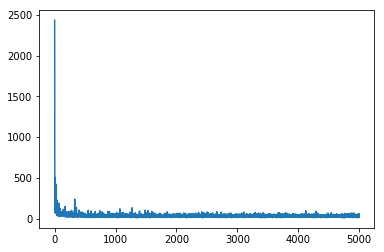

In [24]:
plt.figure()
plt.plot(losses_2)
plt.show()

## Training with embedding size = 8

In [25]:
epoch_range = 5000
batch_size = 150
learning_rate = 0.0001
embedding_size = 8

ae_3 = autoencoder(length, embedding_size).cuda()
ae_3.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_3.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_3 = train_ae(ae_3, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:1278.88440, avg:1278.88440
epoch [2/5000], loss:452.10565, avg:865.49500
epoch [3/5000], loss:263.94266, avg:664.97754
epoch [4/5000], loss:295.36685, avg:572.57489
epoch [5/5000], loss:66.22029, avg:471.30396
epoch [6/5000], loss:122.30157, avg:413.13690
epoch [7/5000], loss:124.17026, avg:371.85593
epoch [8/5000], loss:342.53638, avg:368.19098
epoch [9/5000], loss:111.78619, avg:339.70157
epoch [10/5000], loss:375.25085, avg:343.25650
epoch [11/5000], loss:147.80930, avg:230.14900
epoch [12/5000], loss:92.41294, avg:194.17973
epoch [13/5000], loss:95.31709, avg:177.31718
epoch [14/5000], loss:123.65975, avg:160.14648
epoch [15/5000], loss:273.46362, avg:180.87080
epoch [16/5000], loss:121.81629, avg:180.82228
epoch [17/5000], loss:172.94977, avg:185.70023
epoch [18/5000], loss:268.62985, avg:178.30957
epoch [19/5000], loss:306.93146, avg:197.82410
epoch [20/5000], loss:101.39432, avg:170.43843
epoch [21/5000], loss:94.27033, avg:165.08453
epoch [22/5000], loss:12

epoch [180/5000], loss:76.56972, avg:52.24471
epoch [181/5000], loss:46.85626, avg:51.44204
epoch [182/5000], loss:58.50131, avg:53.09056
epoch [183/5000], loss:49.07841, avg:53.60431
epoch [184/5000], loss:49.94348, avg:55.50389
epoch [185/5000], loss:51.19965, avg:50.88598
epoch [186/5000], loss:27.98884, avg:51.15478
epoch [187/5000], loss:86.40295, avg:53.76318
epoch [188/5000], loss:63.09208, avg:55.66148
epoch [189/5000], loss:63.15644, avg:57.27891
epoch [190/5000], loss:51.65913, avg:54.78785
epoch [191/5000], loss:90.54371, avg:59.15660
epoch [192/5000], loss:94.11046, avg:62.71752
epoch [193/5000], loss:41.22693, avg:61.93237
epoch [194/5000], loss:115.59892, avg:68.49792
epoch [195/5000], loss:72.58988, avg:70.63694
epoch [196/5000], loss:22.24843, avg:70.06289
epoch [197/5000], loss:47.01439, avg:66.12405
epoch [198/5000], loss:50.53346, avg:64.86818
epoch [199/5000], loss:65.74754, avg:65.12729
epoch [200/5000], loss:48.41994, avg:64.80337
epoch [201/5000], loss:56.93737, 

epoch [359/5000], loss:34.62759, avg:48.70518
epoch [360/5000], loss:31.20231, avg:48.36881
epoch [361/5000], loss:25.18267, avg:48.50566
epoch [362/5000], loss:55.06167, avg:49.58232
epoch [363/5000], loss:24.36786, avg:45.56927
epoch [364/5000], loss:28.44163, avg:43.19954
epoch [365/5000], loss:99.15989, avg:48.80252
epoch [366/5000], loss:46.37321, avg:49.55730
epoch [367/5000], loss:39.75587, avg:44.84053
epoch [368/5000], loss:41.29343, avg:42.54661
epoch [369/5000], loss:25.89919, avg:41.67377
epoch [370/5000], loss:50.80099, avg:43.63364
epoch [371/5000], loss:46.11140, avg:45.72651
epoch [372/5000], loss:43.82265, avg:44.60261
epoch [373/5000], loss:40.07919, avg:46.17375
epoch [374/5000], loss:48.06429, avg:48.13601
epoch [375/5000], loss:64.47394, avg:44.66742
epoch [376/5000], loss:72.92823, avg:47.32292
epoch [377/5000], loss:51.21221, avg:48.46856
epoch [378/5000], loss:58.90807, avg:50.23002
epoch [379/5000], loss:62.27548, avg:53.86765
epoch [380/5000], loss:51.95955, a

epoch [538/5000], loss:40.48938, avg:34.56602
epoch [539/5000], loss:30.95178, avg:35.39922
epoch [540/5000], loss:36.54363, avg:36.79292
epoch [541/5000], loss:37.19291, avg:37.16818
epoch [542/5000], loss:93.43756, avg:39.78088
epoch [543/5000], loss:19.54231, avg:39.10357
epoch [544/5000], loss:27.56418, avg:39.76256
epoch [545/5000], loss:29.52674, avg:37.87702
epoch [546/5000], loss:39.02282, avg:38.69127
epoch [547/5000], loss:36.25845, avg:39.05298
epoch [548/5000], loss:34.24739, avg:38.42878
epoch [549/5000], loss:56.18212, avg:40.95181
epoch [550/5000], loss:44.61328, avg:41.75878
epoch [551/5000], loss:57.01614, avg:43.74110
epoch [552/5000], loss:30.51777, avg:37.44912
epoch [553/5000], loss:25.01889, avg:37.99678
epoch [554/5000], loss:41.46095, avg:39.38646
epoch [555/5000], loss:34.13888, avg:39.84767
epoch [556/5000], loss:32.40882, avg:39.18627
epoch [557/5000], loss:22.35999, avg:37.79642
epoch [558/5000], loss:53.65483, avg:39.73717
epoch [559/5000], loss:29.63275, a

epoch [717/5000], loss:29.18612, avg:40.62055
epoch [718/5000], loss:27.87722, avg:34.35913
epoch [719/5000], loss:41.67591, avg:35.58412
epoch [720/5000], loss:26.52613, avg:34.30086
epoch [721/5000], loss:37.04105, avg:35.90438
epoch [722/5000], loss:23.00381, avg:33.56074
epoch [723/5000], loss:65.21397, avg:34.46218
epoch [724/5000], loss:16.90276, avg:34.17186
epoch [725/5000], loss:32.36292, avg:35.52264
epoch [726/5000], loss:91.16999, avg:39.09599
epoch [727/5000], loss:50.14347, avg:41.19172
epoch [728/5000], loss:58.63562, avg:44.26756
epoch [729/5000], loss:38.82824, avg:43.98280
epoch [730/5000], loss:33.96769, avg:44.72695
epoch [731/5000], loss:35.65718, avg:44.58856
epoch [732/5000], loss:20.27789, avg:44.31597
epoch [733/5000], loss:35.65123, avg:41.35970
epoch [734/5000], loss:29.10246, avg:42.57967
epoch [735/5000], loss:38.92713, avg:43.23609
epoch [736/5000], loss:24.76435, avg:36.59553
epoch [737/5000], loss:63.04565, avg:37.88575
epoch [738/5000], loss:51.42781, a

epoch [896/5000], loss:22.96610, avg:33.10899
epoch [897/5000], loss:76.20425, avg:38.10918
epoch [898/5000], loss:44.43535, avg:37.73801
epoch [899/5000], loss:39.29645, avg:38.82548
epoch [900/5000], loss:15.26659, avg:37.11771
epoch [901/5000], loss:34.52631, avg:38.28741
epoch [902/5000], loss:35.09113, avg:39.25015
epoch [903/5000], loss:28.96820, avg:37.89155
epoch [904/5000], loss:44.01770, avg:38.82652
epoch [905/5000], loss:39.84237, avg:38.06145
epoch [906/5000], loss:40.85539, avg:39.85037
epoch [907/5000], loss:50.05527, avg:37.23548
epoch [908/5000], loss:44.35160, avg:37.22710
epoch [909/5000], loss:27.86401, avg:36.08386
epoch [910/5000], loss:51.45591, avg:39.70279
epoch [911/5000], loss:37.91304, avg:40.04146
epoch [912/5000], loss:23.64568, avg:38.89692
epoch [913/5000], loss:47.42527, avg:40.74263
epoch [914/5000], loss:39.23297, avg:40.26415
epoch [915/5000], loss:63.30339, avg:42.61025
epoch [916/5000], loss:45.39481, avg:43.06419
epoch [917/5000], loss:29.99124, a

epoch [1073/5000], loss:38.91767, avg:32.72507
epoch [1074/5000], loss:22.36869, avg:32.12778
epoch [1075/5000], loss:83.48604, avg:37.18568
epoch [1076/5000], loss:41.73331, avg:38.66067
epoch [1077/5000], loss:52.81020, avg:40.49745
epoch [1078/5000], loss:41.23821, avg:41.94427
epoch [1079/5000], loss:22.63266, avg:42.17360
epoch [1080/5000], loss:52.67969, avg:42.49437
epoch [1081/5000], loss:29.73047, avg:41.96526
epoch [1082/5000], loss:36.31371, avg:42.19107
epoch [1083/5000], loss:28.37178, avg:41.13647
epoch [1084/5000], loss:29.57392, avg:41.85699
epoch [1085/5000], loss:25.03951, avg:36.01234
epoch [1086/5000], loss:43.17863, avg:36.15688
epoch [1087/5000], loss:28.00588, avg:33.67645
epoch [1088/5000], loss:32.36253, avg:32.78888
epoch [1089/5000], loss:49.95049, avg:35.52066
epoch [1090/5000], loss:19.95345, avg:32.24804
epoch [1091/5000], loss:71.68141, avg:36.44313
epoch [1092/5000], loss:37.79202, avg:36.59097
epoch [1093/5000], loss:41.57181, avg:37.91096
epoch [1094/5

epoch [1248/5000], loss:57.29543, avg:45.36282
epoch [1249/5000], loss:17.06108, avg:43.26646
epoch [1250/5000], loss:35.26263, avg:42.55051
epoch [1251/5000], loss:37.75442, avg:40.96487
epoch [1252/5000], loss:62.70218, avg:44.22145
epoch [1253/5000], loss:41.93408, avg:44.98977
epoch [1254/5000], loss:26.34840, avg:44.30149
epoch [1255/5000], loss:51.52893, avg:44.10588
epoch [1256/5000], loss:29.52976, avg:41.41562
epoch [1257/5000], loss:19.18155, avg:37.85984
epoch [1258/5000], loss:33.40520, avg:35.47083
epoch [1259/5000], loss:33.96359, avg:37.16108
epoch [1260/5000], loss:98.45073, avg:43.47989
epoch [1261/5000], loss:40.27728, avg:43.73217
epoch [1262/5000], loss:56.25896, avg:43.08785
epoch [1263/5000], loss:45.41010, avg:43.43545
epoch [1264/5000], loss:56.23915, avg:46.42453
epoch [1265/5000], loss:28.90277, avg:44.16191
epoch [1266/5000], loss:20.78452, avg:43.28738
epoch [1267/5000], loss:27.13265, avg:44.08250
epoch [1268/5000], loss:21.38386, avg:42.88036
epoch [1269/5

epoch [1423/5000], loss:41.29109, avg:38.79712
epoch [1424/5000], loss:34.90543, avg:39.86695
epoch [1425/5000], loss:47.23478, avg:41.04248
epoch [1426/5000], loss:25.70881, avg:40.97628
epoch [1427/5000], loss:101.08510, avg:47.51240
epoch [1428/5000], loss:50.93921, avg:45.97459
epoch [1429/5000], loss:51.54187, avg:45.73705
epoch [1430/5000], loss:112.31299, avg:52.99457
epoch [1431/5000], loss:25.51936, avg:50.77814
epoch [1432/5000], loss:45.75541, avg:53.62941
epoch [1433/5000], loss:37.41706, avg:53.24200
epoch [1434/5000], loss:50.03449, avg:54.75491
epoch [1435/5000], loss:23.85899, avg:52.41733
epoch [1436/5000], loss:54.41787, avg:55.28823
epoch [1437/5000], loss:47.92702, avg:49.97243
epoch [1438/5000], loss:40.72341, avg:48.95085
epoch [1439/5000], loss:42.80706, avg:48.07737
epoch [1440/5000], loss:48.11285, avg:41.65736
epoch [1441/5000], loss:42.10270, avg:43.31569
epoch [1442/5000], loss:74.21742, avg:46.16189
epoch [1443/5000], loss:43.06128, avg:46.72631
epoch [1444

epoch [1598/5000], loss:22.45049, avg:32.40229
epoch [1599/5000], loss:33.19506, avg:30.44238
epoch [1600/5000], loss:23.08354, avg:30.64043
epoch [1601/5000], loss:33.57256, avg:31.33504
epoch [1602/5000], loss:82.96619, avg:37.45147
epoch [1603/5000], loss:18.39082, avg:35.16043
epoch [1604/5000], loss:31.76637, avg:34.23771
epoch [1605/5000], loss:56.31622, avg:35.56012
epoch [1606/5000], loss:39.10992, avg:35.70953
epoch [1607/5000], loss:46.92081, avg:38.77720
epoch [1608/5000], loss:26.07520, avg:39.13967
epoch [1609/5000], loss:25.60795, avg:38.38096
epoch [1610/5000], loss:33.28082, avg:39.40069
epoch [1611/5000], loss:57.16596, avg:41.76003
epoch [1612/5000], loss:21.81754, avg:35.64516
epoch [1613/5000], loss:29.00323, avg:36.70640
epoch [1614/5000], loss:64.09746, avg:39.93951
epoch [1615/5000], loss:35.30929, avg:37.83882
epoch [1616/5000], loss:70.00902, avg:40.92873
epoch [1617/5000], loss:49.06396, avg:41.14304
epoch [1618/5000], loss:56.73112, avg:44.20864
epoch [1619/5

epoch [1773/5000], loss:76.15285, avg:45.96001
epoch [1774/5000], loss:50.07145, avg:47.87337
epoch [1775/5000], loss:89.72373, avg:53.57034
epoch [1776/5000], loss:57.22316, avg:51.13029
epoch [1777/5000], loss:35.87603, avg:51.70446
epoch [1778/5000], loss:36.52571, avg:52.83078
epoch [1779/5000], loss:21.27356, avg:50.53772
epoch [1780/5000], loss:32.05201, avg:48.71461
epoch [1781/5000], loss:54.41210, avg:50.35072
epoch [1782/5000], loss:43.44476, avg:49.67554
epoch [1783/5000], loss:24.50100, avg:44.51036
epoch [1784/5000], loss:29.42680, avg:42.44589
epoch [1785/5000], loss:40.82918, avg:37.55643
epoch [1786/5000], loss:32.02065, avg:35.03619
epoch [1787/5000], loss:28.59475, avg:34.30806
epoch [1788/5000], loss:49.18797, avg:35.57428
epoch [1789/5000], loss:22.53707, avg:35.70063
epoch [1790/5000], loss:29.80628, avg:35.47606
epoch [1791/5000], loss:36.33857, avg:33.66870
epoch [1792/5000], loss:25.45781, avg:31.87001
epoch [1793/5000], loss:39.45567, avg:33.36547
epoch [1794/5

epoch [1948/5000], loss:27.30821, avg:33.48445
epoch [1949/5000], loss:96.15788, avg:39.33905
epoch [1950/5000], loss:24.08621, avg:37.70847
epoch [1951/5000], loss:55.74475, avg:39.70169
epoch [1952/5000], loss:64.29440, avg:43.38071
epoch [1953/5000], loss:50.38482, avg:44.02128
epoch [1954/5000], loss:39.52837, avg:44.80463
epoch [1955/5000], loss:47.48043, avg:46.38294
epoch [1956/5000], loss:32.41857, avg:45.72316
epoch [1957/5000], loss:44.29289, avg:48.16965
epoch [1958/5000], loss:15.48670, avg:46.98751
epoch [1959/5000], loss:19.91436, avg:39.36316
epoch [1960/5000], loss:74.97238, avg:44.45177
epoch [1961/5000], loss:40.32852, avg:42.91014
epoch [1962/5000], loss:54.41220, avg:41.92192
epoch [1963/5000], loss:29.42123, avg:39.82557
epoch [1964/5000], loss:68.37498, avg:42.71023
epoch [1965/5000], loss:38.94938, avg:41.85712
epoch [1966/5000], loss:19.74429, avg:40.58969
epoch [1967/5000], loss:23.11615, avg:38.47202
epoch [1968/5000], loss:49.84151, avg:41.90750
epoch [1969/5

epoch [2123/5000], loss:36.54277, avg:42.36116
epoch [2124/5000], loss:50.49665, avg:43.73230
epoch [2125/5000], loss:41.16501, avg:45.49651
epoch [2126/5000], loss:29.72431, avg:46.96085
epoch [2127/5000], loss:31.58378, avg:46.64463
epoch [2128/5000], loss:18.67142, avg:37.30817
epoch [2129/5000], loss:49.05935, avg:36.48668
epoch [2130/5000], loss:35.91211, avg:35.55502
epoch [2131/5000], loss:29.71786, avg:35.89532
epoch [2132/5000], loss:40.17416, avg:36.30474
epoch [2133/5000], loss:21.53922, avg:34.80439
epoch [2134/5000], loss:37.24520, avg:33.47924
epoch [2135/5000], loss:67.05960, avg:36.06870
epoch [2136/5000], loss:64.57674, avg:39.55394
epoch [2137/5000], loss:33.66981, avg:39.76255
epoch [2138/5000], loss:45.04808, avg:42.40022
epoch [2139/5000], loss:48.24780, avg:42.31906
epoch [2140/5000], loss:81.39326, avg:46.86718
epoch [2141/5000], loss:21.54695, avg:46.05009
epoch [2142/5000], loss:27.86625, avg:44.81929
epoch [2143/5000], loss:44.40408, avg:47.10577
epoch [2144/5

epoch [2298/5000], loss:47.19352, avg:37.29552
epoch [2299/5000], loss:38.16150, avg:37.37913
epoch [2300/5000], loss:76.34936, avg:43.71841
epoch [2301/5000], loss:56.10899, avg:45.62340
epoch [2302/5000], loss:24.33582, avg:44.85291
epoch [2303/5000], loss:50.08911, avg:46.71389
epoch [2304/5000], loss:29.79359, avg:47.51405
epoch [2305/5000], loss:30.37061, avg:44.95671
epoch [2306/5000], loss:28.93067, avg:42.36572
epoch [2307/5000], loss:42.42785, avg:42.37610
epoch [2308/5000], loss:44.33363, avg:42.09011
epoch [2309/5000], loss:86.15295, avg:46.88926
epoch [2310/5000], loss:42.70306, avg:43.52463
epoch [2311/5000], loss:42.84925, avg:42.19865
epoch [2312/5000], loss:61.58281, avg:45.92335
epoch [2313/5000], loss:21.88255, avg:43.10270
epoch [2314/5000], loss:37.15343, avg:43.83868
epoch [2315/5000], loss:41.57290, avg:44.95892
epoch [2316/5000], loss:49.43074, avg:47.00892
epoch [2317/5000], loss:67.29886, avg:49.49603
epoch [2318/5000], loss:38.11372, avg:48.87403
epoch [2319/5

epoch [2473/5000], loss:12.83408, avg:31.75995
epoch [2474/5000], loss:30.79424, avg:32.91573
epoch [2475/5000], loss:34.23471, avg:31.85142
epoch [2476/5000], loss:29.10666, avg:31.16933
epoch [2477/5000], loss:26.30410, avg:30.96593
epoch [2478/5000], loss:56.60974, avg:31.73303
epoch [2479/5000], loss:18.45093, avg:30.82261
epoch [2480/5000], loss:42.80978, avg:31.70020
epoch [2481/5000], loss:44.36379, avg:34.05547
epoch [2482/5000], loss:52.17168, avg:34.76797
epoch [2483/5000], loss:53.19893, avg:38.80446
epoch [2484/5000], loss:24.43959, avg:38.16899
epoch [2485/5000], loss:30.72706, avg:37.81823
epoch [2486/5000], loss:20.77482, avg:36.98504
epoch [2487/5000], loss:65.38818, avg:40.89345
epoch [2488/5000], loss:27.67646, avg:38.00012
epoch [2489/5000], loss:26.04252, avg:38.75928
epoch [2490/5000], loss:79.53693, avg:42.43200
epoch [2491/5000], loss:38.46248, avg:41.84187
epoch [2492/5000], loss:90.25846, avg:45.65054
epoch [2493/5000], loss:43.74171, avg:44.70482
epoch [2494/5

epoch [2648/5000], loss:25.54580, avg:42.81301
epoch [2649/5000], loss:44.82937, avg:44.25137
epoch [2650/5000], loss:74.19271, avg:47.53055
epoch [2651/5000], loss:22.39475, avg:39.79781
epoch [2652/5000], loss:21.51322, avg:34.28860
epoch [2653/5000], loss:45.50851, avg:36.19105
epoch [2654/5000], loss:67.77919, avg:40.50446
epoch [2655/5000], loss:19.88398, avg:39.51630
epoch [2656/5000], loss:28.29064, avg:37.90705
epoch [2657/5000], loss:19.89852, avg:36.98367
epoch [2658/5000], loss:33.32743, avg:37.76184
epoch [2659/5000], loss:32.69841, avg:36.54874
epoch [2660/5000], loss:37.71589, avg:32.90105
epoch [2661/5000], loss:39.69983, avg:34.63157
epoch [2662/5000], loss:29.21579, avg:35.40182
epoch [2663/5000], loss:34.23558, avg:34.27453
epoch [2664/5000], loss:22.24765, avg:29.72137
epoch [2665/5000], loss:22.91485, avg:30.02446
epoch [2666/5000], loss:49.17279, avg:32.11267
epoch [2667/5000], loss:57.21795, avg:35.84462
epoch [2668/5000], loss:35.77746, avg:36.08962
epoch [2669/5

epoch [2823/5000], loss:38.71794, avg:39.11356
epoch [2824/5000], loss:21.33513, avg:37.53283
epoch [2825/5000], loss:50.35006, avg:38.47238
epoch [2826/5000], loss:19.40760, avg:33.29164
epoch [2827/5000], loss:44.62631, avg:34.50676
epoch [2828/5000], loss:38.66271, avg:34.89453
epoch [2829/5000], loss:26.82424, avg:33.87662
epoch [2830/5000], loss:32.57790, avg:34.21136
epoch [2831/5000], loss:60.76710, avg:36.35627
epoch [2832/5000], loss:40.88670, avg:37.41557
epoch [2833/5000], loss:77.08150, avg:41.25192
epoch [2834/5000], loss:45.20994, avg:43.63941
epoch [2835/5000], loss:24.81142, avg:41.08554
epoch [2836/5000], loss:39.07390, avg:43.05217
epoch [2837/5000], loss:45.11537, avg:43.10108
epoch [2838/5000], loss:34.16021, avg:42.65083
epoch [2839/5000], loss:48.88403, avg:44.85681
epoch [2840/5000], loss:27.93844, avg:44.39286
epoch [2841/5000], loss:62.36724, avg:44.55288
epoch [2842/5000], loss:67.12937, avg:47.17714
epoch [2843/5000], loss:31.75917, avg:42.64491
epoch [2844/5

epoch [2998/5000], loss:32.94479, avg:35.49430
epoch [2999/5000], loss:50.68282, avg:37.14675
epoch [3000/5000], loss:28.53747, avg:35.87581
epoch [3001/5000], loss:47.40533, avg:36.95332
epoch [3002/5000], loss:48.82394, avg:39.54241
epoch [3003/5000], loss:29.25298, avg:38.05104
epoch [3004/5000], loss:50.59152, avg:39.43787
epoch [3005/5000], loss:49.50306, avg:40.94783
epoch [3006/5000], loss:29.81784, avg:39.90941
epoch [3007/5000], loss:25.63675, avg:39.31965
epoch [3008/5000], loss:41.46097, avg:40.17127
epoch [3009/5000], loss:24.44174, avg:37.54716
epoch [3010/5000], loss:48.90082, avg:39.58349
epoch [3011/5000], loss:50.88824, avg:39.93179
epoch [3012/5000], loss:25.87570, avg:37.63696
epoch [3013/5000], loss:29.29375, avg:37.64104
epoch [3014/5000], loss:25.42169, avg:35.12406
epoch [3015/5000], loss:41.31276, avg:34.30503
epoch [3016/5000], loss:37.57099, avg:35.08034
epoch [3017/5000], loss:35.85055, avg:36.10172
epoch [3018/5000], loss:29.39421, avg:34.89505
epoch [3019/5

epoch [3173/5000], loss:39.18950, avg:48.12305
epoch [3174/5000], loss:28.85681, avg:46.65977
epoch [3175/5000], loss:21.21625, avg:44.21126
epoch [3176/5000], loss:54.66312, avg:44.29639
epoch [3177/5000], loss:34.18501, avg:41.26045
epoch [3178/5000], loss:21.49536, avg:36.71988
epoch [3179/5000], loss:33.40036, avg:35.23917
epoch [3180/5000], loss:54.02061, avg:33.95925
epoch [3181/5000], loss:36.76555, avg:34.70459
epoch [3182/5000], loss:23.56422, avg:34.73568
epoch [3183/5000], loss:41.85308, avg:35.00204
epoch [3184/5000], loss:23.38600, avg:34.45496
epoch [3185/5000], loss:40.25528, avg:36.35886
epoch [3186/5000], loss:17.90279, avg:32.68283
epoch [3187/5000], loss:39.69466, avg:33.23379
epoch [3188/5000], loss:38.55015, avg:34.93927
epoch [3189/5000], loss:27.44754, avg:34.34399
epoch [3190/5000], loss:33.45192, avg:32.28712
epoch [3191/5000], loss:37.11909, avg:32.32248
epoch [3192/5000], loss:15.65928, avg:31.53198
epoch [3193/5000], loss:60.01006, avg:33.34768
epoch [3194/5

epoch [3348/5000], loss:22.81951, avg:36.31053
epoch [3349/5000], loss:24.41180, avg:36.18535
epoch [3350/5000], loss:40.76472, avg:36.91835
epoch [3351/5000], loss:43.36467, avg:38.42903
epoch [3352/5000], loss:23.05986, avg:33.10284
epoch [3353/5000], loss:37.24792, avg:33.20853
epoch [3354/5000], loss:32.84833, avg:33.78697
epoch [3355/5000], loss:50.47614, avg:35.37003
epoch [3356/5000], loss:17.54385, avg:33.01971
epoch [3357/5000], loss:31.70524, avg:32.42421
epoch [3358/5000], loss:28.78784, avg:33.02104
epoch [3359/5000], loss:37.14152, avg:34.29401
epoch [3360/5000], loss:38.44878, avg:34.06242
epoch [3361/5000], loss:37.68680, avg:33.49463
epoch [3362/5000], loss:26.21051, avg:33.80970
epoch [3363/5000], loss:18.54622, avg:31.93953
epoch [3364/5000], loss:53.43181, avg:33.99788
epoch [3365/5000], loss:34.72815, avg:32.42307
epoch [3366/5000], loss:45.96572, avg:35.26526
epoch [3367/5000], loss:27.98931, avg:34.89367
epoch [3368/5000], loss:33.59131, avg:35.37402
epoch [3369/5

epoch [3523/5000], loss:20.86970, avg:35.39901
epoch [3524/5000], loss:66.46006, avg:36.68739
epoch [3525/5000], loss:53.75233, avg:39.28602
epoch [3526/5000], loss:48.88781, avg:41.43482
epoch [3527/5000], loss:32.32406, avg:42.20067
epoch [3528/5000], loss:48.16796, avg:43.99565
epoch [3529/5000], loss:35.95096, avg:42.87626
epoch [3530/5000], loss:22.73707, avg:41.30459
epoch [3531/5000], loss:98.70267, avg:46.25592
epoch [3532/5000], loss:29.06342, avg:45.69160
epoch [3533/5000], loss:36.72029, avg:47.27666
epoch [3534/5000], loss:31.76688, avg:43.80734
epoch [3535/5000], loss:27.65998, avg:41.19811
epoch [3536/5000], loss:30.26095, avg:39.33542
epoch [3537/5000], loss:54.33684, avg:41.53670
epoch [3538/5000], loss:37.22093, avg:40.44200
epoch [3539/5000], loss:24.41857, avg:39.28876
epoch [3540/5000], loss:30.69112, avg:40.08417
epoch [3541/5000], loss:27.69285, avg:32.98318
epoch [3542/5000], loss:23.89940, avg:32.46678
epoch [3543/5000], loss:21.57953, avg:30.95270
epoch [3544/5

epoch [3698/5000], loss:37.28783, avg:32.91579
epoch [3699/5000], loss:34.32904, avg:31.19512
epoch [3700/5000], loss:23.78367, avg:30.15327
epoch [3701/5000], loss:44.82034, avg:32.11320
epoch [3702/5000], loss:23.89726, avg:31.28236
epoch [3703/5000], loss:27.33285, avg:29.79658
epoch [3704/5000], loss:19.37258, avg:29.57542
epoch [3705/5000], loss:49.02885, avg:31.63981
epoch [3706/5000], loss:33.19416, avg:31.85791
epoch [3707/5000], loss:91.58807, avg:38.46347
epoch [3708/5000], loss:37.36675, avg:38.47136
epoch [3709/5000], loss:41.13216, avg:39.15168
epoch [3710/5000], loss:25.62328, avg:39.33564
epoch [3711/5000], loss:61.41004, avg:40.99461
epoch [3712/5000], loss:103.65448, avg:48.97033
epoch [3713/5000], loss:63.59390, avg:52.59643
epoch [3714/5000], loss:48.11229, avg:55.47040
epoch [3715/5000], loss:41.27000, avg:54.69452
epoch [3716/5000], loss:34.63659, avg:54.83876
epoch [3717/5000], loss:21.17713, avg:47.79766
epoch [3718/5000], loss:56.71862, avg:49.73285
epoch [3719/

epoch [3873/5000], loss:49.63327, avg:38.51434
epoch [3874/5000], loss:50.17313, avg:40.77952
epoch [3875/5000], loss:30.44446, avg:39.76353
epoch [3876/5000], loss:49.32524, avg:40.25022
epoch [3877/5000], loss:39.51783, avg:39.87629
epoch [3878/5000], loss:41.64059, avg:38.37478
epoch [3879/5000], loss:35.27991, avg:39.19939
epoch [3880/5000], loss:86.29752, avg:45.73997
epoch [3881/5000], loss:22.35311, avg:43.55492
epoch [3882/5000], loss:33.80501, avg:43.84701
epoch [3883/5000], loss:33.05606, avg:42.18929
epoch [3884/5000], loss:33.79419, avg:40.55140
epoch [3885/5000], loss:15.81439, avg:39.08839
epoch [3886/5000], loss:42.48873, avg:38.40474
epoch [3887/5000], loss:44.06926, avg:38.85987
epoch [3888/5000], loss:30.23047, avg:37.71887
epoch [3889/5000], loss:35.54454, avg:37.74533
epoch [3890/5000], loss:47.19152, avg:33.83473
epoch [3891/5000], loss:50.15708, avg:36.61512
epoch [3892/5000], loss:49.71586, avg:38.20621
epoch [3893/5000], loss:28.27287, avg:37.72789
epoch [3894/5

epoch [4048/5000], loss:42.69688, avg:41.51953
epoch [4049/5000], loss:24.74321, avg:40.21167
epoch [4050/5000], loss:27.84290, avg:34.65543
epoch [4051/5000], loss:23.73224, avg:34.95744
epoch [4052/5000], loss:48.09774, avg:34.99067
epoch [4053/5000], loss:42.67948, avg:37.04219
epoch [4054/5000], loss:38.90141, avg:35.86372
epoch [4055/5000], loss:23.25108, avg:33.32943
epoch [4056/5000], loss:30.97592, avg:31.90123
epoch [4057/5000], loss:34.14769, avg:33.70686
epoch [4058/5000], loss:32.61626, avg:32.69880
epoch [4059/5000], loss:26.42624, avg:32.86710
epoch [4060/5000], loss:24.28146, avg:32.51095
epoch [4061/5000], loss:28.55317, avg:32.99305
epoch [4062/5000], loss:41.95724, avg:32.37899
epoch [4063/5000], loss:69.88048, avg:35.09910
epoch [4064/5000], loss:57.19254, avg:36.92821
epoch [4065/5000], loss:53.66361, avg:39.96946
epoch [4066/5000], loss:56.86323, avg:42.55819
epoch [4067/5000], loss:24.64373, avg:41.60780
epoch [4068/5000], loss:50.20446, avg:43.36662
epoch [4069/5

epoch [4223/5000], loss:16.90721, avg:35.45379
epoch [4224/5000], loss:34.00349, avg:35.72335
epoch [4225/5000], loss:46.07580, avg:36.52596
epoch [4226/5000], loss:50.37459, avg:37.11445
epoch [4227/5000], loss:46.63152, avg:35.55941
epoch [4228/5000], loss:32.64590, avg:37.09149
epoch [4229/5000], loss:68.24625, avg:41.33552
epoch [4230/5000], loss:57.01219, avg:44.33138
epoch [4231/5000], loss:48.87894, avg:43.06550
epoch [4232/5000], loss:26.80873, avg:42.75846
epoch [4233/5000], loss:17.60536, avg:42.82828
epoch [4234/5000], loss:28.72211, avg:42.30014
epoch [4235/5000], loss:41.90199, avg:41.88276
epoch [4236/5000], loss:81.65754, avg:45.01105
epoch [4237/5000], loss:114.33891, avg:51.78179
epoch [4238/5000], loss:30.52475, avg:51.56968
epoch [4239/5000], loss:35.26801, avg:48.27185
epoch [4240/5000], loss:31.08207, avg:45.67884
epoch [4241/5000], loss:28.15481, avg:43.60643
epoch [4242/5000], loss:26.04261, avg:43.52981
epoch [4243/5000], loss:57.79992, avg:47.54927
epoch [4244/

epoch [4398/5000], loss:51.34412, avg:47.41416
epoch [4399/5000], loss:43.57520, avg:45.68658
epoch [4400/5000], loss:34.76907, avg:45.41639
epoch [4401/5000], loss:56.64427, avg:44.91009
epoch [4402/5000], loss:47.61545, avg:43.11645
epoch [4403/5000], loss:40.95041, avg:42.76800
epoch [4404/5000], loss:72.77779, avg:46.24334
epoch [4405/5000], loss:26.18216, avg:44.60588
epoch [4406/5000], loss:26.24886, avg:44.48530
epoch [4407/5000], loss:34.03655, avg:43.41439
epoch [4408/5000], loss:22.62809, avg:40.54279
epoch [4409/5000], loss:81.97156, avg:44.38242
epoch [4410/5000], loss:31.20329, avg:44.02584
epoch [4411/5000], loss:45.90042, avg:42.95146
epoch [4412/5000], loss:35.45496, avg:41.73541
epoch [4413/5000], loss:37.96164, avg:41.43653
epoch [4414/5000], loss:46.97731, avg:38.85648
epoch [4415/5000], loss:37.40332, avg:39.97860
epoch [4416/5000], loss:30.18700, avg:40.37242
epoch [4417/5000], loss:34.19781, avg:40.38855
epoch [4418/5000], loss:16.13022, avg:39.73875
epoch [4419/5

epoch [4573/5000], loss:48.10858, avg:36.78360
epoch [4574/5000], loss:60.71122, avg:38.99070
epoch [4575/5000], loss:62.59339, avg:40.55122
epoch [4576/5000], loss:35.34427, avg:40.56198
epoch [4577/5000], loss:54.36557, avg:42.52006
epoch [4578/5000], loss:45.95425, avg:45.63733
epoch [4579/5000], loss:23.29218, avg:43.00142
epoch [4580/5000], loss:33.36435, avg:44.38396
epoch [4581/5000], loss:61.86449, avg:47.81301
epoch [4582/5000], loss:34.12727, avg:45.97255
epoch [4583/5000], loss:30.15598, avg:44.17729
epoch [4584/5000], loss:53.60684, avg:43.46686
epoch [4585/5000], loss:55.89943, avg:42.79746
epoch [4586/5000], loss:37.09405, avg:42.97244
epoch [4587/5000], loss:40.71410, avg:41.60730
epoch [4588/5000], loss:29.55599, avg:39.96747
epoch [4589/5000], loss:30.28562, avg:40.66682
epoch [4590/5000], loss:46.50490, avg:41.98087
epoch [4591/5000], loss:18.13184, avg:37.60760
epoch [4592/5000], loss:65.10946, avg:40.70582
epoch [4593/5000], loss:19.68226, avg:39.65845
epoch [4594/5

epoch [4748/5000], loss:29.25234, avg:35.01385
epoch [4749/5000], loss:39.47011, avg:35.59577
epoch [4750/5000], loss:35.91956, avg:34.91444
epoch [4751/5000], loss:31.18349, avg:32.89351
epoch [4752/5000], loss:17.50860, avg:31.84772
epoch [4753/5000], loss:38.06145, avg:32.29333
epoch [4754/5000], loss:88.08530, avg:37.79501
epoch [4755/5000], loss:52.35184, avg:37.88736
epoch [4756/5000], loss:34.29659, avg:39.56224
epoch [4757/5000], loss:39.49521, avg:40.56245
epoch [4758/5000], loss:26.35448, avg:40.27267
epoch [4759/5000], loss:32.23306, avg:39.54896
epoch [4760/5000], loss:62.16734, avg:42.17374
epoch [4761/5000], loss:36.81051, avg:42.73644
epoch [4762/5000], loss:41.53655, avg:45.13923
epoch [4763/5000], loss:22.29352, avg:43.56244
epoch [4764/5000], loss:47.42471, avg:39.49638
epoch [4765/5000], loss:65.34228, avg:40.79543
epoch [4766/5000], loss:31.07445, avg:40.47321
epoch [4767/5000], loss:38.53633, avg:40.37733
epoch [4768/5000], loss:17.74343, avg:39.51622
epoch [4769/5

epoch [4923/5000], loss:17.58726, avg:39.58687
epoch [4924/5000], loss:39.74717, avg:40.07762
epoch [4925/5000], loss:65.65238, avg:39.84694
epoch [4926/5000], loss:26.99128, avg:37.13214
epoch [4927/5000], loss:32.58878, avg:37.29701
epoch [4928/5000], loss:50.52173, avg:40.12189
epoch [4929/5000], loss:50.71770, avg:42.03748
epoch [4930/5000], loss:30.19282, avg:42.12663
epoch [4931/5000], loss:27.92161, avg:41.82318
epoch [4932/5000], loss:29.03144, avg:37.09521
epoch [4933/5000], loss:38.52643, avg:39.18913
epoch [4934/5000], loss:30.50040, avg:38.26445
epoch [4935/5000], loss:52.99379, avg:36.99859
epoch [4936/5000], loss:28.67863, avg:37.16733
epoch [4937/5000], loss:32.22692, avg:37.13115
epoch [4938/5000], loss:87.53209, avg:40.83218
epoch [4939/5000], loss:72.53697, avg:43.01411
epoch [4940/5000], loss:23.40017, avg:42.33484
epoch [4941/5000], loss:22.26475, avg:41.76916
epoch [4942/5000], loss:29.30502, avg:41.79652
epoch [4943/5000], loss:26.67066, avg:40.61094
epoch [4944/5

In [26]:
# torch.save(ae_3, 'models/visapy/ae_8.pt') #Saving the autoencoder model

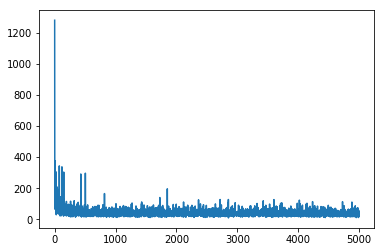

In [27]:
plt.figure()
plt.plot(losses_3)
plt.show()

## Training with embedding size = 6

In [28]:
epoch_range = 5000
batch_size = 150
learning_rate = 0.0001
embedding_size = 6

ae_4 = autoencoder(length, embedding_size).cuda()
ae_4.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_4.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_4 = train_ae(ae_4, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:1712.81555, avg:1712.81555
epoch [2/5000], loss:732.78632, avg:1222.80090
epoch [3/5000], loss:879.79065, avg:1108.46423
epoch [4/5000], loss:347.76392, avg:918.28912
epoch [5/5000], loss:288.84085, avg:792.39948
epoch [6/5000], loss:170.59651, avg:688.76562
epoch [7/5000], loss:154.64273, avg:612.46234
epoch [8/5000], loss:257.62784, avg:568.10803
epoch [9/5000], loss:799.22858, avg:593.78809
epoch [10/5000], loss:162.99669, avg:550.70892
epoch [11/5000], loss:81.22486, avg:387.54990
epoch [12/5000], loss:168.76819, avg:331.14804
epoch [13/5000], loss:74.17857, avg:250.58684
epoch [14/5000], loss:407.44287, avg:256.55478
epoch [15/5000], loss:369.30774, avg:264.60147
epoch [16/5000], loss:143.92354, avg:261.93417
epoch [17/5000], loss:577.61572, avg:304.23148
epoch [18/5000], loss:215.60397, avg:300.02908
epoch [19/5000], loss:332.49847, avg:253.35608
epoch [20/5000], loss:150.24930, avg:252.08133
epoch [21/5000], loss:148.53033, avg:258.81186
epoch [22/5000], los

epoch [180/5000], loss:69.51667, avg:60.73843
epoch [181/5000], loss:201.58804, avg:74.57713
epoch [182/5000], loss:78.21310, avg:76.82463
epoch [183/5000], loss:45.34237, avg:76.58627
epoch [184/5000], loss:60.97484, avg:75.53124
epoch [185/5000], loss:29.91392, avg:72.83828
epoch [186/5000], loss:75.55035, avg:74.61085
epoch [187/5000], loss:79.99059, avg:76.97806
epoch [188/5000], loss:62.72309, avg:78.10800
epoch [189/5000], loss:39.12465, avg:74.29375
epoch [190/5000], loss:37.92615, avg:71.13470
epoch [191/5000], loss:57.13610, avg:56.68951
epoch [192/5000], loss:38.13796, avg:52.68200
epoch [193/5000], loss:50.65058, avg:53.21283
epoch [194/5000], loss:71.77337, avg:54.29268
epoch [195/5000], loss:80.72115, avg:59.37339
epoch [196/5000], loss:54.30313, avg:57.24868
epoch [197/5000], loss:41.93435, avg:53.44305
epoch [198/5000], loss:81.89390, avg:55.36014
epoch [199/5000], loss:61.49125, avg:57.59680
epoch [200/5000], loss:58.33280, avg:59.63746
epoch [201/5000], loss:62.48128, 

epoch [358/5000], loss:73.11453, avg:56.96409
epoch [359/5000], loss:37.58465, avg:50.34249
epoch [360/5000], loss:31.04522, avg:45.55311
epoch [361/5000], loss:66.63499, avg:46.85278
epoch [362/5000], loss:127.26049, avg:56.95335
epoch [363/5000], loss:62.62659, avg:58.78820
epoch [364/5000], loss:85.30162, avg:64.25072
epoch [365/5000], loss:29.44345, avg:63.10901
epoch [366/5000], loss:43.07781, avg:62.02283
epoch [367/5000], loss:207.03668, avg:76.31261
epoch [368/5000], loss:37.00013, avg:72.70116
epoch [369/5000], loss:58.92711, avg:74.83541
epoch [370/5000], loss:47.49080, avg:76.47997
epoch [371/5000], loss:81.62307, avg:77.97878
epoch [372/5000], loss:109.77952, avg:76.23067
epoch [373/5000], loss:40.94963, avg:74.06299
epoch [374/5000], loss:27.36258, avg:68.26908
epoch [375/5000], loss:47.54433, avg:70.07917
epoch [376/5000], loss:65.87099, avg:72.35848
epoch [377/5000], loss:57.73666, avg:57.42848
epoch [378/5000], loss:48.94707, avg:58.62318
epoch [379/5000], loss:78.43130

epoch [536/5000], loss:42.45673, avg:47.06699
epoch [537/5000], loss:28.05778, avg:46.03080
epoch [538/5000], loss:69.14063, avg:49.42460
epoch [539/5000], loss:46.78058, avg:45.92831
epoch [540/5000], loss:54.18752, avg:44.36565
epoch [541/5000], loss:39.67969, avg:45.44263
epoch [542/5000], loss:46.55944, avg:45.45071
epoch [543/5000], loss:50.12330, avg:47.12169
epoch [544/5000], loss:37.68744, avg:45.76127
epoch [545/5000], loss:41.10233, avg:45.57755
epoch [546/5000], loss:85.01704, avg:49.83358
epoch [547/5000], loss:45.30710, avg:51.55851
epoch [548/5000], loss:38.24468, avg:48.46891
epoch [549/5000], loss:63.45856, avg:50.13671
epoch [550/5000], loss:44.08755, avg:49.12672
epoch [551/5000], loss:47.01886, avg:49.86063
epoch [552/5000], loss:45.22057, avg:49.72675
epoch [553/5000], loss:46.04320, avg:49.31873
epoch [554/5000], loss:53.10744, avg:50.86073
epoch [555/5000], loss:34.45617, avg:50.19612
epoch [556/5000], loss:62.93472, avg:47.98789
epoch [557/5000], loss:96.78336, a

epoch [715/5000], loss:82.76363, avg:60.13955
epoch [716/5000], loss:27.47853, avg:57.51335
epoch [717/5000], loss:86.82924, avg:60.59077
epoch [718/5000], loss:37.83984, avg:56.29107
epoch [719/5000], loss:30.27371, avg:55.82189
epoch [720/5000], loss:38.68356, avg:55.30915
epoch [721/5000], loss:79.81746, avg:51.36225
epoch [722/5000], loss:61.73266, avg:52.94471
epoch [723/5000], loss:48.01726, avg:53.63465
epoch [724/5000], loss:41.26728, avg:53.47032
epoch [725/5000], loss:54.94082, avg:50.68804
epoch [726/5000], loss:30.73954, avg:51.01414
epoch [727/5000], loss:16.59929, avg:43.99114
epoch [728/5000], loss:102.18371, avg:50.42553
epoch [729/5000], loss:17.75592, avg:49.17375
epoch [730/5000], loss:32.43586, avg:48.54898
epoch [731/5000], loss:34.85219, avg:44.05246
epoch [732/5000], loss:78.73239, avg:45.75243
epoch [733/5000], loss:74.16007, avg:48.36671
epoch [734/5000], loss:36.78207, avg:47.91819
epoch [735/5000], loss:23.75122, avg:44.79922
epoch [736/5000], loss:55.02614, 

epoch [893/5000], loss:49.29071, avg:47.35625
epoch [894/5000], loss:28.40686, avg:45.76164
epoch [895/5000], loss:30.51082, avg:44.97770
epoch [896/5000], loss:75.41831, avg:47.42257
epoch [897/5000], loss:111.57924, avg:54.65801
epoch [898/5000], loss:34.54541, avg:52.76834
epoch [899/5000], loss:45.69296, avg:52.30423
epoch [900/5000], loss:28.41986, avg:50.62413
epoch [901/5000], loss:42.23576, avg:48.14650
epoch [902/5000], loss:42.38370, avg:48.84836
epoch [903/5000], loss:38.16845, avg:47.73614
epoch [904/5000], loss:31.59202, avg:48.05465
epoch [905/5000], loss:54.82191, avg:50.48576
epoch [906/5000], loss:67.15011, avg:49.65895
epoch [907/5000], loss:40.99808, avg:42.60083
epoch [908/5000], loss:46.17780, avg:43.76406
epoch [909/5000], loss:110.92604, avg:50.28737
epoch [910/5000], loss:90.65625, avg:56.51101
epoch [911/5000], loss:57.27582, avg:58.01502
epoch [912/5000], loss:34.51105, avg:57.22775
epoch [913/5000], loss:33.71060, avg:56.78197
epoch [914/5000], loss:53.63399,

epoch [1070/5000], loss:43.64015, avg:43.68806
epoch [1071/5000], loss:33.67845, avg:41.95125
epoch [1072/5000], loss:33.62690, avg:41.53213
epoch [1073/5000], loss:41.55154, avg:40.07580
epoch [1074/5000], loss:35.35838, avg:39.43486
epoch [1075/5000], loss:245.32684, avg:62.03683
epoch [1076/5000], loss:68.32162, avg:64.98225
epoch [1077/5000], loss:67.20129, avg:65.12889
epoch [1078/5000], loss:54.21302, avg:68.83897
epoch [1079/5000], loss:75.92413, avg:69.88424
epoch [1080/5000], loss:35.62632, avg:69.08286
epoch [1081/5000], loss:72.08950, avg:72.92396
epoch [1082/5000], loss:40.82783, avg:73.64405
epoch [1083/5000], loss:83.60407, avg:77.84930
epoch [1084/5000], loss:78.96490, avg:82.20995
epoch [1085/5000], loss:40.86195, avg:61.76347
epoch [1086/5000], loss:35.61161, avg:58.49246
epoch [1087/5000], loss:39.37019, avg:55.70935
epoch [1088/5000], loss:46.29832, avg:54.91788
epoch [1089/5000], loss:70.89454, avg:54.41492
epoch [1090/5000], loss:34.61986, avg:54.31427
epoch [1091/

epoch [1245/5000], loss:52.86125, avg:64.10916
epoch [1246/5000], loss:47.51445, avg:62.67334
epoch [1247/5000], loss:36.40388, avg:53.84512
epoch [1248/5000], loss:77.47809, avg:54.19319
epoch [1249/5000], loss:43.61867, avg:54.23470
epoch [1250/5000], loss:39.74435, avg:53.93896
epoch [1251/5000], loss:35.25939, avg:50.19555
epoch [1252/5000], loss:36.30065, avg:49.01796
epoch [1253/5000], loss:75.81638, avg:49.65629
epoch [1254/5000], loss:19.12300, avg:46.41201
epoch [1255/5000], loss:45.91497, avg:45.71739
epoch [1256/5000], loss:34.07592, avg:44.37354
epoch [1257/5000], loss:57.18513, avg:46.45166
epoch [1258/5000], loss:49.17116, avg:43.62096
epoch [1259/5000], loss:38.72692, avg:43.13179
epoch [1260/5000], loss:28.89652, avg:42.04701
epoch [1261/5000], loss:50.38724, avg:43.55979
epoch [1262/5000], loss:32.76568, avg:43.20630
epoch [1263/5000], loss:42.91177, avg:39.91583
epoch [1264/5000], loss:70.60303, avg:45.06384
epoch [1265/5000], loss:43.95999, avg:44.86834
epoch [1266/5

epoch [1420/5000], loss:58.87136, avg:44.18206
epoch [1421/5000], loss:76.10403, avg:47.80569
epoch [1422/5000], loss:58.40709, avg:49.46218
epoch [1423/5000], loss:44.71147, avg:48.23658
epoch [1424/5000], loss:123.02670, avg:58.08382
epoch [1425/5000], loss:67.56532, avg:62.24479
epoch [1426/5000], loss:45.49506, avg:62.81559
epoch [1427/5000], loss:92.65783, avg:66.47957
epoch [1428/5000], loss:60.92691, avg:68.39928
epoch [1429/5000], loss:49.98184, avg:67.77477
epoch [1430/5000], loss:55.38816, avg:67.42645
epoch [1431/5000], loss:41.52854, avg:63.96890
epoch [1432/5000], loss:55.17727, avg:63.64591
epoch [1433/5000], loss:39.33775, avg:63.10854
epoch [1434/5000], loss:60.96216, avg:56.90209
epoch [1435/5000], loss:47.74814, avg:54.92036
epoch [1436/5000], loss:59.20761, avg:56.29162
epoch [1437/5000], loss:85.18482, avg:55.54432
epoch [1438/5000], loss:46.81669, avg:54.13330
epoch [1439/5000], loss:28.67184, avg:52.00230
epoch [1440/5000], loss:75.24338, avg:53.98782
epoch [1441/

epoch [1595/5000], loss:18.01836, avg:46.14352
epoch [1596/5000], loss:59.77091, avg:44.10049
epoch [1597/5000], loss:36.30818, avg:42.25214
epoch [1598/5000], loss:54.06890, avg:42.37115
epoch [1599/5000], loss:50.20466, avg:42.21771
epoch [1600/5000], loss:25.52246, avg:39.02763
epoch [1601/5000], loss:52.30463, avg:39.44024
epoch [1602/5000], loss:32.35525, avg:39.03115
epoch [1603/5000], loss:26.02476, avg:38.50202
epoch [1604/5000], loss:71.23975, avg:42.58179
epoch [1605/5000], loss:32.07816, avg:43.98777
epoch [1606/5000], loss:46.19060, avg:42.62974
epoch [1607/5000], loss:30.22120, avg:42.02103
epoch [1608/5000], loss:72.26539, avg:43.84069
epoch [1609/5000], loss:65.39953, avg:45.36017
epoch [1610/5000], loss:54.79736, avg:48.28767
epoch [1611/5000], loss:37.78951, avg:46.83615
epoch [1612/5000], loss:35.64614, avg:47.16525
epoch [1613/5000], loss:47.10288, avg:49.27305
epoch [1614/5000], loss:49.59763, avg:47.10884
epoch [1615/5000], loss:48.29289, avg:48.73031
epoch [1616/5

epoch [1770/5000], loss:35.43215, avg:38.91431
epoch [1771/5000], loss:34.09824, avg:39.85676
epoch [1772/5000], loss:58.16670, avg:41.67385
epoch [1773/5000], loss:35.20574, avg:39.63987
epoch [1774/5000], loss:35.98150, avg:39.45549
epoch [1775/5000], loss:54.04388, avg:41.83924
epoch [1776/5000], loss:45.69161, avg:42.15117
epoch [1777/5000], loss:37.58868, avg:42.17747
epoch [1778/5000], loss:47.03631, avg:42.25731
epoch [1779/5000], loss:66.15033, avg:44.93952
epoch [1780/5000], loss:38.68077, avg:45.26438
epoch [1781/5000], loss:28.64830, avg:44.71938
epoch [1782/5000], loss:49.43161, avg:43.84587
epoch [1783/5000], loss:34.94646, avg:43.81995
epoch [1784/5000], loss:20.75257, avg:42.29705
epoch [1785/5000], loss:66.33022, avg:43.52569
epoch [1786/5000], loss:37.87479, avg:42.74401
epoch [1787/5000], loss:48.80014, avg:43.86515
epoch [1788/5000], loss:66.30096, avg:45.79162
epoch [1789/5000], loss:41.24631, avg:43.30122
epoch [1790/5000], loss:48.60003, avg:44.29314
epoch [1791/5

epoch [1945/5000], loss:48.40358, avg:44.01573
epoch [1946/5000], loss:48.79251, avg:42.85696
epoch [1947/5000], loss:30.65632, avg:41.19897
epoch [1948/5000], loss:64.84386, avg:43.13441
epoch [1949/5000], loss:62.14665, avg:46.60843
epoch [1950/5000], loss:44.96438, avg:48.19379
epoch [1951/5000], loss:51.91600, avg:50.43139
epoch [1952/5000], loss:39.43740, avg:49.31037
epoch [1953/5000], loss:28.22074, avg:45.89288
epoch [1954/5000], loss:59.90324, avg:47.92847
epoch [1955/5000], loss:83.36798, avg:51.42491
epoch [1956/5000], loss:49.00521, avg:51.44617
epoch [1957/5000], loss:52.19108, avg:53.59965
epoch [1958/5000], loss:67.28483, avg:53.84375
epoch [1959/5000], loss:44.53794, avg:52.08288
epoch [1960/5000], loss:57.82631, avg:53.36908
epoch [1961/5000], loss:35.08975, avg:51.68644
epoch [1962/5000], loss:61.30046, avg:53.87275
epoch [1963/5000], loss:38.05123, avg:54.85580
epoch [1964/5000], loss:74.55116, avg:56.32059
epoch [1965/5000], loss:45.43837, avg:52.52763
epoch [1966/5

epoch [2120/5000], loss:40.88982, avg:56.24521
epoch [2121/5000], loss:36.16558, avg:53.15338
epoch [2122/5000], loss:31.88845, avg:52.71808
epoch [2123/5000], loss:56.09985, avg:51.14891
epoch [2124/5000], loss:69.28406, avg:52.62254
epoch [2125/5000], loss:38.00179, avg:48.30149
epoch [2126/5000], loss:35.55889, avg:44.80743
epoch [2127/5000], loss:74.05819, avg:48.79530
epoch [2128/5000], loss:43.92142, avg:48.84843
epoch [2129/5000], loss:55.77821, avg:48.16463
epoch [2130/5000], loss:34.70241, avg:47.54589
epoch [2131/5000], loss:42.63755, avg:48.19308
epoch [2132/5000], loss:61.73890, avg:51.17812
epoch [2133/5000], loss:152.60973, avg:60.82911
epoch [2134/5000], loss:32.25039, avg:57.12574
epoch [2135/5000], loss:55.16104, avg:58.84167
epoch [2136/5000], loss:61.18021, avg:61.40381
epoch [2137/5000], loss:32.11174, avg:57.20916
epoch [2138/5000], loss:20.26841, avg:54.84386
epoch [2139/5000], loss:26.91542, avg:51.95758
epoch [2140/5000], loss:52.89306, avg:53.77665
epoch [2141/

epoch [2295/5000], loss:19.24648, avg:46.75499
epoch [2296/5000], loss:37.91525, avg:45.71644
epoch [2297/5000], loss:69.45370, avg:44.61584
epoch [2298/5000], loss:46.98285, avg:46.74095
epoch [2299/5000], loss:94.00717, avg:51.03947
epoch [2300/5000], loss:36.93380, avg:49.57729
epoch [2301/5000], loss:53.66362, avg:51.47068
epoch [2302/5000], loss:33.77251, avg:47.14466
epoch [2303/5000], loss:44.36700, avg:46.71174
epoch [2304/5000], loss:33.40276, avg:46.97451
epoch [2305/5000], loss:24.52123, avg:47.50199
epoch [2306/5000], loss:88.24760, avg:52.53523
epoch [2307/5000], loss:26.02930, avg:48.19279
epoch [2308/5000], loss:18.28302, avg:45.32280
epoch [2309/5000], loss:50.35062, avg:40.95715
epoch [2310/5000], loss:55.56699, avg:42.82047
epoch [2311/5000], loss:28.31334, avg:40.28544
epoch [2312/5000], loss:42.26925, avg:41.13511
epoch [2313/5000], loss:53.32412, avg:42.03083
epoch [2314/5000], loss:61.80728, avg:44.87128
epoch [2315/5000], loss:29.36274, avg:45.35543
epoch [2316/5

epoch [2470/5000], loss:36.96727, avg:49.83479
epoch [2471/5000], loss:55.87944, avg:51.72297
epoch [2472/5000], loss:61.89453, avg:55.45927
epoch [2473/5000], loss:45.64235, avg:55.21304
epoch [2474/5000], loss:28.44399, avg:51.77891
epoch [2475/5000], loss:38.85805, avg:48.36486
epoch [2476/5000], loss:32.56458, avg:44.59834
epoch [2477/5000], loss:89.86224, avg:46.36825
epoch [2478/5000], loss:30.52278, avg:47.28109
epoch [2479/5000], loss:48.24827, avg:46.88835
epoch [2480/5000], loss:106.18747, avg:53.81037
epoch [2481/5000], loss:38.68281, avg:52.09071
epoch [2482/5000], loss:54.70657, avg:51.37191
epoch [2483/5000], loss:28.41426, avg:49.64910
epoch [2484/5000], loss:31.36938, avg:49.94164
epoch [2485/5000], loss:50.73223, avg:51.12906
epoch [2486/5000], loss:30.29477, avg:50.90208
epoch [2487/5000], loss:55.41998, avg:47.45785
epoch [2488/5000], loss:41.59807, avg:48.56538
epoch [2489/5000], loss:45.63484, avg:48.30404
epoch [2490/5000], loss:62.08137, avg:43.89343
epoch [2491/

epoch [2645/5000], loss:24.75628, avg:47.26741
epoch [2646/5000], loss:33.29941, avg:47.16151
epoch [2647/5000], loss:97.89080, avg:52.32022
epoch [2648/5000], loss:37.84476, avg:50.06688
epoch [2649/5000], loss:61.27875, avg:49.46681
epoch [2650/5000], loss:54.81688, avg:49.72390
epoch [2651/5000], loss:44.52145, avg:50.55436
epoch [2652/5000], loss:47.09012, avg:50.29940
epoch [2653/5000], loss:29.48056, avg:47.54922
epoch [2654/5000], loss:28.81717, avg:45.97962
epoch [2655/5000], loss:43.75796, avg:47.87979
epoch [2656/5000], loss:40.42280, avg:48.59212
epoch [2657/5000], loss:29.12623, avg:41.71566
epoch [2658/5000], loss:43.03209, avg:42.23440
epoch [2659/5000], loss:69.81131, avg:43.08766
epoch [2660/5000], loss:43.86382, avg:41.99236
epoch [2661/5000], loss:38.10419, avg:41.35063
epoch [2662/5000], loss:34.98923, avg:40.14054
epoch [2663/5000], loss:21.22547, avg:39.31503
epoch [2664/5000], loss:63.77907, avg:42.81122
epoch [2665/5000], loss:52.85142, avg:43.72056
epoch [2666/5

epoch [2820/5000], loss:24.00949, avg:48.67096
epoch [2821/5000], loss:41.48001, avg:48.80239
epoch [2822/5000], loss:70.96980, avg:53.41234
epoch [2823/5000], loss:34.17427, avg:49.40699
epoch [2824/5000], loss:51.83010, avg:46.42317
epoch [2825/5000], loss:79.81321, avg:49.41247
epoch [2826/5000], loss:64.57474, avg:51.02214
epoch [2827/5000], loss:174.00346, avg:63.28939
epoch [2828/5000], loss:50.76507, avg:62.13078
epoch [2829/5000], loss:47.24712, avg:63.88673
epoch [2830/5000], loss:66.59367, avg:68.14515
epoch [2831/5000], loss:68.05634, avg:70.80278
epoch [2832/5000], loss:43.51207, avg:68.05701
epoch [2833/5000], loss:42.76247, avg:68.91582
epoch [2834/5000], loss:38.30714, avg:67.56353
epoch [2835/5000], loss:41.05490, avg:63.68769
epoch [2836/5000], loss:37.61449, avg:60.99168
epoch [2837/5000], loss:42.42327, avg:47.83366
epoch [2838/5000], loss:51.60197, avg:47.91735
epoch [2839/5000], loss:38.86175, avg:47.07881
epoch [2840/5000], loss:27.69446, avg:43.18889
epoch [2841/

epoch [2995/5000], loss:27.97039, avg:49.90709
epoch [2996/5000], loss:76.44504, avg:50.24906
epoch [2997/5000], loss:47.62394, avg:49.28510
epoch [2998/5000], loss:28.41457, avg:47.02825
epoch [2999/5000], loss:25.21749, avg:44.80561
epoch [3000/5000], loss:69.01974, avg:46.83587
epoch [3001/5000], loss:63.04120, avg:51.23791
epoch [3002/5000], loss:47.91324, avg:47.48025
epoch [3003/5000], loss:52.47251, avg:47.71582
epoch [3004/5000], loss:32.96984, avg:47.10880
epoch [3005/5000], loss:63.75053, avg:50.68681
epoch [3006/5000], loss:34.98943, avg:46.54125
epoch [3007/5000], loss:28.28929, avg:44.60778
epoch [3008/5000], loss:44.35182, avg:46.20151
epoch [3009/5000], loss:95.25442, avg:53.20520
epoch [3010/5000], loss:56.45279, avg:51.94851
epoch [3011/5000], loss:32.02051, avg:48.84644
epoch [3012/5000], loss:52.66551, avg:49.32167
epoch [3013/5000], loss:40.86401, avg:48.16082
epoch [3014/5000], loss:34.79928, avg:48.34376
epoch [3015/5000], loss:55.57507, avg:47.52621
epoch [3016/5

epoch [3170/5000], loss:48.11883, avg:43.67025
epoch [3171/5000], loss:45.69593, avg:40.25159
epoch [3172/5000], loss:54.43861, avg:41.94758
epoch [3173/5000], loss:26.98215, avg:42.48961
epoch [3174/5000], loss:37.69131, avg:43.23846
epoch [3175/5000], loss:33.11824, avg:41.54916
epoch [3176/5000], loss:26.93816, avg:39.20707
epoch [3177/5000], loss:39.65759, avg:40.09389
epoch [3178/5000], loss:55.47923, avg:40.59673
epoch [3179/5000], loss:44.45337, avg:41.25734
epoch [3180/5000], loss:29.71666, avg:39.41713
epoch [3181/5000], loss:24.29404, avg:37.27694
epoch [3182/5000], loss:53.20090, avg:37.15317
epoch [3183/5000], loss:48.91395, avg:39.34634
epoch [3184/5000], loss:56.47648, avg:41.22486
epoch [3185/5000], loss:42.75081, avg:42.18812
epoch [3186/5000], loss:63.23483, avg:45.81779
epoch [3187/5000], loss:60.72733, avg:47.92476
epoch [3188/5000], loss:73.56763, avg:49.73360
epoch [3189/5000], loss:55.13326, avg:50.80159
epoch [3190/5000], loss:30.43553, avg:50.87347
epoch [3191/5

epoch [3345/5000], loss:58.55258, avg:63.41834
epoch [3346/5000], loss:47.85347, avg:63.69654
epoch [3347/5000], loss:28.66752, avg:62.51420
epoch [3348/5000], loss:46.44997, avg:62.12490
epoch [3349/5000], loss:57.45739, avg:60.50963
epoch [3350/5000], loss:38.97812, avg:57.15503
epoch [3351/5000], loss:44.38345, avg:58.14539
epoch [3352/5000], loss:55.36726, avg:59.07362
epoch [3353/5000], loss:54.55942, avg:46.75145
epoch [3354/5000], loss:49.46072, avg:48.17299
epoch [3355/5000], loss:77.32313, avg:50.05005
epoch [3356/5000], loss:48.62683, avg:50.12738
epoch [3357/5000], loss:29.16311, avg:50.17694
epoch [3358/5000], loss:47.27971, avg:50.25991
epoch [3359/5000], loss:18.08377, avg:46.32255
epoch [3360/5000], loss:34.96270, avg:45.92101
epoch [3361/5000], loss:96.99554, avg:51.18222
epoch [3362/5000], loss:45.50114, avg:50.19561
epoch [3363/5000], loss:41.79459, avg:48.91912
epoch [3364/5000], loss:64.92101, avg:50.46515
epoch [3365/5000], loss:46.41220, avg:47.37406
epoch [3366/5

epoch [3520/5000], loss:78.64302, avg:58.72666
epoch [3521/5000], loss:42.91359, avg:58.58159
epoch [3522/5000], loss:17.78522, avg:53.37709
epoch [3523/5000], loss:59.29746, avg:56.15170
epoch [3524/5000], loss:34.61782, avg:54.44574
epoch [3525/5000], loss:43.48072, avg:54.60380
epoch [3526/5000], loss:30.57690, avg:50.00259
epoch [3527/5000], loss:38.71952, avg:46.89845
epoch [3528/5000], loss:56.66426, avg:45.76951
epoch [3529/5000], loss:44.96096, avg:44.76595
epoch [3530/5000], loss:64.35099, avg:43.33675
epoch [3531/5000], loss:56.45322, avg:44.69071
epoch [3532/5000], loss:43.35668, avg:47.24786
epoch [3533/5000], loss:54.92869, avg:46.81097
epoch [3534/5000], loss:40.40812, avg:47.39001
epoch [3535/5000], loss:18.74301, avg:44.91623
epoch [3536/5000], loss:44.85876, avg:46.34442
epoch [3537/5000], loss:30.10198, avg:45.48267
epoch [3538/5000], loss:63.02013, avg:46.11826
epoch [3539/5000], loss:48.79990, avg:46.50215
epoch [3540/5000], loss:68.59023, avg:46.92607
epoch [3541/5

epoch [3695/5000], loss:37.63875, avg:47.56463
epoch [3696/5000], loss:39.16669, avg:47.99455
epoch [3697/5000], loss:46.67125, avg:44.90641
epoch [3698/5000], loss:57.58194, avg:44.88356
epoch [3699/5000], loss:34.71215, avg:44.32212
epoch [3700/5000], loss:44.48426, avg:43.80190
epoch [3701/5000], loss:33.53446, avg:42.18175
epoch [3702/5000], loss:28.21712, avg:40.95418
epoch [3703/5000], loss:59.45702, avg:41.78178
epoch [3704/5000], loss:38.92065, avg:42.03843
epoch [3705/5000], loss:47.22112, avg:42.99667
epoch [3706/5000], loss:40.11544, avg:43.09155
epoch [3707/5000], loss:45.46704, avg:42.97112
epoch [3708/5000], loss:42.55404, avg:41.46833
epoch [3709/5000], loss:30.35279, avg:41.03239
epoch [3710/5000], loss:24.63717, avg:39.04768
epoch [3711/5000], loss:75.84221, avg:43.27846
epoch [3712/5000], loss:55.80226, avg:46.03698
epoch [3713/5000], loss:19.78301, avg:42.06958
epoch [3714/5000], loss:28.54850, avg:41.03236
epoch [3715/5000], loss:31.60316, avg:39.47056
epoch [3716/5

epoch [3870/5000], loss:35.83748, avg:58.70413
epoch [3871/5000], loss:39.13728, avg:56.29502
epoch [3872/5000], loss:40.33765, avg:47.68505
epoch [3873/5000], loss:55.17676, avg:50.97989
epoch [3874/5000], loss:23.09735, avg:48.18219
epoch [3875/5000], loss:46.60607, avg:47.48145
epoch [3876/5000], loss:33.67048, avg:46.56696
epoch [3877/5000], loss:63.57278, avg:46.68476
epoch [3878/5000], loss:35.76741, avg:42.89364
epoch [3879/5000], loss:67.93066, avg:44.11339
epoch [3880/5000], loss:20.48116, avg:42.57776
epoch [3881/5000], loss:30.21898, avg:41.68593
epoch [3882/5000], loss:25.58970, avg:40.21113
epoch [3883/5000], loss:46.04778, avg:39.29824
epoch [3884/5000], loss:39.50090, avg:40.93859
epoch [3885/5000], loss:53.00190, avg:41.57817
epoch [3886/5000], loss:90.61442, avg:47.27257
epoch [3887/5000], loss:43.06699, avg:45.22199
epoch [3888/5000], loss:43.41580, avg:45.98683
epoch [3889/5000], loss:50.16548, avg:44.21031
epoch [3890/5000], loss:56.40895, avg:47.80309
epoch [3891/5

epoch [4045/5000], loss:59.14325, avg:59.91832
epoch [4046/5000], loss:35.86110, avg:60.81729
epoch [4047/5000], loss:37.17925, avg:59.84679
epoch [4048/5000], loss:44.91964, avg:58.22864
epoch [4049/5000], loss:151.89044, avg:69.31533
epoch [4050/5000], loss:42.77994, avg:66.96604
epoch [4051/5000], loss:103.46117, avg:74.14024
epoch [4052/5000], loss:33.80105, avg:64.97845
epoch [4053/5000], loss:62.44353, avg:63.78274
epoch [4054/5000], loss:45.84882, avg:61.73281
epoch [4055/5000], loss:33.44164, avg:59.16266
epoch [4056/5000], loss:46.76131, avg:60.25268
epoch [4057/5000], loss:93.74328, avg:65.90908
epoch [4058/5000], loss:43.64476, avg:65.78159
epoch [4059/5000], loss:50.30056, avg:55.62261
epoch [4060/5000], loss:64.81135, avg:57.82574
epoch [4061/5000], loss:40.42866, avg:51.52249
epoch [4062/5000], loss:30.26453, avg:51.16884
epoch [4063/5000], loss:74.73528, avg:52.39802
epoch [4064/5000], loss:44.83582, avg:52.29672
epoch [4065/5000], loss:41.96070, avg:53.14862
epoch [4066

epoch [4220/5000], loss:128.91133, avg:59.57542
epoch [4221/5000], loss:57.38944, avg:61.25673
epoch [4222/5000], loss:61.00820, avg:59.51897
epoch [4223/5000], loss:65.38405, avg:60.01768
epoch [4224/5000], loss:47.70031, avg:61.94403
epoch [4225/5000], loss:31.29789, avg:60.74662
epoch [4226/5000], loss:47.35447, avg:60.98155
epoch [4227/5000], loss:44.69945, avg:60.29941
epoch [4228/5000], loss:32.61229, avg:59.92594
epoch [4229/5000], loss:82.86853, avg:59.92260
epoch [4230/5000], loss:36.50576, avg:50.68204
epoch [4231/5000], loss:49.53813, avg:49.89691
epoch [4232/5000], loss:53.82191, avg:49.17828
epoch [4233/5000], loss:28.43864, avg:45.48374
epoch [4234/5000], loss:47.50235, avg:45.46394
epoch [4235/5000], loss:92.97279, avg:51.63144
epoch [4236/5000], loss:53.35883, avg:52.23187
epoch [4237/5000], loss:50.42331, avg:52.80426
epoch [4238/5000], loss:69.80318, avg:56.52335
epoch [4239/5000], loss:40.84578, avg:52.32107
epoch [4240/5000], loss:16.81152, avg:50.35165
epoch [4241/

epoch [4395/5000], loss:33.55612, avg:42.38894
epoch [4396/5000], loss:62.77697, avg:42.74481
epoch [4397/5000], loss:56.42669, avg:45.56003
epoch [4398/5000], loss:47.93162, avg:44.87992
epoch [4399/5000], loss:44.74264, avg:45.52530
epoch [4400/5000], loss:77.77383, avg:49.80789
epoch [4401/5000], loss:15.35871, avg:45.32151
epoch [4402/5000], loss:52.72070, avg:47.60415
epoch [4403/5000], loss:49.18521, avg:48.01703
epoch [4404/5000], loss:33.56970, avg:47.40422
epoch [4405/5000], loss:41.54687, avg:48.20330
epoch [4406/5000], loss:51.38473, avg:47.06408
epoch [4407/5000], loss:51.91915, avg:46.61332
epoch [4408/5000], loss:44.85389, avg:46.30555
epoch [4409/5000], loss:57.76670, avg:47.60795
epoch [4410/5000], loss:73.22285, avg:47.15285
epoch [4411/5000], loss:33.67087, avg:48.98407
epoch [4412/5000], loss:25.10022, avg:46.22202
epoch [4413/5000], loss:40.25943, avg:45.32944
epoch [4414/5000], loss:34.63608, avg:45.43608
epoch [4415/5000], loss:59.66312, avg:47.24771
epoch [4416/5

epoch [4570/5000], loss:37.64318, avg:43.25548
epoch [4571/5000], loss:54.66603, avg:42.76501
epoch [4572/5000], loss:56.35745, avg:45.54503
epoch [4573/5000], loss:22.42092, avg:44.83668
epoch [4574/5000], loss:95.41994, avg:48.96275
epoch [4575/5000], loss:36.58046, avg:47.36792
epoch [4576/5000], loss:44.67253, avg:47.47879
epoch [4577/5000], loss:48.52521, avg:47.72625
epoch [4578/5000], loss:19.93729, avg:45.90675
epoch [4579/5000], loss:31.67463, avg:44.78976
epoch [4580/5000], loss:76.93604, avg:48.71905
epoch [4581/5000], loss:50.45514, avg:48.29796
epoch [4582/5000], loss:48.93208, avg:47.55542
epoch [4583/5000], loss:116.61790, avg:56.97512
epoch [4584/5000], loss:61.32681, avg:53.56581
epoch [4585/5000], loss:36.67150, avg:53.57491
epoch [4586/5000], loss:54.55741, avg:54.56340
epoch [4587/5000], loss:76.02628, avg:57.31351
epoch [4588/5000], loss:64.85037, avg:61.80482
epoch [4589/5000], loss:29.33078, avg:61.57043
epoch [4590/5000], loss:38.48175, avg:57.72500
epoch [4591/

epoch [4745/5000], loss:30.99948, avg:40.89515
epoch [4746/5000], loss:33.48834, avg:38.77571
epoch [4747/5000], loss:41.82197, avg:37.03682
epoch [4748/5000], loss:50.98610, avg:37.51156
epoch [4749/5000], loss:77.04008, avg:41.96069
epoch [4750/5000], loss:49.97287, avg:44.39768
epoch [4751/5000], loss:122.11083, avg:53.47400
epoch [4752/5000], loss:37.47389, avg:51.93136
epoch [4753/5000], loss:20.18719, avg:49.91778
epoch [4754/5000], loss:23.25116, avg:48.73319
epoch [4755/5000], loss:68.56886, avg:52.49013
epoch [4756/5000], loss:52.25083, avg:54.36638
epoch [4757/5000], loss:32.62680, avg:53.44687
epoch [4758/5000], loss:66.37551, avg:54.98580
epoch [4759/5000], loss:69.26873, avg:54.20867
epoch [4760/5000], loss:21.62452, avg:51.37384
epoch [4761/5000], loss:96.12549, avg:48.77530
epoch [4762/5000], loss:30.12832, avg:48.04074
epoch [4763/5000], loss:47.98594, avg:50.82061
epoch [4764/5000], loss:63.53400, avg:54.84890
epoch [4765/5000], loss:45.79599, avg:52.57161
epoch [4766/

epoch [4920/5000], loss:70.46529, avg:49.05836
epoch [4921/5000], loss:82.71890, avg:51.75718
epoch [4922/5000], loss:58.94991, avg:54.13220
epoch [4923/5000], loss:29.43733, avg:50.47541
epoch [4924/5000], loss:52.42955, avg:49.97609
epoch [4925/5000], loss:32.82253, avg:51.71213
epoch [4926/5000], loss:89.42990, avg:54.82644
epoch [4927/5000], loss:49.07365, avg:55.58609
epoch [4928/5000], loss:33.84225, avg:55.21890
epoch [4929/5000], loss:36.43975, avg:53.56091
epoch [4930/5000], loss:29.78790, avg:49.49318
epoch [4931/5000], loss:92.62241, avg:50.48352
epoch [4932/5000], loss:36.42970, avg:48.23150
epoch [4933/5000], loss:38.91878, avg:49.17965
epoch [4934/5000], loss:25.82421, avg:46.51911
epoch [4935/5000], loss:27.50653, avg:45.98751
epoch [4936/5000], loss:23.86303, avg:39.43082
epoch [4937/5000], loss:39.22099, avg:38.44555
epoch [4938/5000], loss:46.38159, avg:39.69949
epoch [4939/5000], loss:48.01724, avg:40.85723
epoch [4940/5000], loss:74.77035, avg:45.35548
epoch [4941/5

In [29]:
# torch.save(ae_4, 'models/visapy/ae_6.pt') #Saving the autoencoder model

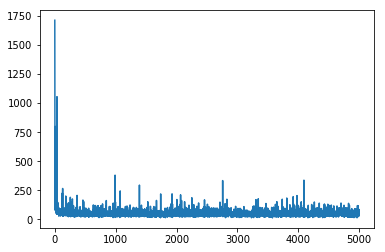

In [30]:
plt.figure()
plt.plot(losses_4)
plt.show()

## Training with embedding size = 4

In [14]:
epoch_range = 5000
batch_size = 150
learning_rate = 0.0001
embedding_size = 4

ae_5 = autoencoder(length, embedding_size).cuda()
ae_5.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_5.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_5 = train_ae(ae_5, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:2350.60498, avg:2350.60498
epoch [2/5000], loss:719.06244, avg:1534.83374
epoch [3/5000], loss:404.97226, avg:1158.21326
epoch [4/5000], loss:106.45682, avg:895.27411
epoch [5/5000], loss:123.05171, avg:740.82965
epoch [6/5000], loss:77.24303, avg:630.23187
epoch [7/5000], loss:364.40833, avg:592.25708
epoch [8/5000], loss:144.88222, avg:536.33521
epoch [9/5000], loss:297.89493, avg:509.84186
epoch [10/5000], loss:581.19238, avg:516.97693
epoch [11/5000], loss:56.33271, avg:287.54968
epoch [12/5000], loss:174.38536, avg:233.08195
epoch [13/5000], loss:81.88660, avg:200.77342
epoch [14/5000], loss:47.58532, avg:194.88628
epoch [15/5000], loss:335.96143, avg:216.17725
epoch [16/5000], loss:230.63110, avg:231.51604
epoch [17/5000], loss:81.75229, avg:203.25044
epoch [18/5000], loss:237.69525, avg:212.53174
epoch [19/5000], loss:73.05569, avg:190.04781
epoch [20/5000], loss:81.54369, avg:140.08293
epoch [21/5000], loss:178.19208, avg:152.26891
epoch [22/5000], loss:48.

epoch [180/5000], loss:32.66137, avg:53.95312
epoch [181/5000], loss:42.03416, avg:53.63163
epoch [182/5000], loss:54.47105, avg:52.89522
epoch [183/5000], loss:58.78313, avg:53.60187
epoch [184/5000], loss:47.19065, avg:50.80203
epoch [185/5000], loss:101.82460, avg:57.15450
epoch [186/5000], loss:282.45990, avg:77.07015
epoch [187/5000], loss:43.08553, avg:76.73089
epoch [188/5000], loss:62.33296, avg:76.69238
epoch [189/5000], loss:65.08240, avg:78.99258
epoch [190/5000], loss:55.55866, avg:81.28230
epoch [191/5000], loss:74.62024, avg:84.54092
epoch [192/5000], loss:41.34508, avg:83.22832
epoch [193/5000], loss:74.91728, avg:84.84174
epoch [194/5000], loss:32.74107, avg:83.39678
epoch [195/5000], loss:84.08889, avg:81.62320
epoch [196/5000], loss:91.80782, avg:62.55799
epoch [197/5000], loss:104.11263, avg:68.66070
epoch [198/5000], loss:57.89723, avg:68.21712
epoch [199/5000], loss:71.61957, avg:68.87084
epoch [200/5000], loss:99.10738, avg:73.22572
epoch [201/5000], loss:95.32166

epoch [358/5000], loss:91.82362, avg:61.06895
epoch [359/5000], loss:59.38995, avg:60.85151
epoch [360/5000], loss:37.15381, avg:58.94012
epoch [361/5000], loss:35.77972, avg:57.17323
epoch [362/5000], loss:58.42463, avg:58.24637
epoch [363/5000], loss:67.36066, avg:59.01295
epoch [364/5000], loss:94.77818, avg:57.67594
epoch [365/5000], loss:50.26429, avg:58.95866
epoch [366/5000], loss:75.50095, avg:60.70530
epoch [367/5000], loss:175.79028, avg:74.62661
epoch [368/5000], loss:26.24602, avg:68.06886
epoch [369/5000], loss:88.08088, avg:70.93794
epoch [370/5000], loss:26.85016, avg:69.90758
epoch [371/5000], loss:27.45654, avg:69.07526
epoch [372/5000], loss:79.85538, avg:71.21835
epoch [373/5000], loss:30.05241, avg:67.48752
epoch [374/5000], loss:81.91902, avg:66.20160
epoch [375/5000], loss:83.78043, avg:69.55322
epoch [376/5000], loss:55.25296, avg:67.52841
epoch [377/5000], loss:72.03223, avg:57.15260
epoch [378/5000], loss:147.16025, avg:69.24403
epoch [379/5000], loss:125.19775

epoch [536/5000], loss:30.67060, avg:72.17245
epoch [537/5000], loss:55.24220, avg:71.01908
epoch [538/5000], loss:93.85345, avg:76.01437
epoch [539/5000], loss:53.83853, avg:76.73983
epoch [540/5000], loss:43.92389, avg:72.01722
epoch [541/5000], loss:289.95358, avg:90.37477
epoch [542/5000], loss:83.57310, avg:91.41886
epoch [543/5000], loss:64.58706, avg:91.00652
epoch [544/5000], loss:64.38454, avg:82.68404
epoch [545/5000], loss:53.12939, avg:83.31564
epoch [546/5000], loss:85.42052, avg:88.79063
epoch [547/5000], loss:65.47886, avg:89.81429
epoch [548/5000], loss:66.86782, avg:87.11573
epoch [549/5000], loss:71.81478, avg:88.91335
epoch [550/5000], loss:344.67334, avg:118.98830
epoch [551/5000], loss:66.90767, avg:96.68371
epoch [552/5000], loss:151.34181, avg:103.46059
epoch [553/5000], loss:61.51027, avg:103.15291
epoch [554/5000], loss:79.24091, avg:104.63854
epoch [555/5000], loss:71.77592, avg:106.50319
epoch [556/5000], loss:123.11015, avg:110.27216
epoch [557/5000], loss:7

epoch [713/5000], loss:94.16834, avg:105.51066
epoch [714/5000], loss:55.65932, avg:106.87453
epoch [715/5000], loss:32.31063, avg:99.51288
epoch [716/5000], loss:49.18998, avg:61.64545
epoch [717/5000], loss:58.24393, avg:58.46895
epoch [718/5000], loss:41.63047, avg:57.62943
epoch [719/5000], loss:87.54746, avg:56.93272
epoch [720/5000], loss:32.99620, avg:54.10920
epoch [721/5000], loss:53.61877, avg:55.02692
epoch [722/5000], loss:50.64931, avg:55.60144
epoch [723/5000], loss:103.73502, avg:56.55811
epoch [724/5000], loss:125.89557, avg:63.58174
epoch [725/5000], loss:131.42397, avg:73.49306
epoch [726/5000], loss:46.64891, avg:73.23897
epoch [727/5000], loss:58.33667, avg:73.24824
epoch [728/5000], loss:71.32172, avg:76.21737
epoch [729/5000], loss:68.17297, avg:74.27991
epoch [730/5000], loss:54.52441, avg:76.43273
epoch [731/5000], loss:51.95001, avg:76.26586
epoch [732/5000], loss:110.89053, avg:82.28998
epoch [733/5000], loss:54.15004, avg:77.33147
epoch [734/5000], loss:50.06

epoch [891/5000], loss:70.47359, avg:73.22319
epoch [892/5000], loss:83.73531, avg:78.14422
epoch [893/5000], loss:63.41879, avg:75.64516
epoch [894/5000], loss:25.26662, avg:66.75568
epoch [895/5000], loss:71.88889, avg:67.52990
epoch [896/5000], loss:95.30379, avg:72.43768
epoch [897/5000], loss:49.34476, avg:72.07821
epoch [898/5000], loss:72.38605, avg:74.90479
epoch [899/5000], loss:128.66304, avg:80.02139
epoch [900/5000], loss:45.38048, avg:70.58614
epoch [901/5000], loss:324.90634, avg:96.02941
epoch [902/5000], loss:122.10293, avg:99.86617
epoch [903/5000], loss:92.18554, avg:102.74285
epoch [904/5000], loss:52.90377, avg:105.50657
epoch [905/5000], loss:53.25975, avg:103.64364
epoch [906/5000], loss:68.28713, avg:100.94198
epoch [907/5000], loss:40.01379, avg:100.00888
epoch [908/5000], loss:60.62335, avg:98.83261
epoch [909/5000], loss:22.08447, avg:88.17475
epoch [910/5000], loss:46.86347, avg:88.32305
epoch [911/5000], loss:46.40606, avg:60.47303
epoch [912/5000], loss:120

epoch [1067/5000], loss:31.08510, avg:82.23754
epoch [1068/5000], loss:96.49177, avg:89.05302
epoch [1069/5000], loss:43.33763, avg:82.93132
epoch [1070/5000], loss:45.58726, avg:78.40577
epoch [1071/5000], loss:75.64070, avg:69.66950
epoch [1072/5000], loss:48.55398, avg:63.93486
epoch [1073/5000], loss:81.36508, avg:61.87745
epoch [1074/5000], loss:43.35821, avg:62.10368
epoch [1075/5000], loss:77.44280, avg:59.97490
epoch [1076/5000], loss:61.33546, avg:60.41980
epoch [1077/5000], loss:28.77109, avg:60.18840
epoch [1078/5000], loss:48.49302, avg:55.38853
epoch [1079/5000], loss:47.26907, avg:55.78167
epoch [1080/5000], loss:86.52055, avg:59.87500
epoch [1081/5000], loss:79.79758, avg:60.29069
epoch [1082/5000], loss:42.22498, avg:59.65778
epoch [1083/5000], loss:44.01192, avg:55.92247
epoch [1084/5000], loss:34.57872, avg:55.04452
epoch [1085/5000], loss:52.56406, avg:52.55665
epoch [1086/5000], loss:64.34120, avg:52.85722
epoch [1087/5000], loss:82.65482, avg:58.24559
epoch [1088/5

epoch [1241/5000], loss:63.39614, avg:78.60174
epoch [1242/5000], loss:116.12291, avg:83.71164
epoch [1243/5000], loss:106.92580, avg:83.96963
epoch [1244/5000], loss:219.81696, avg:100.72755
epoch [1245/5000], loss:45.02693, avg:96.94689
epoch [1246/5000], loss:92.12451, avg:89.04880
epoch [1247/5000], loss:154.10551, avg:98.47511
epoch [1248/5000], loss:26.44733, avg:97.96628
epoch [1249/5000], loss:60.39779, avg:97.51841
epoch [1250/5000], loss:58.20649, avg:94.25704
epoch [1251/5000], loss:67.42376, avg:94.65980
epoch [1252/5000], loss:68.23506, avg:89.87102
epoch [1253/5000], loss:102.65292, avg:89.44372
epoch [1254/5000], loss:79.00008, avg:75.36204
epoch [1255/5000], loss:62.10636, avg:77.06998
epoch [1256/5000], loss:98.54001, avg:77.71152
epoch [1257/5000], loss:62.64046, avg:68.56503
epoch [1258/5000], loss:65.56168, avg:72.47646
epoch [1259/5000], loss:47.23734, avg:71.16042
epoch [1260/5000], loss:39.74113, avg:69.31389
epoch [1261/5000], loss:49.68195, avg:67.53970
epoch [

epoch [1415/5000], loss:94.17542, avg:72.89571
epoch [1416/5000], loss:108.93071, avg:72.71563
epoch [1417/5000], loss:133.43379, avg:83.25884
epoch [1418/5000], loss:104.62695, avg:81.63198
epoch [1419/5000], loss:60.82710, avg:78.97332
epoch [1420/5000], loss:86.11384, avg:78.59894
epoch [1421/5000], loss:55.52784, avg:76.80081
epoch [1422/5000], loss:58.24171, avg:78.49772
epoch [1423/5000], loss:65.68053, avg:81.37454
epoch [1424/5000], loss:98.67615, avg:86.62341
epoch [1425/5000], loss:50.76071, avg:82.28194
epoch [1426/5000], loss:86.64541, avg:80.05340
epoch [1427/5000], loss:48.44364, avg:71.55439
epoch [1428/5000], loss:51.63840, avg:66.25554
epoch [1429/5000], loss:40.06683, avg:64.17951
epoch [1430/5000], loss:97.22381, avg:65.29050
epoch [1431/5000], loss:128.17566, avg:72.55529
epoch [1432/5000], loss:229.14465, avg:89.64558
epoch [1433/5000], loss:106.73346, avg:93.75088
epoch [1434/5000], loss:46.50788, avg:88.53405
epoch [1435/5000], loss:53.89438, avg:88.84741
epoch [

epoch [1589/5000], loss:93.75401, avg:66.89208
epoch [1590/5000], loss:77.66131, avg:67.38043
epoch [1591/5000], loss:105.88277, avg:69.87032
epoch [1592/5000], loss:99.97815, avg:74.76353
epoch [1593/5000], loss:59.32757, avg:73.23825
epoch [1594/5000], loss:156.36530, avg:80.83526
epoch [1595/5000], loss:59.33216, avg:79.84368
epoch [1596/5000], loss:48.29029, avg:78.73315
epoch [1597/5000], loss:50.32842, avg:78.70223
epoch [1598/5000], loss:81.88203, avg:83.28020
epoch [1599/5000], loss:38.26967, avg:77.73177
epoch [1600/5000], loss:45.44262, avg:74.50990
epoch [1601/5000], loss:44.48038, avg:68.36965
epoch [1602/5000], loss:56.41166, avg:64.01301
epoch [1603/5000], loss:86.54587, avg:66.73484
epoch [1604/5000], loss:47.68194, avg:55.86650
epoch [1605/5000], loss:51.31313, avg:55.06460
epoch [1606/5000], loss:33.94652, avg:53.63023
epoch [1607/5000], loss:63.35714, avg:54.93309
epoch [1608/5000], loss:64.03336, avg:53.14823
epoch [1609/5000], loss:75.99233, avg:56.92050
epoch [1610

epoch [1763/5000], loss:146.55426, avg:87.99818
epoch [1764/5000], loss:82.86799, avg:87.52383
epoch [1765/5000], loss:40.69296, avg:87.37479
epoch [1766/5000], loss:56.12914, avg:85.35583
epoch [1767/5000], loss:36.65463, avg:82.62930
epoch [1768/5000], loss:57.72104, avg:79.90847
epoch [1769/5000], loss:186.40942, avg:78.35819
epoch [1770/5000], loss:98.71694, avg:82.74562
epoch [1771/5000], loss:100.61504, avg:86.58597
epoch [1772/5000], loss:132.36453, avg:93.87260
epoch [1773/5000], loss:105.26772, avg:89.74393
epoch [1774/5000], loss:115.13971, avg:92.97112
epoch [1775/5000], loss:123.79367, avg:101.28118
epoch [1776/5000], loss:73.29140, avg:102.99740
epoch [1777/5000], loss:73.80122, avg:106.71207
epoch [1778/5000], loss:90.38137, avg:109.97810
epoch [1779/5000], loss:61.02293, avg:97.43945
epoch [1780/5000], loss:47.15187, avg:92.28294
epoch [1781/5000], loss:37.18626, avg:85.94007
epoch [1782/5000], loss:84.75296, avg:81.17892
epoch [1783/5000], loss:81.89381, avg:78.84151
ep

epoch [1937/5000], loss:87.41730, avg:89.75555
epoch [1938/5000], loss:78.79555, avg:89.63065
epoch [1939/5000], loss:63.78829, avg:88.68292
epoch [1940/5000], loss:388.15350, avg:107.05688
epoch [1941/5000], loss:96.13151, avg:109.10766
epoch [1942/5000], loss:54.41795, avg:108.64651
epoch [1943/5000], loss:98.29185, avg:106.11806
epoch [1944/5000], loss:129.87840, avg:114.75224
epoch [1945/5000], loss:36.36594, avg:113.60355
epoch [1946/5000], loss:51.68538, avg:108.49258
epoch [1947/5000], loss:87.87151, avg:108.53799
epoch [1948/5000], loss:66.50014, avg:107.30846
epoch [1949/5000], loss:170.31683, avg:117.96130
epoch [1950/5000], loss:89.15977, avg:88.06193
epoch [1951/5000], loss:81.72616, avg:86.62139
epoch [1952/5000], loss:62.08741, avg:87.38834
epoch [1953/5000], loss:42.38489, avg:81.79765
epoch [1954/5000], loss:101.78334, avg:78.98814
epoch [1955/5000], loss:58.75220, avg:81.22676
epoch [1956/5000], loss:79.85120, avg:84.04334
epoch [1957/5000], loss:95.38953, avg:84.79515

epoch [2111/5000], loss:53.06512, avg:57.84446
epoch [2112/5000], loss:62.63289, avg:55.46405
epoch [2113/5000], loss:60.79721, avg:52.46492
epoch [2114/5000], loss:83.22652, avg:55.76236
epoch [2115/5000], loss:94.68387, avg:61.63943
epoch [2116/5000], loss:49.70403, avg:61.26941
epoch [2117/5000], loss:33.20169, avg:58.01055
epoch [2118/5000], loss:24.35039, avg:55.13800
epoch [2119/5000], loss:73.75494, avg:56.63296
epoch [2120/5000], loss:105.61276, avg:64.10294
epoch [2121/5000], loss:71.23697, avg:65.92013
epoch [2122/5000], loss:46.76929, avg:64.33376
epoch [2123/5000], loss:55.79793, avg:63.83384
epoch [2124/5000], loss:71.39725, avg:62.65092
epoch [2125/5000], loss:69.65228, avg:60.14775
epoch [2126/5000], loss:110.73442, avg:66.25079
epoch [2127/5000], loss:52.56166, avg:68.18679
epoch [2128/5000], loss:34.41434, avg:69.19318
epoch [2129/5000], loss:44.69199, avg:66.28689
epoch [2130/5000], loss:78.83865, avg:63.60949
epoch [2131/5000], loss:168.77348, avg:73.36313
epoch [213

epoch [2285/5000], loss:221.56880, avg:77.82057
epoch [2286/5000], loss:52.68757, avg:76.57399
epoch [2287/5000], loss:28.92754, avg:74.02325
epoch [2288/5000], loss:63.46108, avg:70.68884
epoch [2289/5000], loss:61.08336, avg:68.86356
epoch [2290/5000], loss:61.29844, avg:66.16360
epoch [2291/5000], loss:87.10185, avg:69.91872
epoch [2292/5000], loss:91.65703, avg:76.71780
epoch [2293/5000], loss:40.42598, avg:76.63912
epoch [2294/5000], loss:69.32451, avg:77.75362
epoch [2295/5000], loss:124.47134, avg:68.04388
epoch [2296/5000], loss:61.52150, avg:68.92726
epoch [2297/5000], loss:55.53551, avg:71.58806
epoch [2298/5000], loss:51.16705, avg:70.35866
epoch [2299/5000], loss:122.63236, avg:76.51357
epoch [2300/5000], loss:38.84541, avg:74.26826
epoch [2301/5000], loss:68.85217, avg:72.44329
epoch [2302/5000], loss:107.76267, avg:74.05386
epoch [2303/5000], loss:152.90645, avg:85.30190
epoch [2304/5000], loss:31.41505, avg:81.51095
epoch [2305/5000], loss:34.04298, avg:72.46811
epoch [2

epoch [2459/5000], loss:60.03546, avg:75.01714
epoch [2460/5000], loss:56.29938, avg:75.29017
epoch [2461/5000], loss:47.75841, avg:69.81342
epoch [2462/5000], loss:138.45268, avg:75.68477
epoch [2463/5000], loss:54.20797, avg:71.05504
epoch [2464/5000], loss:64.46103, avg:73.02132
epoch [2465/5000], loss:51.78122, avg:68.56127
epoch [2466/5000], loss:37.99240, avg:64.16743
epoch [2467/5000], loss:22.63811, avg:58.21553
epoch [2468/5000], loss:64.83538, avg:59.84620
epoch [2469/5000], loss:47.40985, avg:58.58364
epoch [2470/5000], loss:62.16792, avg:59.17050
epoch [2471/5000], loss:74.63867, avg:61.85852
epoch [2472/5000], loss:136.10240, avg:61.62349
epoch [2473/5000], loss:45.34234, avg:60.73693
epoch [2474/5000], loss:43.94039, avg:58.68486
epoch [2475/5000], loss:89.61771, avg:62.46852
epoch [2476/5000], loss:31.03399, avg:61.77267
epoch [2477/5000], loss:57.11382, avg:65.22025
epoch [2478/5000], loss:102.42731, avg:68.97945
epoch [2479/5000], loss:54.53547, avg:69.69201
epoch [248

epoch [2633/5000], loss:41.23114, avg:77.72010
epoch [2634/5000], loss:38.71114, avg:73.46831
epoch [2635/5000], loss:52.89577, avg:74.40346
epoch [2636/5000], loss:49.36769, avg:68.27673
epoch [2637/5000], loss:116.86501, avg:70.65473
epoch [2638/5000], loss:49.21378, avg:69.71542
epoch [2639/5000], loss:60.66330, avg:66.97162
epoch [2640/5000], loss:53.53214, avg:68.41853
epoch [2641/5000], loss:69.28943, avg:67.00800
epoch [2642/5000], loss:84.27605, avg:61.60455
epoch [2643/5000], loss:68.53411, avg:64.33484
epoch [2644/5000], loss:50.16870, avg:65.48060
epoch [2645/5000], loss:116.89976, avg:71.88100
epoch [2646/5000], loss:65.12940, avg:73.45718
epoch [2647/5000], loss:34.86879, avg:65.25755
epoch [2648/5000], loss:55.89069, avg:65.92524
epoch [2649/5000], loss:67.01280, avg:66.56019
epoch [2650/5000], loss:61.61706, avg:67.36868
epoch [2651/5000], loss:74.86871, avg:67.92661
epoch [2652/5000], loss:62.84941, avg:65.78395
epoch [2653/5000], loss:29.46471, avg:61.87701
epoch [2654

epoch [2807/5000], loss:54.03187, avg:85.37379
epoch [2808/5000], loss:67.32085, avg:74.98748
epoch [2809/5000], loss:41.58856, avg:72.67443
epoch [2810/5000], loss:97.82056, avg:76.15417
epoch [2811/5000], loss:69.30199, avg:74.13618
epoch [2812/5000], loss:95.36470, avg:71.43638
epoch [2813/5000], loss:81.95343, avg:71.15209
epoch [2814/5000], loss:41.43191, avg:64.35358
epoch [2815/5000], loss:61.96006, avg:66.88326
epoch [2816/5000], loss:109.03595, avg:71.98099
epoch [2817/5000], loss:39.55651, avg:70.53345
epoch [2818/5000], loss:70.81084, avg:70.88245
epoch [2819/5000], loss:40.21969, avg:70.74557
epoch [2820/5000], loss:38.64656, avg:64.82816
epoch [2821/5000], loss:75.23782, avg:65.42175
epoch [2822/5000], loss:53.72866, avg:61.25814
epoch [2823/5000], loss:63.86042, avg:59.44884
epoch [2824/5000], loss:243.33421, avg:79.63908
epoch [2825/5000], loss:60.84505, avg:79.52757
epoch [2826/5000], loss:117.43678, avg:80.36765
epoch [2827/5000], loss:114.88181, avg:87.90018
epoch [28

epoch [2981/5000], loss:43.77718, avg:68.93835
epoch [2982/5000], loss:92.76327, avg:64.76285
epoch [2983/5000], loss:37.26779, avg:63.67904
epoch [2984/5000], loss:73.00318, avg:62.10206
epoch [2985/5000], loss:169.00325, avg:71.68176
epoch [2986/5000], loss:22.37560, avg:70.16663
epoch [2987/5000], loss:51.33874, avg:71.75822
epoch [2988/5000], loss:44.44588, avg:66.18032
epoch [2989/5000], loss:66.90188, avg:68.07821
epoch [2990/5000], loss:32.87543, avg:63.37521
epoch [2991/5000], loss:90.53515, avg:68.05102
epoch [2992/5000], loss:60.12680, avg:64.78737
epoch [2993/5000], loss:50.64754, avg:66.12535
epoch [2994/5000], loss:154.42497, avg:74.26752
epoch [2995/5000], loss:34.79489, avg:60.84669
epoch [2996/5000], loss:67.00009, avg:65.30914
epoch [2997/5000], loss:64.23251, avg:66.59850
epoch [2998/5000], loss:74.46329, avg:69.60026
epoch [2999/5000], loss:80.53857, avg:70.96393
epoch [3000/5000], loss:59.07802, avg:73.58419
epoch [3001/5000], loss:63.64241, avg:70.89491
epoch [3002

epoch [3155/5000], loss:93.10163, avg:86.73855
epoch [3156/5000], loss:77.43326, avg:91.36729
epoch [3157/5000], loss:76.07248, avg:91.49093
epoch [3158/5000], loss:42.50430, avg:77.01772
epoch [3159/5000], loss:121.82217, avg:84.40486
epoch [3160/5000], loss:72.62817, avg:84.80680
epoch [3161/5000], loss:47.40216, avg:85.84869
epoch [3162/5000], loss:84.90372, avg:80.92819
epoch [3163/5000], loss:34.36795, avg:70.18252
epoch [3164/5000], loss:141.09154, avg:79.13274
epoch [3165/5000], loss:251.69830, avg:94.99242
epoch [3166/5000], loss:64.32749, avg:93.68183
epoch [3167/5000], loss:127.72379, avg:98.84696
epoch [3168/5000], loss:85.05154, avg:103.10168
epoch [3169/5000], loss:171.13026, avg:108.03249
epoch [3170/5000], loss:85.77305, avg:109.34698
epoch [3171/5000], loss:92.31692, avg:113.83846
epoch [3172/5000], loss:89.57298, avg:114.30538
epoch [3173/5000], loss:78.27121, avg:118.69572
epoch [3174/5000], loss:95.87858, avg:114.17442
epoch [3175/5000], loss:65.95160, avg:95.59975
e

epoch [3329/5000], loss:121.80414, avg:96.25932
epoch [3330/5000], loss:84.09714, avg:91.94582
epoch [3331/5000], loss:53.60617, avg:86.24347
epoch [3332/5000], loss:77.84832, avg:73.44876
epoch [3333/5000], loss:42.54845, avg:73.84563
epoch [3334/5000], loss:89.21604, avg:75.90227
epoch [3335/5000], loss:46.77888, avg:76.73788
epoch [3336/5000], loss:51.74760, avg:67.71904
epoch [3337/5000], loss:107.68935, avg:74.17110
epoch [3338/5000], loss:115.17191, avg:79.05080
epoch [3339/5000], loss:86.08324, avg:75.47871
epoch [3340/5000], loss:78.46467, avg:74.91547
epoch [3341/5000], loss:34.97969, avg:73.05282
epoch [3342/5000], loss:62.79857, avg:71.54784
epoch [3343/5000], loss:42.83171, avg:71.57617
epoch [3344/5000], loss:47.23309, avg:67.37788
epoch [3345/5000], loss:56.90191, avg:68.39017
epoch [3346/5000], loss:163.91241, avg:79.60666
epoch [3347/5000], loss:78.22236, avg:76.65996
epoch [3348/5000], loss:45.22668, avg:69.66544
epoch [3349/5000], loss:42.02782, avg:65.25990
epoch [33

epoch [3503/5000], loss:44.85028, avg:73.42690
epoch [3504/5000], loss:33.63902, avg:72.72311
epoch [3505/5000], loss:50.19325, avg:71.27963
epoch [3506/5000], loss:96.89472, avg:74.82223
epoch [3507/5000], loss:67.33516, avg:76.24151
epoch [3508/5000], loss:95.56576, avg:75.94190
epoch [3509/5000], loss:62.97188, avg:72.10092
epoch [3510/5000], loss:73.85828, avg:74.36957
epoch [3511/5000], loss:109.65182, avg:82.44360
epoch [3512/5000], loss:64.32958, avg:69.92898
epoch [3513/5000], loss:76.08611, avg:73.05256
epoch [3514/5000], loss:98.84938, avg:79.57360
epoch [3515/5000], loss:78.13056, avg:82.36733
epoch [3516/5000], loss:50.40829, avg:77.71868
epoch [3517/5000], loss:73.89784, avg:78.37495
epoch [3518/5000], loss:87.39230, avg:77.55761
epoch [3519/5000], loss:101.21084, avg:81.38151
epoch [3520/5000], loss:70.39097, avg:81.03477
epoch [3521/5000], loss:62.71052, avg:76.34064
epoch [3522/5000], loss:44.43179, avg:74.35087
epoch [3523/5000], loss:27.42081, avg:69.48433
epoch [3524

epoch [3677/5000], loss:78.06337, avg:67.05679
epoch [3678/5000], loss:50.75758, avg:66.67122
epoch [3679/5000], loss:53.03590, avg:68.48177
epoch [3680/5000], loss:44.26450, avg:68.04504
epoch [3681/5000], loss:32.49206, avg:65.68435
epoch [3682/5000], loss:28.15837, avg:57.73096
epoch [3683/5000], loss:115.08971, avg:64.18187
epoch [3684/5000], loss:60.68258, avg:65.18533
epoch [3685/5000], loss:71.96872, avg:63.83666
epoch [3686/5000], loss:74.20868, avg:60.87215
epoch [3687/5000], loss:77.12634, avg:60.77844
epoch [3688/5000], loss:51.78934, avg:60.88162
epoch [3689/5000], loss:65.99624, avg:62.17765
epoch [3690/5000], loss:35.81495, avg:61.33270
epoch [3691/5000], loss:65.64159, avg:64.64765
epoch [3692/5000], loss:97.17458, avg:71.54928
epoch [3693/5000], loss:44.64853, avg:64.50516
epoch [3694/5000], loss:40.92625, avg:62.52953
epoch [3695/5000], loss:38.49516, avg:59.18217
epoch [3696/5000], loss:126.89175, avg:64.45048
epoch [3697/5000], loss:42.82416, avg:61.02025
epoch [3698

epoch [3851/5000], loss:102.12016, avg:97.04702
epoch [3852/5000], loss:65.06959, avg:87.37016
epoch [3853/5000], loss:102.02334, avg:86.37771
epoch [3854/5000], loss:81.87500, avg:88.48877
epoch [3855/5000], loss:31.46346, avg:75.68927
epoch [3856/5000], loss:39.37789, avg:72.97078
epoch [3857/5000], loss:65.52418, avg:72.11600
epoch [3858/5000], loss:119.85656, avg:77.86240
epoch [3859/5000], loss:58.34887, avg:75.21047
epoch [3860/5000], loss:54.70038, avg:72.03594
epoch [3861/5000], loss:75.35317, avg:69.35925
epoch [3862/5000], loss:57.16585, avg:68.56887
epoch [3863/5000], loss:66.12977, avg:64.97952
epoch [3864/5000], loss:66.18545, avg:63.41056
epoch [3865/5000], loss:65.13631, avg:66.77785
epoch [3866/5000], loss:47.26181, avg:67.56623
epoch [3867/5000], loss:60.88095, avg:67.10191
epoch [3868/5000], loss:49.45886, avg:60.06215
epoch [3869/5000], loss:113.15342, avg:65.54260
epoch [3870/5000], loss:128.48409, avg:72.92097
epoch [3871/5000], loss:39.42229, avg:69.32788
epoch [3

epoch [4025/5000], loss:115.16105, avg:107.02077
epoch [4026/5000], loss:58.87164, avg:104.08193
epoch [4027/5000], loss:43.73674, avg:99.96796
epoch [4028/5000], loss:37.13792, avg:97.84264
epoch [4029/5000], loss:106.84172, avg:102.07018
epoch [4030/5000], loss:71.40894, avg:96.46302
epoch [4031/5000], loss:40.20198, avg:71.57977
epoch [4032/5000], loss:45.63517, avg:71.21595
epoch [4033/5000], loss:122.37322, avg:71.82478
epoch [4034/5000], loss:46.03116, avg:68.73996
epoch [4035/5000], loss:62.55953, avg:63.47980
epoch [4036/5000], loss:91.91904, avg:66.78454
epoch [4037/5000], loss:117.55747, avg:74.16662
epoch [4038/5000], loss:56.08250, avg:76.06109
epoch [4039/5000], loss:93.16537, avg:74.69344
epoch [4040/5000], loss:55.66057, avg:73.11861
epoch [4041/5000], loss:56.61362, avg:74.75977
epoch [4042/5000], loss:44.39969, avg:74.63622
epoch [4043/5000], loss:55.11810, avg:67.91070
epoch [4044/5000], loss:44.83209, avg:67.79079
epoch [4045/5000], loss:47.31830, avg:66.26668
epoch 

epoch [4199/5000], loss:81.56731, avg:83.63602
epoch [4200/5000], loss:51.46550, avg:82.01978
epoch [4201/5000], loss:59.06256, avg:81.31503
epoch [4202/5000], loss:75.83470, avg:80.31426
epoch [4203/5000], loss:59.16309, avg:74.51865
epoch [4204/5000], loss:47.73751, avg:71.89128
epoch [4205/5000], loss:37.93915, avg:66.23114
epoch [4206/5000], loss:95.33152, avg:66.51531
epoch [4207/5000], loss:71.10415, avg:67.85941
epoch [4208/5000], loss:71.61562, avg:65.08211
epoch [4209/5000], loss:63.01068, avg:63.22645
epoch [4210/5000], loss:71.08640, avg:65.18854
epoch [4211/5000], loss:77.72593, avg:67.05487
epoch [4212/5000], loss:80.04704, avg:67.47612
epoch [4213/5000], loss:56.20169, avg:67.17997
epoch [4214/5000], loss:86.32568, avg:71.03878
epoch [4215/5000], loss:63.22068, avg:73.56695
epoch [4216/5000], loss:85.12803, avg:72.54659
epoch [4217/5000], loss:144.06084, avg:79.84226
epoch [4218/5000], loss:96.01455, avg:82.28215
epoch [4219/5000], loss:42.66889, avg:80.24797
epoch [4220/

epoch [4373/5000], loss:69.03166, avg:63.15912
epoch [4374/5000], loss:42.29518, avg:57.90998
epoch [4375/5000], loss:106.43205, avg:63.28482
epoch [4376/5000], loss:29.37538, avg:62.25967
epoch [4377/5000], loss:54.30202, avg:63.57891
epoch [4378/5000], loss:137.58673, avg:68.80672
epoch [4379/5000], loss:84.98853, avg:72.23132
epoch [4380/5000], loss:71.18653, avg:70.92748
epoch [4381/5000], loss:71.30148, avg:73.59454
epoch [4382/5000], loss:59.45586, avg:72.59555
epoch [4383/5000], loss:151.90240, avg:80.88262
epoch [4384/5000], loss:42.98053, avg:80.95116
epoch [4385/5000], loss:64.56284, avg:76.76424
epoch [4386/5000], loss:62.86528, avg:80.11323
epoch [4387/5000], loss:116.36213, avg:86.31923
epoch [4388/5000], loss:35.88166, avg:76.14873
epoch [4389/5000], loss:46.63413, avg:72.31329
epoch [4390/5000], loss:60.09311, avg:71.20394
epoch [4391/5000], loss:38.72970, avg:67.94676
epoch [4392/5000], loss:66.61883, avg:68.66306
epoch [4393/5000], loss:69.46313, avg:60.41914
epoch [43

epoch [4547/5000], loss:55.82418, avg:81.71832
epoch [4548/5000], loss:41.71188, avg:79.08734
epoch [4549/5000], loss:140.61067, avg:85.80666
epoch [4550/5000], loss:77.03831, avg:85.87594
epoch [4551/5000], loss:64.38804, avg:65.58340
epoch [4552/5000], loss:56.98373, avg:64.72540
epoch [4553/5000], loss:51.69519, avg:64.33031
epoch [4554/5000], loss:87.00079, avg:64.84579
epoch [4555/5000], loss:70.54583, avg:68.33641
epoch [4556/5000], loss:43.82208, avg:68.96207
epoch [4557/5000], loss:249.85976, avg:88.36562
epoch [4558/5000], loss:93.93746, avg:93.58819
epoch [4559/5000], loss:47.73415, avg:84.30053
epoch [4560/5000], loss:59.05201, avg:82.50190
epoch [4561/5000], loss:130.20576, avg:89.08367
epoch [4562/5000], loss:50.29714, avg:88.41501
epoch [4563/5000], loss:53.72341, avg:88.61783
epoch [4564/5000], loss:74.17493, avg:87.33525
epoch [4565/5000], loss:35.65864, avg:83.84653
epoch [4566/5000], loss:75.60555, avg:87.02487
epoch [4567/5000], loss:37.31917, avg:65.77082
epoch [456

epoch [4721/5000], loss:69.16863, avg:84.03268
epoch [4722/5000], loss:101.50274, avg:83.90051
epoch [4723/5000], loss:119.99398, avg:71.33344
epoch [4724/5000], loss:46.22590, avg:70.52801
epoch [4725/5000], loss:60.79421, avg:73.16454
epoch [4726/5000], loss:54.40017, avg:73.99691
epoch [4727/5000], loss:59.59161, avg:74.68162
epoch [4728/5000], loss:59.53015, avg:77.68801
epoch [4729/5000], loss:46.05830, avg:68.14323
epoch [4730/5000], loss:25.10378, avg:64.23695
epoch [4731/5000], loss:47.89409, avg:62.10950
epoch [4732/5000], loss:248.33389, avg:76.79260
epoch [4733/5000], loss:81.59595, avg:72.95281
epoch [4734/5000], loss:49.50109, avg:73.28033
epoch [4735/5000], loss:139.37389, avg:81.13830
epoch [4736/5000], loss:51.16796, avg:80.81508
epoch [4737/5000], loss:43.29064, avg:79.18498
epoch [4738/5000], loss:47.13852, avg:77.94582
epoch [4739/5000], loss:104.48554, avg:83.78854
epoch [4740/5000], loss:55.34382, avg:86.81254
epoch [4741/5000], loss:105.51584, avg:92.57472
epoch [

epoch [4895/5000], loss:67.68416, avg:65.62711
epoch [4896/5000], loss:88.85131, avg:69.43410
epoch [4897/5000], loss:62.31625, avg:71.43726
epoch [4898/5000], loss:116.47697, avg:76.91042
epoch [4899/5000], loss:42.95241, avg:74.49761
epoch [4900/5000], loss:77.18666, avg:74.41137
epoch [4901/5000], loss:87.11347, avg:70.46719
epoch [4902/5000], loss:59.77391, avg:70.56844
epoch [4903/5000], loss:52.34438, avg:71.48048
epoch [4904/5000], loss:124.68509, avg:77.93847
epoch [4905/5000], loss:81.95920, avg:79.36597
epoch [4906/5000], loss:63.35241, avg:76.81608
epoch [4907/5000], loss:119.05924, avg:82.49039
epoch [4908/5000], loss:62.23864, avg:77.06655
epoch [4909/5000], loss:27.43619, avg:75.51492
epoch [4910/5000], loss:49.10777, avg:72.70703
epoch [4911/5000], loss:48.18930, avg:68.81461
epoch [4912/5000], loss:86.28943, avg:71.46616
epoch [4913/5000], loss:115.94330, avg:77.82606
epoch [4914/5000], loss:71.67686, avg:72.52524
epoch [4915/5000], loss:90.82491, avg:73.41181
epoch [49

In [15]:
# torch.save(ae_5, 'models/visapy/ae_4.pt') #Saving the autoencoder model

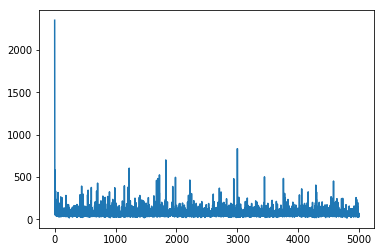

In [16]:
plt.figure()
plt.plot(losses_5)
plt.show()

## Training with embedding size  = 2

In [17]:
epoch_range = 5000
batch_size = 150
learning_rate = 0.0001
embedding_size = 2

ae_6 = autoencoder(length, embedding_size).cuda()
ae_6.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_6.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_6 = train_ae(ae_6, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:3144.26367, avg:3144.26367
epoch [2/5000], loss:859.04114, avg:2001.65234
epoch [3/5000], loss:310.50552, avg:1437.93677
epoch [4/5000], loss:623.09644, avg:1234.22656
epoch [5/5000], loss:275.73932, avg:1042.52917
epoch [6/5000], loss:169.24176, avg:896.98120
epoch [7/5000], loss:112.97678, avg:784.98059
epoch [8/5000], loss:174.85008, avg:708.71423
epoch [9/5000], loss:115.68991, avg:642.82263
epoch [10/5000], loss:502.07993, avg:628.74841
epoch [11/5000], loss:144.03615, avg:328.72568
epoch [12/5000], loss:79.03920, avg:250.72551
epoch [13/5000], loss:258.07147, avg:245.48213
epoch [14/5000], loss:90.20602, avg:192.19307
epoch [15/5000], loss:95.08478, avg:174.12761
epoch [16/5000], loss:359.08524, avg:193.11194
epoch [17/5000], loss:259.12946, avg:207.72720
epoch [18/5000], loss:192.49832, avg:209.49205
epoch [19/5000], loss:217.72017, avg:219.69507
epoch [20/5000], loss:558.18475, avg:225.30557
epoch [21/5000], loss:168.41206, avg:227.74316
epoch [22/5000], lo

epoch [175/5000], loss:194.52856, avg:241.22644
epoch [176/5000], loss:116.00864, avg:240.85344
epoch [177/5000], loss:67.91946, avg:237.96260
epoch [178/5000], loss:160.18747, avg:238.68974
epoch [179/5000], loss:50.98896, avg:232.44930
epoch [180/5000], loss:59.26242, avg:227.53288
epoch [181/5000], loss:84.59491, avg:227.74211
epoch [182/5000], loss:67.78684, avg:165.95963
epoch [183/5000], loss:141.96936, avg:133.00713
epoch [184/5000], loss:154.70552, avg:109.79522
epoch [185/5000], loss:129.16646, avg:103.25901
epoch [186/5000], loss:93.33974, avg:100.99211
epoch [187/5000], loss:100.83547, avg:104.28371
epoch [188/5000], loss:213.69823, avg:109.63478
epoch [189/5000], loss:202.05431, avg:124.74133
epoch [190/5000], loss:98.25474, avg:128.64055
epoch [191/5000], loss:172.80400, avg:137.46147
epoch [192/5000], loss:67.59037, avg:137.44182
epoch [193/5000], loss:70.81461, avg:130.32634
epoch [194/5000], loss:122.77277, avg:127.13308
epoch [195/5000], loss:125.59295, avg:126.77572
e

epoch [347/5000], loss:87.39754, avg:135.03264
epoch [348/5000], loss:92.05480, avg:131.98419
epoch [349/5000], loss:74.93732, avg:129.39659
epoch [350/5000], loss:193.27263, avg:130.59477
epoch [351/5000], loss:123.31602, avg:128.69966
epoch [352/5000], loss:128.34631, avg:112.28892
epoch [353/5000], loss:73.79417, avg:114.18774
epoch [354/5000], loss:658.31360, avg:176.17497
epoch [355/5000], loss:157.54889, avg:177.77977
epoch [356/5000], loss:239.82753, avg:182.88087
epoch [357/5000], loss:544.28583, avg:228.56970
epoch [358/5000], loss:368.44882, avg:256.20911
epoch [359/5000], loss:173.46320, avg:266.06168
epoch [360/5000], loss:104.48006, avg:257.18243
epoch [361/5000], loss:111.71556, avg:256.02240
epoch [362/5000], loss:46.88683, avg:247.87645
epoch [363/5000], loss:194.25497, avg:259.92252
epoch [364/5000], loss:164.91626, avg:210.58281
epoch [365/5000], loss:88.01010, avg:203.62894
epoch [366/5000], loss:79.51407, avg:187.59758
epoch [367/5000], loss:135.19576, avg:146.68857

epoch [520/5000], loss:97.97478, avg:112.74046
epoch [521/5000], loss:64.86723, avg:109.97375
epoch [522/5000], loss:81.51695, avg:111.17675
epoch [523/5000], loss:63.39241, avg:102.05107
epoch [524/5000], loss:95.57474, avg:97.97793
epoch [525/5000], loss:152.78569, avg:99.74798
epoch [526/5000], loss:68.72881, avg:92.98450
epoch [527/5000], loss:101.04144, avg:91.26205
epoch [528/5000], loss:171.16714, avg:101.02531
epoch [529/5000], loss:105.71664, avg:100.27658
epoch [530/5000], loss:112.62454, avg:101.74157
epoch [531/5000], loss:84.35539, avg:103.69037
epoch [532/5000], loss:131.73477, avg:108.71216
epoch [533/5000], loss:177.18637, avg:120.09157
epoch [534/5000], loss:83.99609, avg:118.93369
epoch [535/5000], loss:86.68637, avg:112.32377
epoch [536/5000], loss:120.12221, avg:117.46310
epoch [537/5000], loss:84.46468, avg:115.80544
epoch [538/5000], loss:91.97012, avg:107.88572
epoch [539/5000], loss:226.57236, avg:119.97128
epoch [540/5000], loss:318.21750, avg:140.53058
epoch [

epoch [693/5000], loss:132.43198, avg:116.78426
epoch [694/5000], loss:198.51479, avg:128.66388
epoch [695/5000], loss:77.43198, avg:127.02319
epoch [696/5000], loss:99.27746, avg:131.74733
epoch [697/5000], loss:82.17155, avg:136.06638
epoch [698/5000], loss:76.00087, avg:109.50604
epoch [699/5000], loss:133.74167, avg:112.28344
epoch [700/5000], loss:79.27620, avg:106.20190
epoch [701/5000], loss:139.64604, avg:109.63708
epoch [702/5000], loss:174.29477, avg:119.27874
epoch [703/5000], loss:86.31553, avg:114.66709
epoch [704/5000], loss:262.56973, avg:121.07259
epoch [705/5000], loss:68.49258, avg:120.17864
epoch [706/5000], loss:140.86613, avg:124.33750
epoch [707/5000], loss:43.60835, avg:120.48119
epoch [708/5000], loss:82.37086, avg:121.11819
epoch [709/5000], loss:248.68179, avg:132.61220
epoch [710/5000], loss:101.43971, avg:134.82854
epoch [711/5000], loss:101.69992, avg:131.03394
epoch [712/5000], loss:260.24216, avg:139.62868
epoch [713/5000], loss:99.41655, avg:140.93878
ep

epoch [866/5000], loss:165.48840, avg:204.48103
epoch [867/5000], loss:107.47201, avg:194.46776
epoch [868/5000], loss:33.91868, avg:183.31114
epoch [869/5000], loss:65.31114, avg:164.32237
epoch [870/5000], loss:61.90266, avg:162.88322
epoch [871/5000], loss:97.20894, avg:163.61983
epoch [872/5000], loss:60.83167, avg:166.43343
epoch [873/5000], loss:84.32166, avg:139.79527
epoch [874/5000], loss:275.63300, avg:150.03381
epoch [875/5000], loss:124.90778, avg:107.69960
epoch [876/5000], loss:198.11111, avg:110.96187
epoch [877/5000], loss:282.37054, avg:128.45171
epoch [878/5000], loss:77.30859, avg:132.79073
epoch [879/5000], loss:68.66152, avg:133.12575
epoch [880/5000], loss:114.99369, avg:138.43486
epoch [881/5000], loss:154.28885, avg:144.14284
epoch [882/5000], loss:117.17335, avg:149.77699
epoch [883/5000], loss:339.50873, avg:175.29570
epoch [884/5000], loss:106.88908, avg:158.42133
epoch [885/5000], loss:67.34014, avg:152.66457
epoch [886/5000], loss:115.70115, avg:144.42355
e

epoch [1039/5000], loss:167.04025, avg:121.96018
epoch [1040/5000], loss:199.26396, avg:134.06427
epoch [1041/5000], loss:56.89338, avg:127.01974
epoch [1042/5000], loss:143.65259, avg:134.73375
epoch [1043/5000], loss:410.78366, avg:169.70142
epoch [1044/5000], loss:158.32962, avg:160.89290
epoch [1045/5000], loss:156.96667, avg:169.59007
epoch [1046/5000], loss:94.40745, avg:173.45352
epoch [1047/5000], loss:83.58462, avg:162.65623
epoch [1048/5000], loss:110.34667, avg:158.12688
epoch [1049/5000], loss:114.91433, avg:152.91429
epoch [1050/5000], loss:289.03137, avg:161.89104
epoch [1051/5000], loss:74.51830, avg:163.65353
epoch [1052/5000], loss:160.46126, avg:165.33440
epoch [1053/5000], loss:60.30001, avg:130.28604
epoch [1054/5000], loss:150.97354, avg:129.55043
epoch [1055/5000], loss:150.20641, avg:128.87439
epoch [1056/5000], loss:54.92474, avg:124.92611
epoch [1057/5000], loss:169.53275, avg:133.52092
epoch [1058/5000], loss:271.97504, avg:149.68376
epoch [1059/5000], loss:13

epoch [1208/5000], loss:123.52979, avg:116.50219
epoch [1209/5000], loss:274.55338, avg:124.94059
epoch [1210/5000], loss:80.13999, avg:127.34383
epoch [1211/5000], loss:173.25572, avg:136.27794
epoch [1212/5000], loss:342.06241, avg:155.67772
epoch [1213/5000], loss:225.50914, avg:168.35857
epoch [1214/5000], loss:91.93984, avg:172.12352
epoch [1215/5000], loss:49.86688, avg:169.83154
epoch [1216/5000], loss:58.83969, avg:148.48386
epoch [1217/5000], loss:216.42377, avg:163.61206
epoch [1218/5000], loss:305.72446, avg:181.83153
epoch [1219/5000], loss:558.51642, avg:210.22783
epoch [1220/5000], loss:111.39989, avg:213.35384
epoch [1221/5000], loss:92.47417, avg:205.27567
epoch [1222/5000], loss:75.20213, avg:178.58965
epoch [1223/5000], loss:141.31981, avg:170.17070
epoch [1224/5000], loss:89.16122, avg:169.89285
epoch [1225/5000], loss:187.61487, avg:183.66765
epoch [1226/5000], loss:70.16572, avg:184.80025
epoch [1227/5000], loss:120.45940, avg:175.20381
epoch [1228/5000], loss:61.2

epoch [1377/5000], loss:119.01093, avg:154.94055
epoch [1378/5000], loss:70.99940, avg:153.24294
epoch [1379/5000], loss:106.44347, avg:154.44682
epoch [1380/5000], loss:222.82971, avg:163.37909
epoch [1381/5000], loss:149.20197, avg:133.62520
epoch [1382/5000], loss:94.85344, avg:124.27428
epoch [1383/5000], loss:123.37263, avg:120.41467
epoch [1384/5000], loss:66.26064, avg:117.21478
epoch [1385/5000], loss:139.69095, avg:119.83132
epoch [1386/5000], loss:167.52072, avg:126.01839
epoch [1387/5000], loss:151.67314, avg:129.28461
epoch [1388/5000], loss:92.81236, avg:131.46591
epoch [1389/5000], loss:248.09137, avg:145.63069
epoch [1390/5000], loss:114.75399, avg:134.82314
epoch [1391/5000], loss:107.50561, avg:130.65349
epoch [1392/5000], loss:147.97264, avg:135.96541
epoch [1393/5000], loss:867.25549, avg:210.35368
epoch [1394/5000], loss:198.40593, avg:223.56822
epoch [1395/5000], loss:150.91052, avg:224.69019
epoch [1396/5000], loss:183.16817, avg:226.25493
epoch [1397/5000], loss:

epoch [1546/5000], loss:396.98718, avg:223.14412
epoch [1547/5000], loss:1230.83752, avg:303.57758
epoch [1548/5000], loss:78.46930, avg:295.92578
epoch [1549/5000], loss:74.18353, avg:276.14243
epoch [1550/5000], loss:102.93332, avg:270.83313
epoch [1551/5000], loss:39.35954, avg:269.03159
epoch [1552/5000], loss:137.28998, avg:259.74036
epoch [1553/5000], loss:122.66552, avg:264.48514
epoch [1554/5000], loss:66.19167, avg:251.13347
epoch [1555/5000], loss:287.95230, avg:253.68700
epoch [1556/5000], loss:97.51379, avg:223.73965
epoch [1557/5000], loss:181.50395, avg:118.80629
epoch [1558/5000], loss:163.50322, avg:127.30967
epoch [1559/5000], loss:64.54188, avg:126.34551
epoch [1560/5000], loss:175.71140, avg:133.62334
epoch [1561/5000], loss:510.58636, avg:180.74602
epoch [1562/5000], loss:122.47869, avg:179.26488
epoch [1563/5000], loss:145.04109, avg:181.50244
epoch [1564/5000], loss:229.98956, avg:197.88223
epoch [1565/5000], loss:98.08264, avg:178.89525
epoch [1566/5000], loss:37

epoch [1716/5000], loss:44.46709, avg:153.64069
epoch [1717/5000], loss:100.41133, avg:155.30757
epoch [1718/5000], loss:144.57079, avg:160.23486
epoch [1719/5000], loss:114.02160, avg:165.98904
epoch [1720/5000], loss:68.91273, avg:167.35536
epoch [1721/5000], loss:117.09374, avg:173.51054
epoch [1722/5000], loss:239.90495, avg:183.66409
epoch [1723/5000], loss:90.27411, avg:178.87895
epoch [1724/5000], loss:144.88077, avg:128.62331
epoch [1725/5000], loss:51.21064, avg:111.57478
epoch [1726/5000], loss:140.86574, avg:121.21465
epoch [1727/5000], loss:101.50529, avg:121.32404
epoch [1728/5000], loss:65.86237, avg:113.45320
epoch [1729/5000], loss:99.82330, avg:112.03336
epoch [1730/5000], loss:54.98534, avg:110.64062
epoch [1731/5000], loss:72.11169, avg:106.14243
epoch [1732/5000], loss:162.88091, avg:98.44003
epoch [1733/5000], loss:119.38654, avg:101.35126
epoch [1734/5000], loss:86.06884, avg:95.47007
epoch [1735/5000], loss:61.10699, avg:96.45971
epoch [1736/5000], loss:67.31052,

epoch [1886/5000], loss:65.70727, avg:90.04642
epoch [1887/5000], loss:129.74883, avg:92.38758
epoch [1888/5000], loss:54.99652, avg:91.10146
epoch [1889/5000], loss:117.01205, avg:94.53847
epoch [1890/5000], loss:177.46884, avg:106.62484
epoch [1891/5000], loss:155.07300, avg:116.74408
epoch [1892/5000], loss:287.28067, avg:123.65059
epoch [1893/5000], loss:86.01754, avg:123.74607
epoch [1894/5000], loss:82.77091, avg:125.97371
epoch [1895/5000], loss:99.04197, avg:125.51176
epoch [1896/5000], loss:102.47484, avg:129.18852
epoch [1897/5000], loss:218.04956, avg:138.01860
epoch [1898/5000], loss:93.40561, avg:141.85951
epoch [1899/5000], loss:179.08458, avg:148.06676
epoch [1900/5000], loss:67.22631, avg:137.04251
epoch [1901/5000], loss:72.58110, avg:128.79332
epoch [1902/5000], loss:68.48468, avg:106.91371
epoch [1903/5000], loss:67.82466, avg:105.09444
epoch [1904/5000], loss:164.08461, avg:113.22579
epoch [1905/5000], loss:51.27974, avg:108.44958
epoch [1906/5000], loss:72.72581, a

epoch [2055/5000], loss:52.15264, avg:112.76900
epoch [2056/5000], loss:99.11401, avg:112.78593
epoch [2057/5000], loss:143.27312, avg:99.51633
epoch [2058/5000], loss:51.81656, avg:96.20898
epoch [2059/5000], loss:222.89511, avg:105.22338
epoch [2060/5000], loss:40.22594, avg:100.11710
epoch [2061/5000], loss:352.98914, avg:130.06372
epoch [2062/5000], loss:86.88116, avg:126.91664
epoch [2063/5000], loss:151.44357, avg:129.91273
epoch [2064/5000], loss:77.11352, avg:127.79048
epoch [2065/5000], loss:70.35165, avg:129.61038
epoch [2066/5000], loss:40.85000, avg:123.78399
epoch [2067/5000], loss:40.93777, avg:113.55044
epoch [2068/5000], loss:99.25603, avg:118.29439
epoch [2069/5000], loss:85.58643, avg:104.56353
epoch [2070/5000], loss:197.91125, avg:120.33205
epoch [2071/5000], loss:142.84492, avg:99.31763
epoch [2072/5000], loss:62.32413, avg:96.86193
epoch [2073/5000], loss:335.21878, avg:115.23946
epoch [2074/5000], loss:147.70633, avg:122.29873
epoch [2075/5000], loss:66.46542, av

epoch [2225/5000], loss:50.75473, avg:106.21395
epoch [2226/5000], loss:99.18749, avg:111.71171
epoch [2227/5000], loss:59.12079, avg:112.41380
epoch [2228/5000], loss:355.72159, avg:130.16576
epoch [2229/5000], loss:149.93723, avg:133.30278
epoch [2230/5000], loss:147.55791, avg:137.93108
epoch [2231/5000], loss:57.67456, avg:121.66239
epoch [2232/5000], loss:124.10911, avg:124.92297
epoch [2233/5000], loss:48.63132, avg:118.23405
epoch [2234/5000], loss:148.85785, avg:124.15525
epoch [2235/5000], loss:67.67367, avg:125.84716
epoch [2236/5000], loss:124.98358, avg:128.42676
epoch [2237/5000], loss:160.35194, avg:138.54990
epoch [2238/5000], loss:123.07414, avg:115.28512
epoch [2239/5000], loss:99.64027, avg:110.25543
epoch [2240/5000], loss:86.97826, avg:104.19746
epoch [2241/5000], loss:68.10645, avg:105.24065
epoch [2242/5000], loss:344.96729, avg:127.32648
epoch [2243/5000], loss:188.53453, avg:141.31682
epoch [2244/5000], loss:161.13243, avg:142.54427
epoch [2245/5000], loss:163.1

epoch [2395/5000], loss:56.06720, avg:93.79104
epoch [2396/5000], loss:126.59132, avg:99.97638
epoch [2397/5000], loss:84.38461, avg:92.46095
epoch [2398/5000], loss:75.54172, avg:92.52740
epoch [2399/5000], loss:169.56035, avg:99.46551
epoch [2400/5000], loss:51.56067, avg:98.23747
epoch [2401/5000], loss:66.30988, avg:100.38680
epoch [2402/5000], loss:121.75591, avg:101.94868
epoch [2403/5000], loss:107.00779, avg:93.44637
epoch [2404/5000], loss:92.80158, avg:95.15810
epoch [2405/5000], loss:73.76772, avg:96.92815
epoch [2406/5000], loss:137.03935, avg:97.97296
epoch [2407/5000], loss:167.13504, avg:106.24800
epoch [2408/5000], loss:130.45122, avg:111.73895
epoch [2409/5000], loss:352.42010, avg:130.02493
epoch [2410/5000], loss:127.22387, avg:137.59125
epoch [2411/5000], loss:99.15971, avg:140.87624
epoch [2412/5000], loss:57.55968, avg:134.45660
epoch [2413/5000], loss:91.16584, avg:132.87242
epoch [2414/5000], loss:115.39671, avg:135.13194
epoch [2415/5000], loss:509.08594, avg:1

epoch [2565/5000], loss:252.56747, avg:140.39941
epoch [2566/5000], loss:68.91687, avg:140.76344
epoch [2567/5000], loss:100.75828, avg:141.73485
epoch [2568/5000], loss:80.18394, avg:140.99368
epoch [2569/5000], loss:71.21224, avg:134.57294
epoch [2570/5000], loss:63.33922, avg:108.90069
epoch [2571/5000], loss:69.94302, avg:109.12040
epoch [2572/5000], loss:1225.53296, avg:208.69609
epoch [2573/5000], loss:77.40051, avg:210.36934
epoch [2574/5000], loss:40.11744, avg:204.99719
epoch [2575/5000], loss:113.23043, avg:191.06349
epoch [2576/5000], loss:71.13104, avg:191.28491
epoch [2577/5000], loss:152.04961, avg:196.41405
epoch [2578/5000], loss:78.52039, avg:196.24770
epoch [2579/5000], loss:82.01202, avg:197.32767
epoch [2580/5000], loss:98.36893, avg:200.83064
epoch [2581/5000], loss:121.83568, avg:206.01990
epoch [2582/5000], loss:140.87743, avg:97.55434
epoch [2583/5000], loss:139.17636, avg:103.73193
epoch [2584/5000], loss:98.01415, avg:109.52161
epoch [2585/5000], loss:155.9658

epoch [2735/5000], loss:90.12343, avg:131.33928
epoch [2736/5000], loss:308.35190, avg:152.44127
epoch [2737/5000], loss:470.24649, avg:190.11595
epoch [2738/5000], loss:77.75765, avg:167.77312
epoch [2739/5000], loss:66.82536, avg:169.27890
epoch [2740/5000], loss:122.79846, avg:170.43387
epoch [2741/5000], loss:60.24987, avg:167.07341
epoch [2742/5000], loss:177.13358, avg:148.74809
epoch [2743/5000], loss:149.58186, avg:159.39586
epoch [2744/5000], loss:58.85410, avg:158.19228
epoch [2745/5000], loss:169.79460, avg:166.15939
epoch [2746/5000], loss:61.30394, avg:141.45461
epoch [2747/5000], loss:48.11143, avg:99.24110
epoch [2748/5000], loss:55.31562, avg:96.99689
epoch [2749/5000], loss:184.75217, avg:108.78957
epoch [2750/5000], loss:236.52432, avg:120.16215
epoch [2751/5000], loss:65.38577, avg:120.67574
epoch [2752/5000], loss:65.00237, avg:109.46261
epoch [2753/5000], loss:175.81369, avg:112.08579
epoch [2754/5000], loss:130.00621, avg:119.20100
epoch [2755/5000], loss:201.9460

epoch [2905/5000], loss:99.44382, avg:126.34796
epoch [2906/5000], loss:81.77816, avg:124.94312
epoch [2907/5000], loss:57.84944, avg:126.99098
epoch [2908/5000], loss:72.55171, avg:122.71224
epoch [2909/5000], loss:84.98869, avg:116.97266
epoch [2910/5000], loss:209.73903, avg:130.96729
epoch [2911/5000], loss:133.50543, avg:129.85855
epoch [2912/5000], loss:47.04726, avg:130.52802
epoch [2913/5000], loss:78.85516, avg:94.90959
epoch [2914/5000], loss:152.64461, avg:101.84032
epoch [2915/5000], loss:33.47101, avg:95.24305
epoch [2916/5000], loss:112.41518, avg:98.30675
epoch [2917/5000], loss:174.00891, avg:109.92269
epoch [2918/5000], loss:115.07768, avg:114.17529
epoch [2919/5000], loss:134.21703, avg:119.09812
epoch [2920/5000], loss:249.70477, avg:123.09470
epoch [2921/5000], loss:82.81652, avg:118.02582
epoch [2922/5000], loss:90.24934, avg:122.34603
epoch [2923/5000], loss:55.42927, avg:120.00344
epoch [2924/5000], loss:67.27099, avg:111.46608
epoch [2925/5000], loss:422.17499, 

epoch [3075/5000], loss:216.56120, avg:140.00633
epoch [3076/5000], loss:65.26119, avg:137.75110
epoch [3077/5000], loss:65.26363, avg:135.48805
epoch [3078/5000], loss:95.87848, avg:123.73218
epoch [3079/5000], loss:116.58249, avg:124.05369
epoch [3080/5000], loss:109.68063, avg:127.18648
epoch [3081/5000], loss:54.14323, avg:121.51682
epoch [3082/5000], loss:75.68439, avg:116.32493
epoch [3083/5000], loss:120.37502, avg:102.04160
epoch [3084/5000], loss:106.95506, avg:102.63853
epoch [3085/5000], loss:44.89807, avg:85.47222
epoch [3086/5000], loss:123.39365, avg:91.28547
epoch [3087/5000], loss:89.28606, avg:93.68771
epoch [3088/5000], loss:63.11618, avg:90.41149
epoch [3089/5000], loss:74.56261, avg:86.20950
epoch [3090/5000], loss:99.85116, avg:85.22655
epoch [3091/5000], loss:145.71423, avg:94.38364
epoch [3092/5000], loss:62.04778, avg:93.01998
epoch [3093/5000], loss:227.81653, avg:103.76414
epoch [3094/5000], loss:146.42628, avg:107.71127
epoch [3095/5000], loss:355.59271, avg:

epoch [3245/5000], loss:89.41504, avg:129.01308
epoch [3246/5000], loss:100.96037, avg:119.65596
epoch [3247/5000], loss:108.86158, avg:119.32720
epoch [3248/5000], loss:216.60501, avg:127.78788
epoch [3249/5000], loss:158.25012, avg:138.17599
epoch [3250/5000], loss:98.56110, avg:139.64774
epoch [3251/5000], loss:173.02373, avg:135.98238
epoch [3252/5000], loss:26.15812, avg:125.68461
epoch [3253/5000], loss:182.22830, avg:139.19017
epoch [3254/5000], loss:186.74840, avg:134.08118
epoch [3255/5000], loss:169.74533, avg:142.11421
epoch [3256/5000], loss:128.96843, avg:144.91502
epoch [3257/5000], loss:376.01553, avg:171.63042
epoch [3258/5000], loss:105.24734, avg:160.49463
epoch [3259/5000], loss:164.49060, avg:161.11870
epoch [3260/5000], loss:91.61339, avg:160.42393
epoch [3261/5000], loss:131.45067, avg:156.26662
epoch [3262/5000], loss:99.57951, avg:163.60875
epoch [3263/5000], loss:162.36980, avg:161.62289
epoch [3264/5000], loss:52.78360, avg:148.22641
epoch [3265/5000], loss:40

epoch [3415/5000], loss:113.82185, avg:110.36941
epoch [3416/5000], loss:90.37064, avg:112.63572
epoch [3417/5000], loss:123.03272, avg:119.53985
epoch [3418/5000], loss:130.57037, avg:116.78298
epoch [3419/5000], loss:99.77541, avg:109.43145
epoch [3420/5000], loss:47.19407, avg:98.14346
epoch [3421/5000], loss:76.22319, avg:94.58543
epoch [3422/5000], loss:119.55048, avg:101.69404
epoch [3423/5000], loss:134.17801, avg:107.17110
epoch [3424/5000], loss:333.42850, avg:126.81453
epoch [3425/5000], loss:112.61715, avg:126.69405
epoch [3426/5000], loss:90.43338, avg:126.70033
epoch [3427/5000], loss:138.68277, avg:128.26534
epoch [3428/5000], loss:260.52356, avg:141.26065
epoch [3429/5000], loss:129.97191, avg:144.28030
epoch [3430/5000], loss:123.06623, avg:151.86752
epoch [3431/5000], loss:524.03662, avg:196.64886
epoch [3432/5000], loss:61.60596, avg:190.85442
epoch [3433/5000], loss:83.49953, avg:185.78656
epoch [3434/5000], loss:76.71926, avg:160.11563
epoch [3435/5000], loss:63.833

epoch [3585/5000], loss:115.17219, avg:91.57172
epoch [3586/5000], loss:94.28560, avg:95.73861
epoch [3587/5000], loss:51.35513, avg:90.28918
epoch [3588/5000], loss:60.04544, avg:88.69193
epoch [3589/5000], loss:231.22887, avg:103.75781
epoch [3590/5000], loss:261.57809, avg:117.70095
epoch [3591/5000], loss:149.76367, avg:124.88573
epoch [3592/5000], loss:61.01694, avg:120.32049
epoch [3593/5000], loss:139.78615, avg:126.34013
epoch [3594/5000], loss:79.97274, avg:124.42049
epoch [3595/5000], loss:121.86839, avg:125.09011
epoch [3596/5000], loss:231.13863, avg:138.77542
epoch [3597/5000], loss:137.29092, avg:147.36899
epoch [3598/5000], loss:36.68184, avg:145.03264
epoch [3599/5000], loss:133.88612, avg:135.29836
epoch [3600/5000], loss:95.65535, avg:118.70608
epoch [3601/5000], loss:291.52573, avg:132.88228
epoch [3602/5000], loss:85.09252, avg:135.28984
epoch [3603/5000], loss:70.48798, avg:128.36002
epoch [3604/5000], loss:115.53706, avg:131.91646
epoch [3605/5000], loss:285.26031

epoch [3755/5000], loss:90.60535, avg:121.59138
epoch [3756/5000], loss:66.00616, avg:118.39317
epoch [3757/5000], loss:190.46234, avg:130.74498
epoch [3758/5000], loss:287.75031, avg:149.91350
epoch [3759/5000], loss:50.17474, avg:144.23184
epoch [3760/5000], loss:46.52485, avg:139.91653
epoch [3761/5000], loss:96.52449, avg:136.03993
epoch [3762/5000], loss:97.97928, avg:140.61679
epoch [3763/5000], loss:77.23284, avg:120.08083
epoch [3764/5000], loss:160.22771, avg:116.34881
epoch [3765/5000], loss:54.34084, avg:112.72235
epoch [3766/5000], loss:88.98230, avg:115.01997
epoch [3767/5000], loss:46.94148, avg:100.66788
epoch [3768/5000], loss:106.99812, avg:82.59267
epoch [3769/5000], loss:78.81623, avg:85.45681
epoch [3770/5000], loss:59.73193, avg:86.77752
epoch [3771/5000], loss:72.79147, avg:84.40422
epoch [3772/5000], loss:115.05093, avg:86.11138
epoch [3773/5000], loss:102.54923, avg:88.64303
epoch [3774/5000], loss:99.83137, avg:82.60339
epoch [3775/5000], loss:173.40233, avg:94

epoch [3925/5000], loss:174.99414, avg:200.74094
epoch [3926/5000], loss:71.24687, avg:198.70544
epoch [3927/5000], loss:79.01322, avg:146.37419
epoch [3928/5000], loss:121.77412, avg:149.20764
epoch [3929/5000], loss:77.45150, avg:142.23094
epoch [3930/5000], loss:95.94489, avg:132.97176
epoch [3931/5000], loss:145.46475, avg:141.07507
epoch [3932/5000], loss:122.86407, avg:139.61955
epoch [3933/5000], loss:67.69203, avg:104.67096
epoch [3934/5000], loss:115.78986, avg:107.22355
epoch [3935/5000], loss:95.62470, avg:99.28661
epoch [3936/5000], loss:81.08217, avg:100.27013
epoch [3937/5000], loss:108.69891, avg:103.23870
epoch [3938/5000], loss:63.05141, avg:97.36642
epoch [3939/5000], loss:94.45820, avg:99.06710
epoch [3940/5000], loss:82.35713, avg:97.70832
epoch [3941/5000], loss:87.28998, avg:91.89085
epoch [3942/5000], loss:220.43172, avg:101.64761
epoch [3943/5000], loss:87.72743, avg:103.65115
epoch [3944/5000], loss:195.35985, avg:111.60815
epoch [3945/5000], loss:74.97904, avg

epoch [4095/5000], loss:111.98325, avg:132.91756
epoch [4096/5000], loss:271.99057, avg:149.98412
epoch [4097/5000], loss:116.05510, avg:140.25819
epoch [4098/5000], loss:200.13426, avg:147.81641
epoch [4099/5000], loss:54.90731, avg:134.75114
epoch [4100/5000], loss:81.12740, avg:133.62932
epoch [4101/5000], loss:73.56504, avg:133.12439
epoch [4102/5000], loss:65.07464, avg:132.21455
epoch [4103/5000], loss:51.29251, avg:122.71603
epoch [4104/5000], loss:56.12521, avg:108.22554
epoch [4105/5000], loss:438.97684, avg:140.92490
epoch [4106/5000], loss:206.60785, avg:134.38663
epoch [4107/5000], loss:115.72629, avg:134.35374
epoch [4108/5000], loss:99.35362, avg:124.27567
epoch [4109/5000], loss:115.02197, avg:130.28714
epoch [4110/5000], loss:113.90279, avg:133.56468
epoch [4111/5000], loss:101.51287, avg:136.35947
epoch [4112/5000], loss:78.85864, avg:137.73785
epoch [4113/5000], loss:200.22874, avg:152.63148
epoch [4114/5000], loss:1637.17444, avg:310.73642
epoch [4115/5000], loss:61.

epoch [4264/5000], loss:83.17266, avg:119.92822
epoch [4265/5000], loss:121.18398, avg:120.74462
epoch [4266/5000], loss:244.90192, avg:139.61986
epoch [4267/5000], loss:64.58427, avg:128.69032
epoch [4268/5000], loss:238.52977, avg:142.86180
epoch [4269/5000], loss:61.75714, avg:137.57829
epoch [4270/5000], loss:74.71151, avg:120.81744
epoch [4271/5000], loss:162.64671, avg:132.72455
epoch [4272/5000], loss:128.81473, avg:130.58853
epoch [4273/5000], loss:58.81512, avg:123.91177
epoch [4274/5000], loss:88.85918, avg:124.48042
epoch [4275/5000], loss:81.68051, avg:120.53009
epoch [4276/5000], loss:63.44324, avg:102.38423
epoch [4277/5000], loss:321.00430, avg:128.02623
epoch [4278/5000], loss:85.25106, avg:112.69836
epoch [4279/5000], loss:67.75312, avg:113.29795
epoch [4280/5000], loss:85.13109, avg:114.33990
epoch [4281/5000], loss:112.13472, avg:109.28871
epoch [4282/5000], loss:41.69244, avg:100.57648
epoch [4283/5000], loss:136.17210, avg:108.31217
epoch [4284/5000], loss:93.55934

epoch [4434/5000], loss:277.06308, avg:115.54695
epoch [4435/5000], loss:56.59016, avg:111.45318
epoch [4436/5000], loss:74.68909, avg:106.40603
epoch [4437/5000], loss:184.61555, avg:112.64021
epoch [4438/5000], loss:117.72030, avg:113.76070
epoch [4439/5000], loss:124.51565, avg:119.42934
epoch [4440/5000], loss:180.07623, avg:127.62510
epoch [4441/5000], loss:518.10370, avg:170.25186
epoch [4442/5000], loss:173.31879, avg:182.26704
epoch [4443/5000], loss:93.93626, avg:180.06290
epoch [4444/5000], loss:219.84410, avg:174.34099
epoch [4445/5000], loss:81.30503, avg:176.81248
epoch [4446/5000], loss:109.49527, avg:180.29311
epoch [4447/5000], loss:206.18895, avg:182.45042
epoch [4448/5000], loss:52.10639, avg:175.88904
epoch [4449/5000], loss:116.35488, avg:175.07297
epoch [4450/5000], loss:33.85126, avg:160.45049
epoch [4451/5000], loss:58.22509, avg:114.46262
epoch [4452/5000], loss:102.03280, avg:107.33400
epoch [4453/5000], loss:166.46756, avg:114.58714
epoch [4454/5000], loss:125

epoch [4603/5000], loss:140.81902, avg:113.36839
epoch [4604/5000], loss:80.60453, avg:107.71349
epoch [4605/5000], loss:126.76006, avg:102.93672
epoch [4606/5000], loss:57.42018, avg:86.48717
epoch [4607/5000], loss:96.81022, avg:89.71661
epoch [4608/5000], loss:107.50095, avg:94.45613
epoch [4609/5000], loss:96.79576, avg:99.18304
epoch [4610/5000], loss:65.31410, avg:92.92146
epoch [4611/5000], loss:103.44588, avg:93.63931
epoch [4612/5000], loss:69.51910, avg:94.49898
epoch [4613/5000], loss:131.38402, avg:93.55548
epoch [4614/5000], loss:95.31223, avg:95.02625
epoch [4615/5000], loss:182.90552, avg:100.64080
epoch [4616/5000], loss:53.64590, avg:100.26337
epoch [4617/5000], loss:41.27853, avg:94.71020
epoch [4618/5000], loss:395.87204, avg:123.54730
epoch [4619/5000], loss:58.44578, avg:119.71230
epoch [4620/5000], loss:152.01819, avg:128.38272
epoch [4621/5000], loss:172.19839, avg:135.25797
epoch [4622/5000], loss:163.28546, avg:144.63460
epoch [4623/5000], loss:133.47298, avg:1

epoch [4773/5000], loss:89.30695, avg:84.48137
epoch [4774/5000], loss:105.73221, avg:90.86797
epoch [4775/5000], loss:94.85344, avg:92.81255
epoch [4776/5000], loss:411.12881, avg:126.14160
epoch [4777/5000], loss:73.48524, avg:128.06171
epoch [4778/5000], loss:216.97000, avg:141.84961
epoch [4779/5000], loss:62.63189, avg:142.20113
epoch [4780/5000], loss:263.13895, avg:162.34911
epoch [4781/5000], loss:90.10861, avg:150.14873
epoch [4782/5000], loss:74.07263, avg:148.14287
epoch [4783/5000], loss:154.43622, avg:154.65581
epoch [4784/5000], loss:310.14047, avg:175.09665
epoch [4785/5000], loss:72.67808, avg:172.87910
epoch [4786/5000], loss:61.01978, avg:137.86819
epoch [4787/5000], loss:203.76088, avg:150.89575
epoch [4788/5000], loss:102.31922, avg:139.43068
epoch [4789/5000], loss:173.76680, avg:150.54417
epoch [4790/5000], loss:160.86342, avg:140.31662
epoch [4791/5000], loss:83.77299, avg:139.68304
epoch [4792/5000], loss:64.23595, avg:138.69939
epoch [4793/5000], loss:89.17748,

epoch [4943/5000], loss:79.42096, avg:85.72128
epoch [4944/5000], loss:99.93034, avg:90.34054
epoch [4945/5000], loss:120.12102, avg:85.24960
epoch [4946/5000], loss:37.50828, avg:82.93392
epoch [4947/5000], loss:54.04060, avg:80.21917
epoch [4948/5000], loss:65.31432, avg:80.23893
epoch [4949/5000], loss:202.19522, avg:95.60802
epoch [4950/5000], loss:56.65284, avg:96.55515
epoch [4951/5000], loss:133.56470, avg:97.00602
epoch [4952/5000], loss:374.03592, avg:122.27842
epoch [4953/5000], loss:136.51303, avg:127.98763
epoch [4954/5000], loss:64.46350, avg:124.44094
epoch [4955/5000], loss:51.60184, avg:117.58903
epoch [4956/5000], loss:84.35867, avg:122.27406
epoch [4957/5000], loss:412.52945, avg:158.12294
epoch [4958/5000], loss:162.21577, avg:167.81310
epoch [4959/5000], loss:356.27106, avg:183.22069
epoch [4960/5000], loss:59.75069, avg:183.53047
epoch [4961/5000], loss:224.75670, avg:192.64967
epoch [4962/5000], loss:189.26363, avg:174.17245
epoch [4963/5000], loss:189.98827, avg:

In [18]:
# torch.save(ae_6, 'models/visapy/ae_2.pt') #Saving the autoencoder model

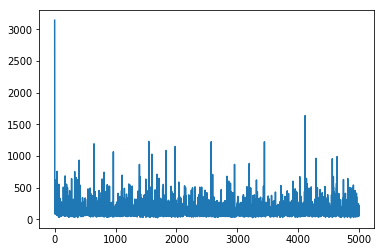

In [19]:
plt.figure()
plt.plot(losses_6)
plt.show()

-7.899686098098755
-13.200496032834053
-0.3357892632484436
-2.2524374425411224
-----------------
-8.460121497511864
-7.923975110054016
4.134825825691223
3.2072027921676636
-----------------
-10.951744556427002
-7.349241256713867
4.4009164571762085
4.822971940040588
-----------------
-3.1704137325286865
-9.954895913600922
-1.300156593322754
8.125901222229004
-----------------
-12.66503119468689
-9.818133533000946
3.68465256690979
1.538285732269287
-----------------
-9.747145920991898
-6.867068529129028
2.465514838695526
1.4959092140197754
-----------------
2.717270791530609
6.599548578262329
2.666946291923523
0.2091212272644043
-----------------


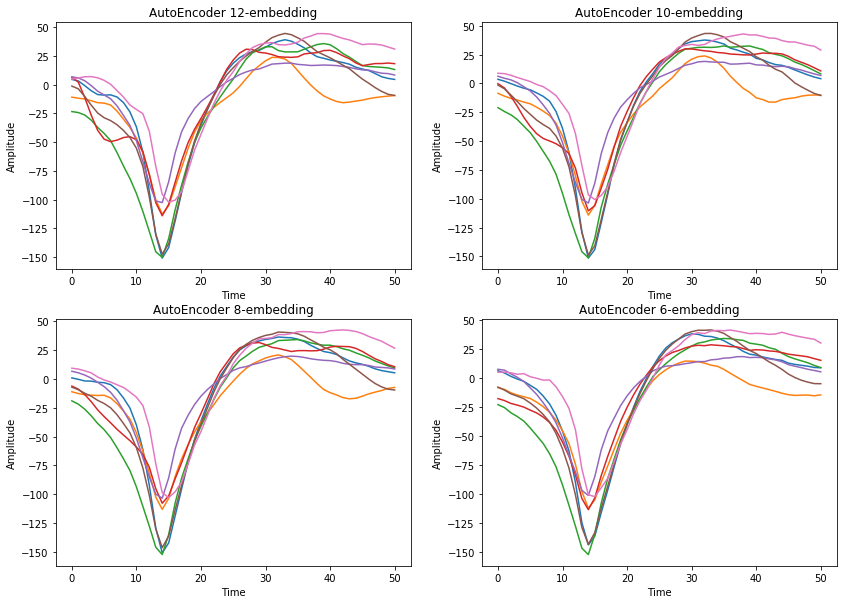

In [31]:
plt.figure(figsize=(14,10))

# n = [1, 30, 45, 50, 65]
n = [11, 290, 3490, 1098, 2707, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o_1 = ae_1.forward(data)
    o_1 = (o_1.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_1)))
    enc, o_2 = ae_2.forward(data)
    o_2 = (o_2.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_2)))
    enc, o_3 = ae_3.forward(data)
    o_3 = (o_3.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_3)))
    enc, o_4 = ae_4.forward(data)
    o_4 = (o_4.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_4)))
    print('-----------------')
    plt.subplot(221)
    plt.plot(o_1)
    plt.title('AutoEncoder 12-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(222)
    plt.plot(o_2)
    plt.title('AutoEncoder 10-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(223)
    plt.plot(o_3)
    plt.title('AutoEncoder 8-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(224)
    plt.plot(o_4)
    plt.title('AutoEncoder 6-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.show()

# ---------------- LOAD MODELS TO USE -------------------

In [9]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (15472, 51)
Test Datasize: (3869, 51)


### Loading the autoencoders

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [15]:
# Make sure to execute autoencoder model code before executing this

ae_1 = torch.load('models/visapy/ae_12.pt')
ae_2 = torch.load('models/visapy/ae_10.pt')
ae_3 = torch.load('models/visapy/ae_8.pt')
ae_4 = torch.load('models/visapy/ae_6.pt')